**PyOD 2 Guided Anomaly Detection with Model Selection via Symbolic Reasoning and Empirical Validation on External Network Traffic Data using CICIDS2017**

**Initial Environment Setup: One-Time Package Installations**

In [5]:
# !pip install -U pyod
# !pip install markdown2
# !pip install pdfkit
# !pip install tabulate
# !pip install openai
# !pip install python-dotenv
# !pip install python-docx
# !pip install pympler

**Required One-Time Installations**

**pyod**

* `pip install -U pyod`:

  * Installs the **latest version** (PyOD 1.0+ a.k.a. “PyOD 2”).
  * Provides a unified API for **outlier detection models**.
  * Includes traditional, ensemble, and deep learning models like:

    * Isolation Forest, LOF, AutoEncoder, VAE, DevNet, etc.
  * Works well with NumPy, Pandas, and Scikit-learn.
 
**markdown2**

* `pip install markdown2`:

  * Converts **Markdown to HTML**.
  * Used to transform LLM-generated text into HTML for rendering in `pdfkit`.

**pdfkit**

* `pip install pdfkit`:

  * Wrapper around `wkhtmltopdf` to convert **HTML ➝ PDF**.
  * Useful for rendering styled, image-embedded PDFs from LLM + EDA outputs.

**tabulate**

* `pip install tabulate`:

  * Used for **pretty-printing tabular outputs** in text or console.
  * May be optional, but helpful during dev/debug stages.

**openai**

* `pip install openai`:

  * Official client for **OpenAI APIs** (ChatGPT, GPT-4, etc.).
  * Used to send prompts and receive completions for LLM-driven reporting.

**python-dotenv**

* `pip install python-dotenv`:

  * Loads `.env` files and exposes **API keys securely** (e.g., `OPENAI_API_KEY`).
  * Prevents hardcoding sensitive values into source code.

**python-docx**

* `pip install python-docx`:

  * Enables reading/writing **Word (.docx)** files from Python.
  * Useful if you extend the pipeline to export to DOCX or ingest prior reports.

**pympler**

* `pip install pympler`:

  * Optional but used for **memory profiling**.
  * Handy if the notebook has long-running or memory-heavy processes (like large LLM JSON structures or charts).

---

In [6]:
# import pyod
# print("PyOD version:", pyod.__version__)

**Imports of Libraries and Core Dependencies**
- This section includes all core libraries and helper utilities required across the notebook.

In [7]:
# -----------------------------
# Core Python and System Libraries
# -----------------------------
import os  # OS interface
import csv  # CSV file handling
import json  # JSON read/write
import hashlib  # Hashing for integrity or IDs
import warnings  # Suppress unwanted warnings
warnings.filterwarnings("ignore")  # Cleaner output
from glob import glob  # File pattern matching
from collections import Counter  # Frequency counting
from datetime import datetime  # Date/time utilities
import re  # Regex operations

# -----------------------------
# Document Handling (DOCX)
# -----------------------------
from docx import Document  # Word document creation
from docx.shared import Inches, Pt  # Sizing and font utilities
from docx.oxml.ns import qn  # XML namespace access
from docx.oxml import OxmlElement  # Low-level XML manipulation
from docx.enum.text import WD_ALIGN_PARAGRAPH  # Paragraph alignment
from docx.enum.table import WD_TABLE_ALIGNMENT  # Table alignment
import textwrap  # Formatting long text into wrapped blocks

# -----------------------------
# Data Manipulation and Visualization
# -----------------------------
import numpy as np  # Numerical computations
import pandas as pd  # Data handling and analysis
import matplotlib.pyplot as plt  # Base plotting
import seaborn as sns  # Advanced statistical plots

# Jupyter display utilities
from IPython.display import display, Markdown, Image, HTML

# -----------------------------
# Scientific and Statistical Libraries
# -----------------------------
import scipy.stats as stats  # Stats functions (e.g., t-tests)
import scipy.io  # MATLAB file I/O
from scipy.io import loadmat  # Alternate .mat file reader
from io import StringIO  # In-memory text stream
from IPython.utils import io  # Suppress output block

# -----------------------------
# Machine Learning Utilities (scikit-learn)
# -----------------------------
import joblib  # Model saving/loading
from sklearn.pipeline import Pipeline  # ML pipelines
from sklearn.preprocessing import StandardScaler  # Feature normalization
from sklearn.metrics import (
    classification_report,  # Detailed performance
    roc_auc_score,  # ROC-AUC score
    average_precision_score,  # PR-AUC
    accuracy_score  # Accuracy score
)

# -----------------------------
# PyOD: Outlier Detection Models
# -----------------------------
# Utilities
from pyod.utils.data import generate_data, evaluate_print  # For demos
from pyod.utils.example import visualize  # Demo plotting

# Traditional models
from pyod.models.iforest import IForest  # Isolation Forest
from pyod.models.lof import LOF  # Local Outlier Factor

# Deep Learning models
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.devnet import DevNet
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.lunar import LUNAR

# GAN-based models
from pyod.models.anogan import AnoGAN
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

# -----------------------------
# Parallelism and Performance Monitoring
# -----------------------------
from concurrent.futures import ProcessPoolExecutor, as_completed  # Multiprocessing
from tqdm import tqdm  # Loop progress bar
import logging  # Logging and debug info

# -----------------------------
# Markdown and PDF Reporting
# -----------------------------
from tabulate import tabulate  # Pretty console tables
import markdown2  # Markdown ➝ HTML
import pdfkit  # HTML ➝ PDF (needs wkhtmltopdf)
import subprocess  # Run CLI commands (if needed)

# -----------------------------
# OpenAI Integration
# -----------------------------
from openai import OpenAI  # Chat/Completion API
from dotenv import load_dotenv  # Load API keys from .env

# -----------------------------
# Miscellaneous
# -----------------------------
import sys
from pympler import asizeof
#print(os.getcwd())  # Print current working directory

**Import Core Libraries and Models**

In this step, we import all the essential Python libraries and modules required for the full anomaly detection workflow:

- **Data Manipulation and Visualization**  
  `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`, and `IPython.display` are used for loading, exploring, and visualizing data.

- **PyOD Utilities and Models**  
  We import PyOD utilities (`generate_data`, `evaluate_print`, `visualize`) and a diverse set of anomaly detection models:
  - **Traditional Models**: Isolation Forest (`IForest`), Local Outlier Factor (`LOF`)
  - **Deep Learning Models**: AutoEncoder, Variational AutoEncoder (`VAE`), DevNet, Deep SVDD, LUNAR
  - **GAN-based Models**: AnoGAN, SO-GAAL, MO-GAAL

- **Scikit-learn Utilities**  
  For model preprocessing, evaluation, and pipeline creation (`StandardScaler`, `Pipeline`, and metrics like `roc_auc_score`, `accuracy_score`, etc.)

- **Parallel and Utility Tools**  
  `concurrent.futures` and `tqdm` are used for parallel processing and progress tracking during model training and evaluation.

- **File and System Operations**  
  `os`, `json`, `hashlib`, `glob`, and `datetime` help with environment setup, file I/O, and metadata management.

- **Output Formatting and Exporting**  
  `tabulate` is used for generating clean tables, while `markdown2` and `pdfkit` enable exporting reports from Markdown to PDF format (requires `wkhtmltopdf` installed).

- **OpenAI Integration**  
  `openai` and `dotenv` are imported to enable use of OpenAI APIs, securely loading keys via environment variables.

- **Clean Output**  
  We suppress warnings using the `warnings` module to maintain clean nd readable notebook output.


**Import Core Libraries and Models**

In this step, we import all the essential Python libraries and modules required for the full anomaly detection + reporting workflow:

---

**Data Manipulation and Visualization**
- `pandas`, `numpy`: Data loading, wrangling, and matrix operations.
- `matplotlib`, `seaborn`: Plotting charts and visualizing results.
- `scipy`, `IPython.display`: Statistical analysis and in-notebook display.

---

**PyOD Models for Anomaly Detection**
We use PyOD's extensive library of detection models:
- **Traditional**: `IForest`, `LOF`
- **Deep Learning**: `AutoEncoder`, `VAE`, `DevNet`, `DeepSVDD`, `LUNAR`
- **GAN-Based**: `AnoGAN`, `SO-GAAL`, `MO-GAAL`
- Also includes utilities for demo evaluation and visualizations.

---

**Machine Learning Evaluation (scikit-learn)**
- `Pipeline`, `StandardScaler`: Model pre-processing.
- `classification_report`, `roc_auc_score`, `accuracy_score`: Performance metrics.

---

**System and File Operations**
- `os`, `glob`, `hashlib`, `datetime`, `json`: File I/O, path matching, metadata.
- `textwrap`, `re`: Text formatting and regex utilities.
- `warnings`: Suppress warning messages for cleaner output.

---

**Document Formatting (DOCX and PDF)**
- `python-docx`: Build Word documents programmatically.
- `markdown2`, `pdfkit`: Convert LLM-generated Markdown ➝ HTML ➝ PDF.
- `tabulate`: Console-friendly table rendering.

---

**Parallelism and Logging**
- `concurrent.futures`: Multi-core execution for model runs.
- `tqdm`: Real-time progress tracking.
- `logging`: For debug and event logging.

---

**OpenAI API Integration**
- `openai`, `dotenv`: For LLM-driven report generation with secure key handling.

---

**Loading and viewing .mat type of pre-processed files**

In [8]:
# Define .mat file paths
benchmark_datasets_paths = {
    "arrhythmia": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/arrhythmia.mat",
    "cardio": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/cardio.mat",
    "glass": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/glass.mat",    
    "ionosphere": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/ionosphere.mat",            
    "letter": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/letter.mat",
    "lympho": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/lympho.mat",
    "mnist": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/mnist.mat",
    "musk": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/musk.mat",
    "optdigits": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/optdigits.mat",
    "pendigits": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/pendigits.mat",    
    "satellite": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/satellite.mat",
    "satimage2": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/satimage2.mat",
    "shuttle": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/shuttle.mat",    
    "vowels": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/vowels.mat",
    "wbc": "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/wbc.mat"
    
}

**These are Called Benchmark Datasets**

- The 15 datasets used in this project are commonly referred to as **benchmark datasets** in the field of anomaly detection. These datasets are not arbitrary — they have been selected by the anomaly detection community (e.g., PyOD, ODDS Library, academic literature) due to their:
- Coverage of real-world challenges  
- Public accessibility  
- Proven utility in research validation  

- These benchmarks allow researchers and practitioners to **evaluate and compare models under standardized, reproducible, and diverse conditions**.

---

**Key Reasons These Are Considered Benchmarks**

| **Criteria**              | **Explanation**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|
| **Standardization**       | Widely used in anomaly detection research; results are directly comparable.     |
| **Variety of Characteristics** | Vary in sample size, feature dimensionality, imbalance ratio, skewness, and kurtosis. |
| **Availability & Reproducibility** | Publicly accessible and preprocessed consistently (via PyOD or ODDS).            |
| **Domain Diversity**      | Cover multiple real-world fields: medical, industrial, cybersecurity, etc.      |
| **Challenge Diversity**   | Include both easy and hard anomaly detection tasks to test model generalization.|

These datasets form the foundation for fair and insightful performance comparisons in anomaly detection systems.

**Table: PyOD2 Benchmark Datasets Overview**

| Dataset   | Domain/Field       | Type of Data                         | Sample Size | Features | Anomaly Ratio | Why It’s Benchmark-Worthy |
|-----------|--------------------|--------------------------------------|-------------|----------|----------------|-----------------------------|
| Arrhythmia | Medical (ECG)      | ECG heart signal features            | 452         | 274      | ~14%           | High-dimensional, low-sample, class imbalance |
| Cardio    | Medical            | Cardiac diagnosis measurements       | 1831        | 21       | ~9%            | Imbalanced data, moderate size |
| Glass     | Forensic/Chemical  | Chemical analysis of glass           | 214         | 9        | ~4%            | Small sample, low-dimension |
| Ionosphere | Radar/Aerospace   | Radar signal returns                 | 351         | 34       | ~36%           | Balanced anomalies, structured data |
| Letter    | Optical character rec. | Handwritten letters              | 1600        | 32       | ~6%            | Imbalanced, high overlap between classes |
| Lympho    | Medical            | Lymphography data                    | 148         | 18       | ~4%            | Very small sample, low anomaly rate |
| Mnist     | Image (Digits)     | Pixel intensity features             | 7603        | 100      | ~9%            | High-dimensional, real-world image variation |
| Musk      | Chemistry/Pharma   | Molecule attributes                  | 3062        | 166      | ~3.2%          | High-dimension, real anomaly labels |
| Optdigits | Optical digits     | Pixel averages per digit             | 5216        | 64       | ~3%            | Clear cluster structures, low anomaly % |
| Pendigits | Handwriting        | Stylus pen trajectory data           | 6870        | 16       | ~2.3%          | Sequential numerical input, class structure |
| Satellite | Remote sensing     | Pixel bands from satellite           | 6435        | 36       | ~31%           | Large anomaly share, spatial data |
| Satimg2   | Remote sensing     | Synthetic satellite imagery          | 5000        | 45       | ~28%           | High-dimension, simulation-based testbed |
| Shuttle   | Aerospace/Telemetry| Engine and control measurements      | 49097       | 9        | ~7%            | Very large, low-dimensional, well-separated classes |
| Vowels    | Speech             | Acoustic features of spoken vowels   | 1456        | 12       | ~2.3%          | Subtle anomalies, class similarity |
| Wbc       | Medical            | Breast cancer biopsy features        | 569         | 30       | ~6%            | Low-dimension, biomedical application |

**CICIDS2017, the external dataset, is from the cybersecurity domain. It’s not traditionally included in PyOD benchmark sets — hence our system’s performance on this dataset is strong evidence of generalization.**

**Load and Register Benchmark .mat Datasets**

In [9]:
# Loop over all benchmark dataset paths
for name, path in benchmark_datasets_paths.items():
    # Load .mat file
    mat = scipy.io.loadmat(path)
    
    # Extract features (X) and labels (y); flatten y to 1D array
    X = mat['X']
    y = mat['y'].ravel()

    # Dynamically create variables like X_arrhythmia, y_cardio, etc.
    globals()[f"X_{name}"] = X
    globals()[f"y_{name}"] = y

    # Display dataset summary
    print(f"\n Loaded: {name}")
    print(f"   - X_{name}.shape: {X.shape}, y_{name}.shape: {y.shape}")
    print(f"   - Anomaly ratio: {y.mean():.4f}")



 Loaded: arrhythmia
   - X_arrhythmia.shape: (452, 274), y_arrhythmia.shape: (452,)
   - Anomaly ratio: 0.1460

 Loaded: cardio
   - X_cardio.shape: (1831, 21), y_cardio.shape: (1831,)
   - Anomaly ratio: 0.0961

 Loaded: glass
   - X_glass.shape: (214, 9), y_glass.shape: (214,)
   - Anomaly ratio: 0.0421

 Loaded: ionosphere
   - X_ionosphere.shape: (351, 33), y_ionosphere.shape: (351,)
   - Anomaly ratio: 0.3590

 Loaded: letter
   - X_letter.shape: (1600, 32), y_letter.shape: (1600,)
   - Anomaly ratio: 0.0625

 Loaded: lympho
   - X_lympho.shape: (148, 18), y_lympho.shape: (148,)
   - Anomaly ratio: 0.0405

 Loaded: mnist
   - X_mnist.shape: (7603, 100), y_mnist.shape: (7603,)
   - Anomaly ratio: 0.0921

 Loaded: musk
   - X_musk.shape: (3062, 166), y_musk.shape: (3062,)
   - Anomaly ratio: 0.0317

 Loaded: optdigits
   - X_optdigits.shape: (5216, 64), y_optdigits.shape: (5216,)
   - Anomaly ratio: 0.0288

 Loaded: pendigits
   - X_pendigits.shape: (6870, 16), y_pendigits.shape: (

**Functional Explanation:**

- This cell dynamically loads all .mat files listed in the benchmark_datasets_paths dictionary — which represent PyOD benchmark datasets — and:
  - Extracts the X (features) and y (labels) arrays from each .mat file.
  - Assigns them as X_<dataset_name> and y_<dataset_name> in the global namespace using globals().
  - Logs the shape and anomaly ratio for validation.

**This approach supports modular access to each dataset later in the pipeline (e.g., X_arrhythmia, y_arrhythmia) without hardcoding names.**

**Load & Stack Raw CICIDS2017 CSV Data into Unified DataFrame**

In [10]:
def load_and_stack_csvs(folder_path, exclude_files=['Monday.csv']):
    """
    Load and stack multiple CSV files from a folder into a single DataFrame.
    Excludes files listed in exclude_files.
    
    Parameters:
    - folder_path: Path to the directory containing .csv files.
    - exclude_files: List of .csv filenames to exclude from stacking.
    
    Returns:
    - Combined pandas DataFrame from selected .csv files.
    """
    all_dfs = []

    for file in os.listdir(folder_path):
        # Process only .csv files and skip excluded ones
        if file.endswith('.csv') and file not in exclude_files:
            print(f" Loading: {file}")
            file_path = os.path.join(folder_path, file)
            
            # Use 'latin1' encoding to avoid character errors in CICIDS2017
            df_temp = pd.read_csv(file_path, low_memory=False, encoding='latin1')
            all_dfs.append(df_temp)
    
    # Concatenate all daily DataFrames into one
    df_combined = pd.concat(all_dfs, ignore_index=True)
    return df_combined


**Data Loading and Stacking Function**

- To consolidate the CICIDS2017 dataset for analysis, we define a custom function that automatically loads and stacks all daily `.csv` files from a specified folder — **excluding `Monday.csv`**, which contains only benign data and may distort symbolic tagging.

---

**Function: `load_and_stack_csvs(folder_path, exclude_files=[])`**

- This function reads all `.csv` files from the specified directory and stacks them into a single DataFrame.

**Parameters:**

- `folder_path`: The path to the folder where the `.csv` files are located.
- `exclude_files`: List of filenames to skip while loading (default includes `"Monday.csv"`).

**Process:**

1. Iterates through all files in the given folder.
2. Selects only `.csv` files, and skips those listed in `exclude_files`.
3. Reads each file using `pandas.read_csv()` and appends them to a list.
4. Concatenates all individual DataFrames into a single large DataFrame using `pd.concat()`.

**This Is Useful to:**

- Automates merging of daily traffic logs.
- Ensures `Monday.csv` is excluded to preserve dataset balance and tagging.
- Easily reusable for other directory-based datasets.

---

| Aspect                   | Explanation                                        |
| ------------------------ | -------------------------------------------------- |
| **Functional Scope**     | CICIDS2017 data preparation                        |
| **Symbolic Logic Aware** | Excludes `Monday.csv` (pure benign class)          |
| **Flexible Usage**       | Can be reused for any multi-file dataset           |
| **Robust Encoding**      | Handles encoding issues (`latin1`) proactively     |
| **Memory Handling**      | `low_memory=False` avoids dtype inference warnings |


**Load CICIDS2017 External Dataset into Unified Raw DataFrame**

In [11]:
# Path to CICIDS2017 dataset directory (external CSV source)
data_folder = "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/MachineLearningCVE/"

# Load and stack all .csv files (excluding 'Monday.csv') into one DataFrame
df_cicids_combined = load_and_stack_csvs(data_folder)

#  Create a raw working copy for further EDA and cleaning (Stage 2)
df_cicids = df_cicids_combined.copy()


 Loading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 Loading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 Loading: Friday-WorkingHours-Morning.pcap_ISCX.csv
 Loading: Monday-WorkingHours.pcap_ISCX.csv
 Loading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 Loading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
 Loading: Tuesday-WorkingHours.pcap_ISCX.csv
 Loading: Wednesday-workingHours.pcap_ISCX.csv


**Functional Explanation**

- This cell loads and assembles the external CICIDS2017 dataset from multiple .csv files into a unified raw DataFrame for anomaly detection.

**Key actions:**

- Loads and stacks all .csv files from the specified folder using the load_and_stack_csvs() utility, excluding any files like Monday.csv as discussed earlier.
- No cleaning is performed here. All preprocessing, including handling of corrupted characters (e.g., ï¿½), missing values, column stripping, etc., is explicitly deferred to EDA Stage 2.
- A raw working copy (df_cicids) is created for further EDA processing.
  
**This ensures a clean separation of data loading and EDA, enhancing modularity and reproducibility.**

**Stratified Sampling Function Definition**

In [12]:
# Define Stratified Downsampling Function for CICIDS2017

def stratified_sample_by_attack_type(df, label_col='Label', target_size=100000, random_state=42):
    """
    Stratified downsampling to preserve class proportions.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a label column.
        label_col (str): Name of the label column.
        target_size (int): Desired total number of samples.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: Stratified sampled DataFrame.
    """
    proportions = df[label_col].value_counts(normalize=True)
    sample_counts = (proportions * target_size).round().astype(int)

    samples = []
    for label, count in sample_counts.items():
        subset = df[df[label_col] == label]
        count = min(count, len(subset))  # Avoid over-sampling
        sampled = subset.sample(n=count, random_state=random_state)
        samples.append(sampled)

    sampled_df = pd.concat(samples).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return sampled_df


- Defines a general-purpose function to stratify sample a dataset like CICIDS2017, ensuring the relative class proportions are maintained in the downsampled data. This is essential when we want a smaller version of the data but still preserve label distribution.

**Load or Create Sampled Dataset (Flexible Loader Block)**
- Stratified Downsampling for CICIDS2017 Dataset

In [13]:
# Conditional Sampling or Full CICIDS2017 Dataset Loader

# Toggle to use full or sampled dataset
USE_SAMPLED = True        # Set to False to use full ~2.5M rows
SELECTED_SAMPLE = '10k'   # Options: '10k', '50k', '100k', '500k'

# Cache paths for each sample size
SAMPLE_PATHS = {
    '10k': "samples/cicids_sample_10000.csv",
    '100k': "samples/cicids_sample_100000.csv",
    '500k': "samples/cicids_sample_500000.csv"
}
SAMPLED_PATH = SAMPLE_PATHS[SELECTED_SAMPLE]

# Initialize to None to avoid stale carryover
df_sampled_cicids = None

if USE_SAMPLED:
    if os.path.exists(SAMPLED_PATH):        
        df_sampled_cicids = pd.read_csv(SAMPLED_PATH)
        df_cicids = df_sampled_cicids.copy()
        print(f" Loaded cached downsampled CICIDS2017 dataset ({SELECTED_SAMPLE}).")
    else:
        df_sampled_cicids = stratified_sample_by_attack_type(
            df_cicids, label_col=' Label',
            target_size=int(SELECTED_SAMPLE.replace('k', '000'))
        )
        os.makedirs("samples", exist_ok=True)
        df_sampled_cicids.to_csv(SAMPLED_PATH, index=False)
        df_cicids = df_sampled_cicids.copy()
        print(f" Created and saved downsampled CICIDS2017 dataset ({SELECTED_SAMPLE}).")
else:
    df_sampled_cicids = None
    print(" Using full CICIDS2017 dataset (~2.5M rows).")



 Loaded cached downsampled CICIDS2017 dataset (10k).


**Functional Explanation:**

- This cell enables switching between:
  - The full CICIDS2017 dataset (~2.5 million rows), or
  - A smaller stratified sample (e.g., 10k / 100k / 500k), which maintains the original class proportions.
  - The main goal is to speed up testing and symbolic tag verification without distorting anomaly ratios.
  - The sampling is stratified by attack type (Label column), preserving class imbalance.
  - USE_SAMPLED = True: Uses a cached downsampled file if available; otherwise creates a new sample, saves it, and loads it.
  - USE_SAMPLED = False: Keeps full dataset intact and avoids any sampling or caching steps.
  - SAMPLED_PATH is chosen based on SELECTED_SAMPLE from pre-defined options.
  - Ensures df_sampled_cicids is reset to None if not used — to avoid confusion.

**Sampling Quality Check via Proportion Comparison**

In [14]:
# Compare Label Proportions - Full vs Sampled (if applicable)

# Only run if sampled data is active
if df_sampled_cicids is not None:
    # Step 1: Compute proportions in both datasets
    original_props = df_cicids_combined[' Label'].value_counts(normalize=True).rename("Original_Proportion")
    sampled_props = df_sampled_cicids[' Label'].value_counts(normalize=True).rename("Sampled_Proportion")

    # Step 2: Merge into a single DataFrame
    proportion_comparison = pd.concat([original_props, sampled_props], axis=1).fillna(0)

    # Step 3: Add absolute difference
    proportion_comparison["Diff (%)"] = (
        (proportion_comparison["Sampled_Proportion"] - proportion_comparison["Original_Proportion"]) * 100
    )

    # Step 4: Display with formatting
    proportion_comparison = proportion_comparison.sort_values("Original_Proportion", ascending=False)
    display(proportion_comparison.style.format({
        "Original_Proportion": "{:.4f}",
        "Sampled_Proportion": "{:.4f}",
        "Diff (%)": "{:+.2f}%"
    }))
else:
    print(" Skipping proportion comparison — using full dataset.")


,Original_Proportion,Sampled_Proportion,Diff (%)
Label,,,
BENIGN,0.8030,0.8032,+0.02%
DoS Hulk,0.0816,0.0816,-0.00%
PortScan,0.0561,0.0561,-0.00%
DDoS,0.0452,0.0452,-0.00%
DoS GoldenEye,0.0036,0.0036,-0.00%
FTP-Patator,0.0028,0.0028,-0.00%
SSH-Patator,0.0021,0.0021,+0.00%
DoS slowloris,0.0020,0.0020,-0.00%
DoS Slowhttptest,0.0019,0.0019,-0.00%


- Validates the quality of sampling by comparing label proportions in full vs. sampled data.
- Only runs if sampled data is active.
- Displays clear percentage deviations to ensure stratification quality.

In [15]:
df_cicids.shape

(9997, 79)

**Load External CSV Dataset (Non-Time Series Format: PIMA Example)**

In [16]:
# Define path to PIMA dataset (external CSV format)
data_path = "F:/UofA_Contents_21042025/Course10_Capstone_Project/04)OwnCode/Dataset/data all mat/4-pima-indians-diabetes-2.csv"

# Load into DataFrame
df_pima = pd.read_csv(data_path)
print(f" Loaded external dataset: PIMA — shape: {df_pima.shape}")


 Loaded external dataset: PIMA — shape: (768, 9)


**Handling Third Type of Dataset: External CSV (Non-Time Series)**

- The **PIMA Indians Diabetes dataset** represents a **third category** of input for our AutoModelAdvisor pipeline:
* It is in `.csv` format (like CICIDS2017),
* But **not time series** and contains traditional tabular health records.
* This highlights the **versatility of the pipeline** to handle both sequential and non-sequential external CSV data.

We load this data **separately** from CICIDS2017 and `.mat` benchmark datasets to preserve contextual processing flexibility.

---

**Dataset Flexibility in AutoModelAdvisor**

- AutoModelAdvisor currently supports datasets in `.csv` and `.mat` formats — the two most common forms of structured data in anomaly detection research.
- The pipeline is designed to be **modular and extensible**. With **minimal tweaks**, it can support additional structured formats such as:

| Format     | Use Case / Benefit                           | Function                        |
| ---------- | -------------------------------------------- | ------------------------------- |
| `.xlsx`    | Excel-based inputs                           | `pd.read_excel()`               |
| `.json`    | Nested or record-based formats               | `pd.read_json()`                |
| `.parquet` | High-performance columnar storage            | `pd.read_parquet()`             |
| `.hdf5`    | Scientific/engineering hierarchical datasets | `pd.read_hdf()`                 |
| `.tsv`     | Tab-separated values                         | `pd.read_csv(sep='\t')`         |
| `.xml`     | Tree-structured data (e.g., medical/finance) | `pandas.read_xml()` (from v1.3) |
| `.sql`     | Direct database table access                 | `pd.read_sql()`                 |

>  **Modular loading logic** ensures that file parsing is abstracted from the downstream symbolic scoring and evaluation.
>  New parsers can be added by **plug-and-play** with pandas’ read functions.

---

**Functional Summary:**

* Demonstrates that **AutoModelAdvisor is format-agnostic**.
* Enables analysts to run symbolic evaluation and metric-based scoring **irrespective of input structure** (sequential, tabular, etc.).
* **Loading logic is isolated**, making this pipeline a reusable tool across anomaly detection domains.


**Data Loading Design**

---

**Data Loading Design – Foundation for Unified Downstream Processing**

- In the **AutoModelAdvisor** framework, **Stage 0: Data Loading** is designed with modularity, efficiency, and clarity.
- It ensures datasets of various formats and domains can be prepared in a **uniform tabular structure**, enabling clean diagnostics, consistent cleaning, and robust model selection downstream.

---

**Stage 0: Data Loading Summary Table**

| **Dataset Type**              | **Format** | **Examples**                 | **Loading Approach**                                                                                 |
|------------------------------|------------|------------------------------|--------------------------------------------------------------------------------------------------------|
| Benchmark (.mat) Datasets    | `.mat`     | arrhythmia, cardio, shuttle | Loaded with `scipy.io.loadmat()` and structured as `X`, `y`; bypasses EDA stages                      |
| External Time-Series CSVs    | `.csv`     | CICIDS2017                  | `load_and_stack_csvs()` + optional `stratified_sample_by_attack_type()`; passed to EDA Stage 1 & 2 for diagnostics & basic cleaning  |
| External Tabular CSVs        | `.csv`     | PIMA, Credit Card Fraud      | Loaded using `pd.read_csv()`; passed to EDA Stage 1 & 2 for diagnostics & basic cleaning               |


---

**Benchmark `.mat` Datasets – Clean and Directly Usable**

- PyOD’s benchmark `.mat` files (e.g., `arrhythmia.mat`, `cardio.mat`) are **already pre-cleaned** and include:

    * Feature matrix `X`
    * Binary label vector `y`

Hence, these datasets **bypass** the diagnostic and basic cleaning stages (Stage 1 and Stage 2 EDA) and are directly used in model evaluation. This avoids redundant processing and assumes integrity in standardized structure, dimensionality, and balance for controlled experimentation.

---

**Time Series CSVs – Unified and Sampled for Flexibility**

- Datasets like **CICIDS2017** span **multiple CSVs split by day and attack type**. To unify and prepare them for modeling:

* We use `load_and_stack_csvs()` to:

  * Recursively load and stack files into a single DataFrame

* We apply `stratified_sample_by_attack_type()` when needed to:

  * Subsample while retaining anomaly class proportions
  * Create reduced-size test-friendly versions (e.g., 10K or 100K rows)

This separation allows **controlled scalability** — testing models quickly on smaller, balanced samples and scaling up seamlessly for final evaluation.

These are then passed into:

* **Stage 1: Diagnostic EDA**
* **Stage 2: Basic Cleaning**
---

**External Non-Time-Series CSVs – Light Integration**

Tabular datasets like **PIMA**, **Credit Card Fraud**, and similar are loaded via `pd.read_csv()` and preserved in raw form. No cleaning is done during loading; these are passed into:

* **EDA Stage 1: Diagnostic EDA**
* **EDA Stage 2: Basic Cleaning**

This ensures the **EDA stages can capture and address issues** like:

* Missing values
* Mixed-type columns
* Zero-variance features
* Corrupted characters
* Duplicate rows and more

---

**This Design is chosen with following in mind:**

* **Separation of Concerns**
  
  Keeps data **loading logic independent** of diagnostics and transformation — making the pipeline debuggable, flexible, and easier to maintain.

* **Scalable Testing Strategy**
  Through stratified sampling, the pipeline supports **experimentation at various scales** (e.g., 10K rows vs. full dataset) while preserving class balance.

* **Uniformity for Model Selector**
  All datasets are ultimately standardized into `(X, y)` or `DataFrame` + `Label` column formats, enabling consistent scoring, visualization, and model selection across diverse sources.

* **Modular Extensibility**
  Easy to plug in other data formats such as `.parquet`, database connectors, or streaming data loaders in future without disturbing downstream logic.

---

**Summary**

> The loading layer is more than just a first step — it is the **structural foundation** upon which a reliable, extensible anomaly detection pipeline is built.
> By ensuring **data integrity, standardization, and sampling flexibility**, this design enables robust evaluation, meaningful comparisons, and smooth transitions into the EDA, cleaning, and modeling stages.

---

**EDA Stage 1: Diagnostic EDA Function**

In [17]:
def run_eda(df, stage='diagnostic', label_col='Label', dataset_name='Unnamed Dataset', print_head=True):
    """
    Perform exploratory diagnostics on a tabular dataset before cleaning.

    Parameters:
        df (pd.DataFrame): Input dataset (raw or partially processed).
        stage (str): Stage of analysis - one of:
            - 'diagnostic': Initial structural and content audit (no cleaning).
            - 'basic_cleaning': Light cleaning for structural noise (e.g., whitespace, duplicate rows).
            - 'post_scoring_cleaning': Deeper cleaning after model evaluation (e.g., imputation, scaling).
        label_col (str): Column name used for class label distribution (e.g., 'Label').
        dataset_name (str): Identifier for the dataset (used in print/logs).
        print_head (bool): Whether to show first 5 sample records.

    Returns:
        None — results are printed to console.
    """

    print(f"\n EDA Stage: {stage.upper()} | Dataset: {dataset_name}")

    # ① Display sample records
    if print_head:
        print("\n① Sample Records:")
        display(df.head())

    # ② Dataset shape and column names
    print(f"\n② Dataset Shape: {df.shape}")
    print(f"   Total Columns ({len(df.columns)}): {df.columns.tolist()}")

    # ③ Data type summary
    print("\n③ Data Type Summary:")
    print(df.dtypes.value_counts())

    # ④ Mixed-type column detection
    print("\n④ Mixed-Type Column Detection:")
    mixed_cols = [col for col in df.columns if df[col].map(type).nunique() > 1]
    if mixed_cols:
        print(f"   Columns with mixed types: {mixed_cols}")
    else:
        print("   No mixed-type columns found.")

    # ⑤ Object vs Numeric column summary
    print("\n⑤ Object vs Numeric Column Breakdown:")
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"   Object Columns: {obj_cols}")
    print(f"   Numeric Columns (showing up to 10): {num_cols[:10]}{' ...' if len(num_cols) > 10 else ''}")

    # ⑥ Summary statistics for numeric columns
    print("\n⑥ Summary Statistics (numeric columns only):")
    display(df.describe(include=[np.number]).T)

    # ⑦ Label distribution and corrupted detection
    if label_col in df.columns:
        print(f"\n⑦ Label Distribution for column '{label_col}':")
        display(df[label_col].value_counts(normalize=True).rename("Proportion"))

        # ⑦a Corrupted label detection (e.g., ï¿½)
        print(f"\n⑦a Corrupted Label Value Check in '{label_col}':")
        corrupted = df[label_col].astype(str).str.contains("ï¿½")
        if corrupted.sum() > 0:
            print(f"     Found {corrupted.sum()} corrupted label values containing unusual characters.")
            display(df[corrupted][label_col].value_counts())
        else:
            print("    No corrupted characters (like ï¿½) detected in label values.")
    else:
        print(f"\n⑦ Label column '{label_col}' not found in the dataset.")

    # ⑧ Missing value summary
    print("\n⑧ Missing Value Summary (columns with >0 missing):")
    missing_summary = df.isnull().sum()
    display(missing_summary[missing_summary > 0])

    # ⑨ NaN and Inf breakdown for numeric columns
    print("\n⑨ NaN / Inf Row-Level Summary:")
    numeric_df = df.select_dtypes(include=[np.number])
    nan_mask = numeric_df.isna().any(axis=1)
    inf_mask = numeric_df.apply(lambda x: np.isinf(x)).any(axis=1)

    nan_only = nan_mask & ~inf_mask
    inf_only = inf_mask & ~nan_mask
    both = nan_mask & inf_mask
    either = nan_mask | inf_mask

    print(f"   Rows with only NaN: {nan_only.sum()}")
    print(f"   Rows with only Inf/-Inf: {inf_only.sum()}")
    print(f"   Rows with both NaN and Inf/-Inf: {both.sum()}")
    print(f"   Rows with NaN or Inf/-Inf (to be addressed): {either.sum()}")

    # ⑩ Duplicate row check (light-normalized)
    print("\n⑩ Duplicate Row Check (after light normalization):")
    df_temp = df.copy()
    df_temp.columns = df_temp.columns.str.strip()

    # Normalize text and numeric columns
    for col in df_temp.select_dtypes(include='object').columns:
        df_temp[col] = df_temp[col].apply(lambda x: str(x).strip() if isinstance(x, str) else x)

    # Convert numerics in object-type columns (best effort)
    df_temp = df_temp.apply(pd.to_numeric, errors='ignore')
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)

    duplicate_rows = df_temp.duplicated().sum()
    print(f"   Duplicate Rows Detected: {duplicate_rows}")

    # ⑪ Known non-feature column detection
    print("\n⑪ Known Non-Feature Column Detection:")
    known_cols = [
        'Flow ID', 'Source IP', 'Destination IP', 'Timestamp',
        'Source Port', 'Destination Port', 'Protocol',
        'PatientID', 'RecordID'
    ]
    detected = [col for col in df.columns if col.strip() in known_cols]
    if detected:
        print(f"   Non-feature columns identified: {detected}")
    else:
        print("   No known non-feature columns found.")

    # ⑫ Whitespace in column names
    print("\n⑫ Whitespace in Column Names:")
    whitespace_cols = [col for col in df.columns if col != col.strip()]
    if whitespace_cols:
        print(f"     Columns with whitespace: {whitespace_cols}")
    else:
        print("    No column names with leading/trailing whitespace.")


In [18]:
def run_eda_docx_save(df, dataset_name="UnnamedDataset", stage="diagnostic", label_col="Label", output_dir="outputs/llm_inputs/EDA"):
    os.makedirs(os.path.join(output_dir), exist_ok=True)
    doc = Document()

    doc.add_heading(f"EDA Report — Stage: {stage.upper()} | Dataset: {dataset_name}", level=1)

    # ① Sample Records
    doc.add_heading("① Sample Records", level=2)
    sample_table = df.head().reset_index(drop=True)
    doc.add_paragraph(sample_table.to_string(index=False))

    # ② Dataset shape and column names
    doc.add_heading("② Dataset Shape & Columns", level=2)
    doc.add_paragraph(f"Shape: {df.shape}")
    doc.add_paragraph(f"Columns ({len(df.columns)}): {df.columns.tolist()}")

    # ③ Data type summary
    doc.add_heading("③ Data Type Summary", level=2)
    doc.add_paragraph(str(df.dtypes.value_counts()))

    # ④ Mixed-type column detection
    doc.add_heading("④ Mixed-Type Column Detection", level=2)
    mixed_cols = [col for col in df.columns if df[col].map(type).nunique() > 1]
    if mixed_cols:
        doc.add_paragraph(f"Columns with mixed types: {mixed_cols}")
    else:
        doc.add_paragraph("No mixed-type columns found.")

    # ⑤ Object vs Numeric column summary
    doc.add_heading("⑤ Object vs Numeric Column Breakdown", level=2)
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    doc.add_paragraph(f"Object Columns: {obj_cols}")
    doc.add_paragraph(f"Numeric Columns (first 10): {num_cols[:10]}{' ...' if len(num_cols) > 10 else ''}")

    # ⑥ Summary statistics for numeric columns
    doc.add_heading("⑥ Summary Statistics (Numeric Columns Only)", level=2)
    desc = df.describe(include=[np.number]).T.round(3)
    doc.add_paragraph(desc.to_string())

    # ⑦ Label distribution and corrupted detection
    doc.add_heading(f"⑦ Label Distribution for '{label_col}'", level=2)
    if label_col in df.columns:
        distribution = df[label_col].value_counts(normalize=True).rename("Proportion")
        doc.add_paragraph(str(distribution))

        doc.add_heading(f"⑦a Corrupted Label Value Check in '{label_col}'", level=3)
        corrupted = df[label_col].astype(str).str.contains("ï¿½")
        if corrupted.sum() > 0:
            doc.add_paragraph(f"Found {corrupted.sum()} corrupted label values.")
            doc.add_paragraph(str(df[corrupted][label_col].value_counts()))
        else:
            doc.add_paragraph("No corrupted characters (like ï¿½) detected.")
    else:
        doc.add_paragraph(f"Label column '{label_col}' not found.")

    # ⑧ Missing value summary
    doc.add_heading("⑧ Missing Value Summary", level=2)
    missing_summary = df.isnull().sum()
    missing_summary = missing_summary[missing_summary > 0]
    doc.add_paragraph(missing_summary.to_string())

    # ⑨ NaN and Inf breakdown
    doc.add_heading("⑨ NaN / Inf Row-Level Summary", level=2)
    numeric_df = df.select_dtypes(include=[np.number])
    nan_mask = numeric_df.isna().any(axis=1)
    inf_mask = numeric_df.apply(lambda x: np.isinf(x)).any(axis=1)
    doc.add_paragraph(f"Rows with only NaN: {(nan_mask & ~inf_mask).sum()}")
    doc.add_paragraph(f"Rows with only Inf/-Inf: {(inf_mask & ~nan_mask).sum()}")
    doc.add_paragraph(f"Rows with both NaN and Inf/-Inf: {(nan_mask & inf_mask).sum()}")
    doc.add_paragraph(f"Rows with NaN or Inf/-Inf: {(nan_mask | inf_mask).sum()}")

    # ⑩ Duplicate row check
    doc.add_heading("⑩ Duplicate Row Check", level=2)
    df_temp = df.copy()
    df_temp.columns = df_temp.columns.str.strip()
    for col in df_temp.select_dtypes(include='object').columns:
        df_temp[col] = df_temp[col].apply(lambda x: str(x).strip() if isinstance(x, str) else x)
    df_temp = df_temp.apply(pd.to_numeric, errors='ignore')
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    duplicate_rows = df_temp.duplicated().sum()
    doc.add_paragraph(f"Duplicate Rows Detected: {duplicate_rows}")

    # ⑪ Known non-feature columns
    doc.add_heading("⑪ Known Non-Feature Column Detection", level=2)
    known_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp',
                  'Source Port', 'Destination Port', 'Protocol',
                  'PatientID', 'RecordID']
    detected = [col for col in df.columns if col.strip() in known_cols]
    doc.add_paragraph(f"Detected: {detected if detected else 'None'}")

    # ⑫ Whitespace in column names
    doc.add_heading("⑫ Whitespace in Column Names", level=2)
    whitespace_cols = [col for col in df.columns if col != col.strip()]
    doc.add_paragraph(f"Columns with whitespace: {whitespace_cols if whitespace_cols else 'None'}")

    # Save DOCX
    save_path = os.path.join(output_dir, f"{dataset_name}_eda_{stage}.docx")
    doc.save(save_path)
    
    print(f" EDA DOCX report saved to: {save_path}")

---

**EDA Stage 1: Functional Explanation**

This function performs Stage 1 Exploratory Data Analysis (EDA) on a raw tabular dataset. It identifies basic issues without modifying the data, guiding the next cleaning step (Stage 2).

The function `run_eda()` performs a **non-intrusive**, comprehensive diagnostic scan of any raw dataset to help assess:

* Data types and column structures
* Inspect common data quality issues without modifying the dataset
* Label integrity
* Numeric anomalies (NaNs, Infs)
* Potential corruption and duplicates
* Known metadata columns and column name hygiene

This function is particularly useful **before basic cleaning** during the Stage 2 EDA of our pipeline. Helps decide on the minimum required cleaning for accurate tagging and model compatibility.

---

**Key Features**

1. **Numbered Outputs (① to ⑫)** — For traceability in logs.
2. **Corrupted Label Check (⑦a)** — Detects bad label encodings like `ï¿½`.
3. **Light Normalization for Duplicate Detection (⑩)** — Ensures better accuracy.
4. **Known Metadata Columns Detection (⑪)** — Like IPs, ports, timestamps.
5. **Whitespace in Column Names (⑫)** — Flags column naming issues.


| Stage Number | Stage Name              | Purpose Summary                                                                 |
|--------------|-------------------------|----------------------------------------------------------------------------------|
| Stage 1      | `diagnostic`            | Examine raw structure without altering data. Used for profiling and tagging prep. |
| Stage 2      | `basic_cleaning`        | Perform minimal cleaning to fix structural noise without altering class balance. |
| Stage 3      | `post_scoring_cleaning` | Clean more aggressively only after model scoring and selection (e.g., imputation, PCA, scaling). |

Note: These Names are chosen keeping in mind the following:  
* 'diagnostic': Implies no mutation — just probing, flagging, and profiling.
* 'basic_cleaning': Clearly conveys that some cleaning is happening, but it’s conservative (e.g., no transformations, only structural fixes).
* 'post_scoring_cleaning': Tells users this step is conditional on model performance or selection — and should be handled carefully.

**Stage 1 (run_eda):**

- Purpose: Diagnostic scan.
- Reason for stage param: The same function may be reused before and after cleaning, or at different checkpoints — hence, stage='diagnostic' or stage='post-cleaning' is useful for display/log labeling.

**Stage 2 (clean_data_basic):**

- Purpose: Applies cleaning operations
- it’s not intended for multiple types of roles (like diagnostic or post-cleaning).
- Hence: A stage argument is not needed.

**“Light Normalization” in Duplicate Row Check (⑩)**

- "Light normalization" refers to minimal, non-destructive cleaning steps applied only temporarily for more accurate duplicate detection.
- This includes:
    - Stripping leading/trailing whitespace from column names and string cells
    - Converting strings in numeric columns (object-type) to actual numerics (if possible)
    - Replacing inf and -inf with NaN to unify anomaly representation

* **Purpose:**
    - Without light normalization, duplicate rows may not be detected due to:
    - Extra spaces (e.g., "Benign " vs. "Benign")
    - Different formatting (e.g., "1" as string vs. 1 as integer)
    - This does not modify the actual dataset
    - it’s only used to improve diagnostic accuracy in EDA Stage 1.

**Stage 1: Diagnostic EDA — Functional Summary**

- Stage 1, titled Diagnostic EDA, serves as the foundation for understanding the raw dataset before any cleaning or transformation.
- It performs a non-destructive scan of the data to uncover structural issues, data integrity concerns, and potential preprocessing needs.
- Key outputs include dataset shape, column types, object vs. numeric feature breakdown, missing values, NaN/Inf summaries, duplicate row checks, and identification of non-feature columns (like IDs, timestamps).
- It also detects mixed-type columns and corrupted characters (e.g., ï¿½) in labels — critical cues for downstream fixes.
- **This stage does not alter the dataset but provides a complete situational awareness for making informed cleaning decisions in Stage 2**.
- It answers: What are we dealing with?, What’s broken?, and What should we clean next?
- Without this step, data cleaning would be arbitrary and risk damaging meaningful patterns or silently propagating data issues.
- By diagnosing before repairing, Stage 1 ensures that cleaning is both necessary and precise, supporting model selection, visualization, and LLM analysis in later stages.


---

**Function Overview: `run_eda_docx_save()`**

- This function generates an automated, structured **Exploratory Data Analysis (EDA)** report in **Microsoft Word (.docx)** format. It is designed to be used in an **LLM-assisted analysis pipeline**, where the output DOCX file serves as a human-readable, LLM-parsable diagnostic report for a dataset at a given stage (e.g., raw, cleaned, transformed).

---

**Function Inputs**

- `df`: The input pandas DataFrame for analysis.
- `dataset_name`: Optional dataset identifier used in the file name and heading.
- `stage`: Processing stage label (e.g., `"diagnositic"`, `"cleaned"`).
- `label_col`: The column name for class labels or targets.
- `output_dir`: Directory where the `.docx` report will be saved.

---

**EDA Sections Generated**

1. **Sample Records**  
   - Displays the first 5 rows from the DataFrame for a quick glance.

2. **Dataset Shape & Column Names**  
   - Shows total rows/columns and lists all column names.

3. **Data Type Summary**  
   - Counts how many columns are of each data type (e.g., int, float, object).

4. **Mixed-Type Column Detection**  
   - Flags columns where values contain more than one Python type (e.g., both `str` and `float`).

5. **Object vs Numeric Column Breakdown**  
   - Lists columns of type `object` and the first 10 numeric columns.

6. **Summary Statistics (Numeric Columns Only)**  
   - Displays count, mean, std, min, max, and quantiles for numeric columns.

7. **Label Distribution**  
   - Reports proportions of each class in the target/label column.

7a. **Corrupted Label Check (e.g., `ï¿½`)**  
   - Detects unreadable or encoding-corrupted values in the label column.

8. **Missing Value Summary**  
   - Shows number of missing values per column.

9. **NaN / Inf Breakdown (Row Level)**  
   - Reports how many rows contain only NaN, only Inf, both, or either.

10. **Duplicate Row Check**  
    - Identifies and counts duplicated rows after stripping whitespace and normalizing data types.

11. **Known Non-Feature Column Detection**  
    - Detects common ID or protocol fields that are not typically used as features.

12. **Whitespace in Column Names**  
    - Flags columns that have leading/trailing whitespace in their names.

---

**Output**

The function saves the generated DOCX report to:

```

outputs/llm\_inputs/EDA/{dataset\_name}*eda*{stage}.docx

```

---

**Purpose of `run_eda_docx_save()`**

This function generates a structured **Stage 1 EDA report in DOCX format** for any given dataset (e.g., `CICIDS2017_eda_diagnostic.docx`). For **external datasets**, this diagnostic-level EDA is crucial as it uncovers foundational insights into the dataset's structure, types, missing values, duplicates, and potential data quality issues.

The output report is used as input to the **LLM advisor**, enabling it to understand dataset characteristics. This understanding informs the LLM's **data preprocessing and optimization recommendations**, which are provided after the model has been selected for the given dataset.

---

**Stage 2: Basic Cleaning Function**

In [19]:
def clean_data_basic(df, label_col='Label', drop_columns=None, negative_class_name='BENIGN',
               dataset_name='Unnamed Dataset', verbose=True):
    """
    Perform Stage 2 Basic Cleaning tabular data before modeling for binary anomaly detection tasks.

    Parameters:
        df (pd.DataFrame): Raw DataFrame to clean.
        label_col (str): Target column name.
        drop_columns (list): Columns to drop (known non-features like IDs, timestamps).
        negative_class_name (str): Label/Value to consider as class 0.
        dataset_name (str): Name for reporting/logging.
        verbose (bool): If True, print stepwise updates/progress.

    Returns:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Binary label array(0/1).
        df (pd.DataFrame): Cleaned DataFrame.
    """
    
    df = df.copy()
    print(f"\n Cleaning Stage (Basic) | Dataset: {dataset_name}")

    # ① Strip column names
    df.columns = df.columns.str.strip()
    if verbose:
        print("① → Column names stripped of whitespace.")

    # ② Assess NaN/Inf BEFORE dropping
    numeric_df = df.select_dtypes(include=[np.number])
    nan_mask = numeric_df.isna().any(axis=1)
    inf_mask = numeric_df.apply(lambda x: np.isinf(x)).any(axis=1)
    either = nan_mask | inf_mask
    both = nan_mask & inf_mask
    print("② → Data Quality Before Cleaning:")
    print(f"    Rows with NaN only: {(nan_mask & ~inf_mask).sum()}")
    print(f"    Rows with Inf only: {(inf_mask & ~nan_mask).sum()}")
    print(f"    Rows with both NaN & Inf: {both.sum()}")
    print(f"    Total rows to be dropped: {either.sum()}")

    # ③ Drop rows with NaN/Inf
    initial_rows = df.shape[0]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    if verbose:
        print(f"③ → Dropped {initial_rows - df.shape[0]} rows with NaN/Inf.")

    # ④ Drop duplicates BEFORE column drop
    before_dups = df.shape[0]
    df.drop_duplicates(inplace=True)
    dropped_dups = before_dups - df.shape[0]
    if verbose:
        print(f"④ → Dropped {dropped_dups} duplicate rows (before dropping columns).")

    # ⑤ Drop non-feature columns AFTER deduplication
    if drop_columns:
        to_drop = [col for col in drop_columns if col in df.columns]
        df.drop(columns=to_drop, inplace=True)
        if verbose:
            print(f"⑤ → Dropped known non-feature columns: {to_drop}")

    # ⑥ Drop zero-variance columns
    zero_var_cols = df.columns[df.nunique() <= 1]
    df.drop(columns=zero_var_cols, inplace=True)
    if verbose and len(zero_var_cols):
        print(f"⑥ → Dropped zero-variance columns: {list(zero_var_cols)}")

    # ⑦ Clean corrupted characters in label column
    if label_col in df.columns:
        df[label_col] = df[label_col].astype(str).str.encode('utf-8', 'replace').str.decode('utf-8')
        df[label_col] = df[label_col].str.replace('ï¿½', '-', regex=False)
        if verbose:
            print("⑦ → Cleaned corrupted characters in label column.")
    else:
        raise KeyError(f"Label column '{label_col}' not found.")

    # ⑧ Clean junk characters in ALL object columns
    def clean_junk(text):
        if isinstance(text, str):
            text = text.replace('ï¿½', '-')
            text = text.encode('utf-8', 'replace').decode('utf-8')
            text = re.sub(r'[\x00-\x1F\x7F]', '', text)
            return text.strip()
        return text

    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(clean_junk)
    if verbose:
        print("⑧ → Cleaned junk characters in all object-type columns.")

    # ⑨ Convert label to binary (0/1)
    if df[label_col].dtype == 'object':        
        df[label_col] = df[label_col].apply(
            lambda x: 0 if str(x).strip().upper() == str(negative_class_name).strip().upper() else 1)

    elif sorted(df[label_col].dropna().unique()) != [0, 1]:
        raise ValueError(f"Unexpected label values in '{label_col}'.")

    # ⑩ Final separation
    y = df[label_col].values
    X = df.drop(columns=[label_col]).values
    print(f"⑨ → Cleaned DataFrame shape: {df.shape}")
    print(f"⑩ → Label distribution: {np.bincount(y)}")

    return X, y, df

**Stage 2: Basic Cleaning — Functional Summary**

* Stage 2, titled **Basic Cleaning**, is a critical preprocessing step that transforms the raw dataset into a clean and model-ready format.
* It systematically removes or corrects issues identified during Stage 1 (Diagnostic EDA), such as missing values, infinite values, duplicate rows, non-informative columns, and corrupted or junk characters.
* Notably, it retains the order of operations to **ensure data integrity** — for example, removing duplicates **before** dropping columns ensures that important row distinctions (e.g., based on destination port) are not lost.
* This stage also normalizes the dataset by encoding label values into a binary format suitable for anomaly detection models.
* Furthermore, cleaning junk characters across **all object-type columns** eliminates hidden encoding artifacts that could interfere with model training or LLM-based analysis.
* Without this stage, downstream steps like model scoring, visualization, or symbolic tagging may yield **biased or unstable results** due to unclean data inputs.
* In short, this stage establishes the foundation for fair, consistent, and interpretable model evaluation and selection.

**Stage 2: Basic Cleaning – Functional Steps**

| Step | Action                               | Description |
|------|--------------------------------------|-------------|
| ①    | Strip Column Names                   | Removes leading/trailing whitespace from column names to standardize them. |
| ②    | Data Quality Summary                 | Detects rows with NaN, Inf, or both before cleaning. Useful for logging and decision-making. |
| ③    | Drop NaN / Inf Rows                  | Drops rows containing missing or infinite values to ensure data integrity. |
| ④    | Remove Duplicates (Pre-drop)         | Eliminates exact duplicate rows **before** dropping non-feature columns to prevent unintended data loss. |
| ⑤    | Drop Non-Feature Columns             | Removes known irrelevant fields like IDs, timestamps, IP addresses, etc., after deduplication. |
| ⑥    | Drop Zero-Variance Columns           | Deletes columns that contain only a single unique value. These offer no predictive power. |
| ⑦    | Clean Corrupted Labels               | Detects and replaces known corrupted characters (e.g., `ï¿½`) in label column to prevent mislabeling. |
| ⑧    | Junk Character Cleaning (All Objects)| Cleans all string columns by replacing control chars, invalid utf-8 sequences, and formatting issues. |
| ⑨    | Encode Labels as Binary              | Converts label values to binary 0/1 using the given `negative_class_name`. |
| ⑩    | Final Feature-Label Split            | Splits final cleaned DataFrame into `X` (features) and `y` (labels). Also prints shape and label distribution. |

>  **Important**: Dropping duplicate rows **before** column removal avoids mistakenly removing rows that are only distinguishable by a dropped column (e.g., 'Destination Port').


**Running Stage 1 EDA - CICIDS2017 (Diagnostics)**

In [20]:
# Stage 1: EDA Diagnostics
# Example usage
run_eda(
    df=df_cicids,  # input your DataFrame
    stage='diagnostics',
    label_col=' Label',
    dataset_name='CICIDS2017',
    print_head=True
)


 EDA Stage: DIAGNOSTICS | Dataset: CICIDS2017

① Sample Records:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,255,2,2,56,568,28,28,28.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,6971301,2,2,101,272,53,48,50.5,3.535534,...,20,61304.0,0.0,61304,61304,6819663.0,0.0,6819663,6819663,BENIGN
2,53,85049,1,1,53,166,53,53,53.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,199,2,2,64,96,32,32,32.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,80,6202,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



② Dataset Shape: (9997, 79)
   Total Columns (79): [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count

,count,mean,std,min,25%,50%,75%,max
Destination Port,9997.0,7.964575e+03,1.815707e+04,0.0,53.0,80.0,443.0,65439.0
Flow Duration,9997.0,1.484010e+07,3.370678e+07,0.0,157.0,31525.0,3641623.0,119998767.0
Total Fwd Packets,9997.0,2.668250e+01,2.067272e+03,1.0,2.0,2.0,5.0,206687.0
Total Backward Packets,9997.0,3.401881e+01,2.817979e+03,0.0,1.0,2.0,4.0,281741.0
Total Length of Fwd Packets,9997.0,6.516736e+02,1.267174e+04,0.0,12.0,62.0,191.0,1231684.0
...,...,...,...,...,...,...,...,...
Active Min,9997.0,6.246773e+04,5.889734e+05,0.0,0.0,0.0,0.0,30680030.0
Idle Mean,9997.0,8.196338e+06,2.333692e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,9997.0,4.872942e+05,4.445307e+06,0.0,0.0,0.0,0.0,63500000.0
Idle Max,9997.0,8.561557e+06,2.403524e+07,0.0,0.0,0.0,0.0,120000000.0



⑦ Label Distribution for column ' Label':


 Label
BENIGN                      0.803241
DoS Hulk                    0.081624
PortScan                    0.056117
DDoS                        0.045214
DoS GoldenEye               0.003601
FTP-Patator                 0.002801
SSH-Patator                 0.002101
DoS slowloris               0.002001
DoS Slowhttptest            0.001901
Bot                         0.000700
Web Attack - Brute Force    0.000500
Web Attack - XSS            0.000200
Name: Proportion, dtype: float64


⑦a Corrupted Label Value Check in ' Label':
    No corrupted characters (like ï¿½) detected in label values.

⑧ Missing Value Summary (columns with >0 missing):


Flow Bytes/s    5
dtype: int64


⑨ NaN / Inf Row-Level Summary:
   Rows with only NaN: 0
   Rows with only Inf/-Inf: 1
   Rows with both NaN and Inf/-Inf: 5
   Rows with NaN or Inf/-Inf (to be addressed): 6

⑩ Duplicate Row Check (after light normalization):
   Duplicate Rows Detected: 210

⑪ Known Non-Feature Column Detection:
   Non-feature columns identified: [' Destination Port']

⑫ Whitespace in Column Names:
     Columns with whitespace: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd H

In [21]:
# Generate EDA DOCX report
run_eda_docx_save(df_cicids, dataset_name="CICIDS2017", stage="diagnostic")

 EDA DOCX report saved to: outputs/llm_inputs/EDA\CICIDS2017_eda_diagnostic.docx


**Running Stage 2 EDA – CICIDS2017 (Basic Cleaning)**

In [22]:
# Stage 2: Basic Cleaning

# Define columns known to be non-features (customize as needed)
non_feature_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 
                    'Source Port', 'Destination Port', 'Protocol']

# Example usage
X_cicids, y_cicids, df_cicids = clean_data_basic(
    df=df_cicids,
    label_col='Label',
    drop_columns=non_feature_cols,
    negative_class_name='BENIGN',
    dataset_name='CICIDS2017',
    verbose=True
)


 Cleaning Stage (Basic) | Dataset: CICIDS2017
① → Column names stripped of whitespace.
② → Data Quality Before Cleaning:
    Rows with NaN only: 0
    Rows with Inf only: 1
    Rows with both NaN & Inf: 5
    Total rows to be dropped: 6
③ → Dropped 6 rows with NaN/Inf.
④ → Dropped 208 duplicate rows (before dropping columns).
⑤ → Dropped known non-feature columns: ['Destination Port']
⑥ → Dropped zero-variance columns: ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
⑦ → Cleaned corrupted characters in label column.
⑧ → Cleaned junk characters in all object-type columns.
⑨ → Cleaned DataFrame shape: (9783, 70)
⑩ → Label distribution: [7972 1811]


**Running Stage 1 EDA - PIMA (Diagnostics)**

In [23]:
# Stage 1: EDA Diagnostics

# Example usage
run_eda(
    df=df_pima,  # input our DataFrame
    stage='diagnostics',
    label_col='class',
    dataset_name='PIMA',
    print_head=True
)


 EDA Stage: DIAGNOSTICS | Dataset: PIMA

① Sample Records:


,Preg,Plas,Pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



② Dataset Shape: (768, 9)
   Total Columns (9): ['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

③ Data Type Summary:
int64      7
float64    2
Name: count, dtype: int64

④ Mixed-Type Column Detection:
   No mixed-type columns found.

⑤ Object vs Numeric Column Breakdown:
   Object Columns: []
   Numeric Columns (showing up to 10): ['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

⑥ Summary Statistics (numeric columns only):


,count,mean,std,min,25%,50%,75%,max
Preg,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Plas,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Pres,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
test,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
mass,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedi,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



⑦ Label Distribution for column 'class':


class
0    0.651042
1    0.348958
Name: Proportion, dtype: float64


⑦a Corrupted Label Value Check in 'class':
    No corrupted characters (like ï¿½) detected in label values.

⑧ Missing Value Summary (columns with >0 missing):


Series([], dtype: int64)


⑨ NaN / Inf Row-Level Summary:
   Rows with only NaN: 0
   Rows with only Inf/-Inf: 0
   Rows with both NaN and Inf/-Inf: 0
   Rows with NaN or Inf/-Inf (to be addressed): 0

⑩ Duplicate Row Check (after light normalization):
   Duplicate Rows Detected: 0

⑪ Known Non-Feature Column Detection:
   No known non-feature columns found.

⑫ Whitespace in Column Names:
    No column names with leading/trailing whitespace.


**Running Stage 2 EDA – PIMA (Basic Cleaning)**

In [24]:
# columns to drop if not useful
non_feature_cols_pima = [
    'PatientID',           # unique identifier
    'RecordID',            # another possible unique ID
    'VisitDate',           # timestamp-like value
    'HospitalID',          # institution code
    'DoctorID',            # specific to clinician
    'Timestamp',           # visit or record timestamp
    'Name',                # identifiable personal info
    'Gender',              # sometimes may be excluded if not relevant
    'Outcome'              # target label, not used as input
]

In [25]:
# Stage 2: Basic Cleaning

# Example usage
X_pima, y_pima, df_pima = clean_data_basic(
    df=df_pima,
    label_col='class',
    drop_columns=non_feature_cols,
    negative_class_name= 0,
    dataset_name='PIMA',
    verbose=True
)


 Cleaning Stage (Basic) | Dataset: PIMA
① → Column names stripped of whitespace.
② → Data Quality Before Cleaning:
    Rows with NaN only: 0
    Rows with Inf only: 0
    Rows with both NaN & Inf: 0
    Total rows to be dropped: 0
③ → Dropped 0 rows with NaN/Inf.
④ → Dropped 0 duplicate rows (before dropping columns).
⑤ → Dropped known non-feature columns: []
⑦ → Cleaned corrupted characters in label column.
⑧ → Cleaned junk characters in all object-type columns.
⑨ → Cleaned DataFrame shape: (768, 9)
⑩ → Label distribution: [500 268]


**Define Dataset Mappings for Benchmark and External Datasets**
- Feature Matrix (X) and Binary Label (y) Mappings for Benchmark and External Datasets- 

In [26]:
# Define Benchmark and External Datasets (X, y) mappings

benchmark_datasets = {
    "arrhythmia": (X_arrhythmia, y_arrhythmia),
    "cardio": (X_cardio, y_cardio),
    "ionosphere": (X_ionosphere, y_ionosphere),
    "satellite": (X_satellite, y_satellite),
    "shuttle": (X_shuttle, y_shuttle),
    "glass": (X_glass, y_glass),
    "letter": (X_letter, y_letter),
    "lympho": (X_lympho, y_lympho),
    "mnist": (X_mnist, y_mnist),
    "musk": (X_musk, y_musk),
    "optdigits": (X_optdigits, y_optdigits),
    "pendigits": (X_pendigits, y_pendigits),
    "satimage2": (X_satimage2, y_satimage2),
    "vowels": (X_vowels, y_vowels),
    "wbc": (X_wbc, y_wbc),
}

external_datasets = {
    "CICIDS2017": (X_cicids, y_cicids),
    "PIMA": (X_pima, y_pima)
}


This step defines centralized mapping dictionary for all datasets using the `(X, y)` structure where:
- `X` is the feature matrix, and  
- `y` is the binary target array.

**Datasets are grouped into:**
 
- **PyOD Benchmark Datasets**: Pre-cleaned `.mat` datasets used widely in anomaly detection research. These are loaded and structured ahead of time, bypassing the initial EDA stages.
- **External Datasets**: Real-world `.csv` datasets such as CICIDS2017 and PIMA that are loaded through flexible functions and subjected to EDA Stage 1 (diagnostics) and Stage 2 (basic cleaning).

Maintaining these mappings separately:
- Ensures modular reuse in tagging, scoring, and evaluation phases.
- Makes it easy to loop through datasets uniformly.
- Avoids duplication and centralizes dataset references for better maintainability.

**Dataset Profiling & Symbolic Tag Assignment Function**

In [27]:
# Defining the dataset profiling and tagging function
def profile_and_tag_dataset(X, y, dataset_name="Unknown", use_hybrid_logic=False, display_summary=True):

    """
    profile_and_tag_dataset function:
    Analyze and profile datasets to assign symbolic tags for downstream anomaly detection tasks.

    Parameters:
    ----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features)
    
    y : np.ndarray
        Label vector (0 = normal, 1 = anomaly)

    dataset_name : str, default="Unknown"
        Name of the dataset for identification and profiling
    
    use_hybrid_logic : bool, default=False
        If True, use both average and feature percentage logic for skewness/kurtosis tagging.
        If False, use only feature percentage logic.

    display_summary : bool, default=True
        If True, prints dataset summary and assigned tags.

    Returns:
    -------
    profile_dict : dict
        {
            'dataset': dataset_name,
            'tags': [...],           # list of assigned symbolic tags
            'metrics': pd.DataFrame  # summary metrics as a table
        }
    """
 
    # Step 1: Compute basic metrics
    n_samples, n_features = X.shape
    anomaly_ratio = np.mean(y)
    missing_ratio = np.isnan(X).sum() / X.size
    zero_ratio = (X == 0).sum() / X.size

    # Step 2: Calculate skewness and kurtosis
    skewness = stats.skew(X, axis=0, nan_policy="omit")
    kurtosis = stats.kurtosis(X, axis=0, nan_policy="omit")
    
    avg_skew = np.nanmean(np.abs(skewness))
    avg_kurt = np.nanmean(np.abs(kurtosis))

    pct_high_skew = np.sum(np.abs(skewness) > 2.0) / len(skewness) * 100
    pct_high_kurt = np.sum(np.abs(kurtosis) > 7.0) / len(kurtosis) * 100

    tags = []

    # Step 3: Sample size classification
    if n_samples <= 500:
        tags.append("small_sample")
    elif n_samples <= 5000:
        tags.append("medium_sample")
    else:
        tags.append("large_sample")

    # Step 4: Dimensionality classification
    if n_features <= 10:
        tags.append("low_dimensional")
    elif n_features <= 100:
        tags.append("medium_dimensional")
    else:
        tags.append("high_dimensional")

    # Step 5: Imbalance classification
    if anomaly_ratio < 0.05:
        tags.append("highly_imbalanced")
    elif anomaly_ratio < 0.20:
        tags.append("imbalanced")
    else:
        tags.append("balanced")

    # Step 6: Missing values
    tags.append("missing_data" if missing_ratio > 0 else "clean_data")

    # Step 7: Skewness analysis
    if use_hybrid_logic:
        if avg_skew > 2.0 or pct_high_skew > 20:
            tags.append("high_skewness")
        elif avg_skew < 1.0 and pct_high_skew < 5:
            tags.append("low_skewness")
    else:
        if pct_high_skew > 20:
            tags.append("high_skewness")
        elif pct_high_skew < 5:
            tags.append("low_skewness")

    # Step 8: Kurtosis analysis
    if use_hybrid_logic:
        if avg_kurt > 7.0 or pct_high_kurt > 20:
            tags.append("high_kurtosis")
        elif avg_kurt < 4.0 and pct_high_kurt < 5:
            tags.append("low_kurtosis")
    else:
        if pct_high_kurt > 20:
            tags.append("high_kurtosis")
        elif pct_high_kurt < 5:
            tags.append("low_kurtosis")

    # Step 9: Sparsity tags
    if zero_ratio > 0.95:
        tags.append("very_sparse")
    elif zero_ratio > 0.75:
        tags.append("sparse")

    # Step 10: All datasets assumed structured/tabular
    tags.append("structured_data")

    # Step 11: Summary metrics
    metrics_df = pd.DataFrame({
        "Metric": [
            "n_samples", "n_features", "anomaly_ratio",
            "missing_value_ratio", "avg_skewness", "avg_kurtosis",
            "% features with skew > 2.0", "% features with kurtosis > 7.0",
            "sparsity_ratio"
        ],
        "Value": [
            n_samples, n_features, round(anomaly_ratio, 6),
            round(missing_ratio, 6), round(avg_skew, 4), round(avg_kurt, 4),
            round(pct_high_skew, 2), round(pct_high_kurt, 2),
            round(zero_ratio, 4)
        ]
    })

    # Step 12: Console output
    if display_summary:
        print(f"\n Profiling and Tagging Summary of Dataset— {dataset_name}")
        display(metrics_df)
        print(f"\n Assigned Tags: {tags}")

    # Step 13: Return result
    return {
        "dataset": dataset_name,
        "tags": tags,
        "metrics": metrics_df
    }


**Why this name for function?**

- profile_... → Clearly conveys that statistical profiling (sample size, skewness, kurtosis, etc.) is being done.
- ..._and_tag_... → Emphasizes that symbolic tags are derived from those statistics.
- dataset → Makes it clear the function works on a dataset.

---

**`Dataset Profiling & Symbolic Tag Assignment Function`**

The `profile_and_tag_dataset()` function is responsible for **profiling a dataset (X, y)** and **assigning symbolic tags** based on key statistical characteristics. These tags are essential for downstream anomaly detection model selection, especially within the AutoModelAdvisor pipeline.

---

**Function Purpose**

It converts low-level dataset statistics into **human-interpretable symbolic tags** (e.g., `highly_imbalanced`, `high_skewness`, `sparse`, etc.). These tags are later used to **match datasets with suitable models** based on symbolic compatibility, not just performance metrics.

---

**Statistical Calculations Performed**

1. **Basic Structure**

   * `n_samples`: Total number of data points (rows).
   * `n_features`: Total number of input features (columns).

2. **Imbalance Measurement**

   * `anomaly_ratio`: Mean of binary labels (1 = anomaly). Indicates class imbalance.

     * `highly_imbalanced`: < 5% anomalies
     * `imbalanced`: < 20% anomalies
     * `balanced`: ≥ 20% anomalies

3. **Missing Value Ratio**

   * Proportion of missing (NaN) values in the dataset:

     * `missing_data`: if > 0
     * `clean_data`: if = 0

4. **Sparsity Ratio**

   * Calculated as the proportion of exact **zero values** in the dataset:

     * `very_sparse`: > 95% values are zero
     * `sparse`: > 75% values are zero

5. **Skewness & Kurtosis Analysis**

   * **Skewness**: Measures **asymmetry** of feature distributions.
     A feature with skew > 2 (or < -2) is considered **highly skewed**.

   * **Kurtosis**: Measures **tail heaviness** or outlier influence.
     Kurtosis > 7 suggests **extreme outliers** or heavy tails.

   * Calculated:

     * `avg_skewness`: Mean of absolute skewness across features.
     * `avg_kurtosis`: Mean of absolute kurtosis across features.
     * `% features with skew > 2.0`: Feature-level outlier metric.
     * `% features with kurtosis > 7.0`: Feature-level outlier metric.

---

**Hybrid Logic (`use_hybrid_logic=True`)**

To provide **flexibility**, the function supports two tagging mechanisms for skewness and kurtosis:

| Parameter                                                | Explanation            |
| -------------------------------------------------------- | ---------------------- |
| `avg_skew > 2.0` or `> 20%` features with skew > 2.0     | Tag as `high_skewness` |
| `avg_kurt > 7.0` or `> 20%` features with kurtosis > 7.0 | Tag as `high_kurtosis` |
| `avg_skew < 1.0` and `< 5%` features with high skew      | Tag as `low_skewness`  |
| `avg_kurt < 4.0` and `< 5%` features with high kurtosis  | Tag as `low_kurtosis`  |

If `use_hybrid_logic=False`, only **percentage-based logic** is applied.

This hybrid approach improves robustness when datasets have a few extreme features skewing the mean.

---

**Symbolic Tags Assigned**

| Category           | Example Tags                                                     |
| ------------------ | ---------------------------------------------------------------- |
| Sample Size        | `small_sample`, `medium_sample`, `large_sample`                  |
| Dimensionality     | `low_dimensional`, `medium_dimensional`, `high_dimensional`      |
| Class Balance      | `highly_imbalanced`, `imbalanced`, `balanced`                    |
| Data Cleanliness   | `missing_data`, `clean_data`                                     |
| Distribution Shape | `high_skewness`, `low_skewness`, `high_kurtosis`, `low_kurtosis` |
| Sparsity           | `sparse`, `very_sparse`                                          |
| Format             | `structured_data` (all datasets considered tabular)              |

These tags are stored alongside the statistical profile in the `profile_dict` return value.

---

**Output**

* A dictionary with:

  * `"dataset"`: dataset name
  * `"tags"`: list of symbolic tags
  * `"metrics"`: detailed stats in a `pandas.DataFrame`

Optionally, these metrics and tags are printed via `display_summary=True`.

---

**Generate Tags for All Datasets**
- Run Profiling & Symbolic Tag Assignment Function on All Datasets`

In [28]:
# Loop through benchmark and external datasets to generate tagging profiles

# Step 1: Initialize an empty dictionary to hold all profiles
all_profiles = {}

# Step 2: Process Benchmark Datasets
for name, (X, y) in benchmark_datasets.items():
    profile = profile_and_tag_dataset(X, y, dataset_name=name, display_summary=True)
    all_profiles[name] = profile

# Step 3: Process External Datasets
for name, (X, y) in external_datasets.items():
    profile = profile_and_tag_dataset(X, y, dataset_name=name, display_summary=True)
    all_profiles[name] = profile

# Step 4: Optional – Print all assigned tags per dataset
print("\nAll Dataset Tags Summary")
for name, profile in all_profiles.items():
    print(f"- {name}: {profile['tags']}")


 Profiling and Tagging Summary of Dataset— arrhythmia


,Metric,Value
0,n_samples,452.000000
1,n_features,274.000000
2,anomaly_ratio,0.146018
3,missing_value_ratio,0.000000
4,avg_skewness,6.183800
5,avg_kurtosis,85.188100
6,% features with skew > 2.0,56.930000
7,% features with kurtosis > 7.0,59.490000
8,sparsity_ratio,0.543000



 Assigned Tags: ['small_sample', 'high_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— cardio


,Metric,Value
0,n_samples,1831.000000
1,n_features,21.000000
2,anomaly_ratio,0.096122
3,missing_value_ratio,0.000000
4,avg_skewness,2.274400
5,avg_kurtosis,20.273300
6,% features with skew > 2.0,28.570000
7,% features with kurtosis > 7.0,28.570000
8,sparsity_ratio,0.000000



 Assigned Tags: ['medium_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— ionosphere


,Metric,Value
0,n_samples,351.000000
1,n_features,33.000000
2,anomaly_ratio,0.358974
3,missing_value_ratio,0.000000
4,avg_skewness,0.612700
5,avg_kurtosis,0.632000
6,% features with skew > 2.0,3.030000
7,% features with kurtosis > 7.0,0.000000
8,sparsity_ratio,0.092400



 Assigned Tags: ['small_sample', 'medium_dimensional', 'balanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— satellite


,Metric,Value
0,n_samples,6435.000000
1,n_features,36.000000
2,anomaly_ratio,0.316395
3,missing_value_ratio,0.000000
4,avg_skewness,0.427700
5,avg_kurtosis,0.769100
6,% features with skew > 2.0,0.000000
7,% features with kurtosis > 7.0,0.000000
8,sparsity_ratio,0.000000



 Assigned Tags: ['large_sample', 'medium_dimensional', 'balanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— shuttle


,Metric,Value
0,n_samples,49097.000000
1,n_features,9.000000
2,anomaly_ratio,0.071511
3,missing_value_ratio,0.000000
4,avg_skewness,6.958400
5,avg_kurtosis,1814.445800
6,% features with skew > 2.0,55.560000
7,% features with kurtosis > 7.0,77.780000
8,sparsity_ratio,0.221600



 Assigned Tags: ['large_sample', 'low_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— glass


,Metric,Value
0,n_samples,214.000000
1,n_features,9.000000
2,anomaly_ratio,0.042056
3,missing_value_ratio,0.000000
4,avg_skewness,2.056500
5,avg_kurtosis,9.745900
6,% features with skew > 2.0,33.330000
7,% features with kurtosis > 7.0,22.220000
8,sparsity_ratio,0.203500



 Assigned Tags: ['small_sample', 'low_dimensional', 'highly_imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— letter


,Metric,Value
0,n_samples,1600.0000
1,n_features,32.0000
2,anomaly_ratio,0.0625
3,missing_value_ratio,0.0000
4,avg_skewness,0.5995
5,avg_kurtosis,0.7221
6,% features with skew > 2.0,0.0000
7,% features with kurtosis > 7.0,0.0000
8,sparsity_ratio,0.0676



 Assigned Tags: ['medium_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— lympho


,Metric,Value
0,n_samples,148.000000
1,n_features,18.000000
2,anomaly_ratio,0.040541
3,missing_value_ratio,0.000000
4,avg_skewness,1.247500
5,avg_kurtosis,3.875100
6,% features with skew > 2.0,16.670000
7,% features with kurtosis > 7.0,16.670000
8,sparsity_ratio,0.000000



 Assigned Tags: ['small_sample', 'medium_dimensional', 'highly_imbalanced', 'clean_data', 'structured_data']

 Profiling and Tagging Summary of Dataset— mnist


,Metric,Value
0,n_samples,7603.000000
1,n_features,100.000000
2,anomaly_ratio,0.092069
3,missing_value_ratio,0.000000
4,avg_skewness,16.502600
5,avg_kurtosis,1078.592500
6,% features with skew > 2.0,43.000000
7,% features with kurtosis > 7.0,35.000000
8,sparsity_ratio,0.100000



 Assigned Tags: ['large_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— musk


,Metric,Value
0,n_samples,3062.000000
1,n_features,166.000000
2,anomaly_ratio,0.031679
3,missing_value_ratio,0.000000
4,avg_skewness,0.746700
5,avg_kurtosis,4.927700
6,% features with skew > 2.0,5.420000
7,% features with kurtosis > 7.0,4.820000
8,sparsity_ratio,0.002400



 Assigned Tags: ['medium_sample', 'high_dimensional', 'highly_imbalanced', 'clean_data', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— optdigits


,Metric,Value
0,n_samples,5216.000000
1,n_features,64.000000
2,anomaly_ratio,0.028758
3,missing_value_ratio,0.000000
4,avg_skewness,5.646100
5,avg_kurtosis,157.434100
6,% features with skew > 2.0,32.810000
7,% features with kurtosis > 7.0,28.120000
8,sparsity_ratio,0.491700



 Assigned Tags: ['large_sample', 'medium_dimensional', 'highly_imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— pendigits


,Metric,Value
0,n_samples,6870.000000
1,n_features,16.000000
2,anomaly_ratio,0.022707
3,missing_value_ratio,0.000000
4,avg_skewness,0.540200
5,avg_kurtosis,0.985000
6,% features with skew > 2.0,0.000000
7,% features with kurtosis > 7.0,0.000000
8,sparsity_ratio,0.125300



 Assigned Tags: ['large_sample', 'medium_dimensional', 'highly_imbalanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— satimage2


,Metric,Value
0,n_samples,5803.000000
1,n_features,36.000000
2,anomaly_ratio,0.012235
3,missing_value_ratio,0.000000
4,avg_skewness,0.213200
5,avg_kurtosis,0.622400
6,% features with skew > 2.0,0.000000
7,% features with kurtosis > 7.0,0.000000
8,sparsity_ratio,0.000000



 Assigned Tags: ['large_sample', 'medium_dimensional', 'highly_imbalanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— vowels


,Metric,Value
0,n_samples,1456.000000
1,n_features,12.000000
2,anomaly_ratio,0.034341
3,missing_value_ratio,0.000000
4,avg_skewness,0.253200
5,avg_kurtosis,0.433800
6,% features with skew > 2.0,0.000000
7,% features with kurtosis > 7.0,0.000000
8,sparsity_ratio,0.000000



 Assigned Tags: ['medium_sample', 'medium_dimensional', 'highly_imbalanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— wbc


,Metric,Value
0,n_samples,378.000000
1,n_features,30.000000
2,anomaly_ratio,0.055556
3,missing_value_ratio,0.000000
4,avg_skewness,2.089500
5,avg_kurtosis,9.767800
6,% features with skew > 2.0,50.000000
7,% features with kurtosis > 7.0,50.000000
8,sparsity_ratio,0.008600



 Assigned Tags: ['small_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— CICIDS2017


,Metric,Value
0,n_samples,9783.000000
1,n_features,69.000000
2,anomaly_ratio,0.185117
3,missing_value_ratio,0.000000
4,avg_skewness,29.483900
5,avg_kurtosis,2378.959400
6,% features with skew > 2.0,97.100000
7,% features with kurtosis > 7.0,84.060000
8,sparsity_ratio,0.393700



 Assigned Tags: ['large_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']

 Profiling and Tagging Summary of Dataset— PIMA


,Metric,Value
0,n_samples,768.000000
1,n_features,8.000000
2,anomaly_ratio,0.348958
3,missing_value_ratio,0.000000
4,avg_skewness,1.095200
5,avg_kurtosis,2.880600
6,% features with skew > 2.0,12.500000
7,% features with kurtosis > 7.0,12.500000
8,sparsity_ratio,0.124200



 Assigned Tags: ['medium_sample', 'low_dimensional', 'balanced', 'clean_data', 'structured_data']

All Dataset Tags Summary
- arrhythmia: ['small_sample', 'high_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']
- cardio: ['medium_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']
- ionosphere: ['small_sample', 'medium_dimensional', 'balanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']
- satellite: ['large_sample', 'medium_dimensional', 'balanced', 'clean_data', 'low_skewness', 'low_kurtosis', 'structured_data']
- shuttle: ['large_sample', 'low_dimensional', 'imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']
- glass: ['small_sample', 'low_dimensional', 'highly_imbalanced', 'clean_data', 'high_skewness', 'high_kurtosis', 'structured_data']
- letter: ['medium_sample', 'medium_dimensional', 'imbalanced', 'clean_data', 'low_skewness'

**Explanation**:
This loop runs the `profile_and_tag_dataset()` function on all datasets and stores the result in `all_profiles`. Each dataset's assigned tags and metrics summary is printed if `display_summary=True`.

---

In [29]:
all_profiles['CICIDS2017']

{'dataset': 'CICIDS2017',
 'tags': ['large_sample',
  'medium_dimensional',
  'imbalanced',
  'clean_data',
  'high_skewness',
  'high_kurtosis',
  'structured_data'],
 'metrics':                            Metric        Value
 0                       n_samples  9783.000000
 1                      n_features    69.000000
 2                   anomaly_ratio     0.185117
 3             missing_value_ratio     0.000000
 4                    avg_skewness    29.483900
 5                    avg_kurtosis  2378.959400
 6      % features with skew > 2.0    97.100000
 7  % features with kurtosis > 7.0    84.060000
 8                  sparsity_ratio     0.393700}

**Build and Display Summary of Symbolic Tags**
- This cell constructs a structured DataFrame summarizing the symbolic tags assigned to each dataset from `dataset_tagging_engine`, and presents it in a clean, styled format for easy interpretation.


In [30]:
# Build and Display Summary of Symbolic Tags

# Step 1: Build tags DataFrame from all_profiles
tags_data = []
for name, profile in all_profiles.items():
    tags_data.append({
        "Dataset": name,
        "Tags": ", ".join(profile["tags"])  # Convert list to comma-separated string
    })

tags_df = pd.DataFrame(tags_data)

# Step 2: Configure pandas display settings to prevent text truncation
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

# Step 3: Apply left alignment styling and caption
styled_tags_df = tags_df.style.set_properties(**{
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).set_caption("<b> All Dataset Tags Summary</b>")

# Step 4: Display the styled DataFrame
from IPython.display import display
display(styled_tags_df)


,Dataset,Tags
0,arrhythmia,"small_sample, high_dimensional, imbalanced, clean_data, high_skewness, high_kurtosis, structured_data"
1,cardio,"medium_sample, medium_dimensional, imbalanced, clean_data, high_skewness, high_kurtosis, structured_data"
2,ionosphere,"small_sample, medium_dimensional, balanced, clean_data, low_skewness, low_kurtosis, structured_data"
3,satellite,"large_sample, medium_dimensional, balanced, clean_data, low_skewness, low_kurtosis, structured_data"
4,shuttle,"large_sample, low_dimensional, imbalanced, clean_data, high_skewness, high_kurtosis, structured_data"
5,glass,"small_sample, low_dimensional, highly_imbalanced, clean_data, high_skewness, high_kurtosis, structured_data"
6,letter,"medium_sample, medium_dimensional, imbalanced, clean_data, low_skewness, low_kurtosis, structured_data"
7,lympho,"small_sample, medium_dimensional, highly_imbalanced, clean_data, structured_data"
8,mnist,"large_sample, medium_dimensional, imbalanced, clean_data, high_skewness, high_kurtosis, structured_data"
9,musk,"medium_sample, high_dimensional, highly_imbalanced, clean_data, low_kurtosis, structured_data"


In [31]:
   tags_data[9]

{'Dataset': 'musk',
 'Tags': 'medium_sample, high_dimensional, highly_imbalanced, clean_data, low_kurtosis, structured_data'}

**Functional Explanation:**

This step performs the following actions:

1. **Extract Tags**: Iterates over the `all_profiles` dictionary (output of `profile_and_tag_dataset function`) and gathers:
   - The dataset name.
   - The corresponding symbolic tags as a comma-separated string.

2. **Create Summary Table**: Converts the collected tag info into a structured pandas DataFrame (`tags_df`) with columns:
   - `Dataset`: Name of the dataset.
   - `Tags`: Assigned symbolic tags.

3. **Styling for Readability**:
   - Prevents text truncation by updating display settings.
   - Left-aligns both headers and cell content.
   - Adds a caption to describe the table.

4. **Display**:
   - Uses `IPython.display.display()` to show the styled DataFrame cleanly within the notebook output.

> This table serves as a compact overview of dataset characteristics (sample size, dimensionality, imbalance, sparsity, etc.) and supports downstream model selection and analysis tasks.


---

 **Dataset Profiling & Symbolic Tag Assignment Function — Functional Summary**

After diagnostic and basic EDA (Stage 1 & 2), the next major step is to **profile the datasets** and **assign symbolic tags** based on their intrinsic properties. This step is critical in making our AutoModelAdvisor logic intelligent, interpretable, and generalizable.

---

**Design Objectives and Flexibility**

The core of this design lies in the function `profile_and_tag_dataset()`, which systematically analyzes each dataset (given as feature matrix `X` and binary labels `y`) and generates a set of **symbolic descriptive tags**.

These tags are constructed by examining key characteristics like:

* Sample size
* Dimensionality
* Class imbalance
* Presence of missing values
* Sparsity (excessive zeroes)
* Shape properties (skewness and kurtosis of feature distributions)

**The function includes an optional **hybrid tagging logic** switch:**

* When `use_hybrid_logic=True`, both **average values** and **proportions of extreme features** are used to classify skewness and kurtosis.
* This allows flexibility to accommodate datasets with high variability in individual features or across the dataset.

The design also ensures:

* **Statelessness**: The tagging logic does not depend on prior state, making it reusable.
* **Extensibility**: More tags can be added (e.g., correlation-based, time-dependence, etc.) without disrupting current flow.
* **Interpretable Output**: Tags like `"high_skewness"`, `"highly_imbalanced"`, or `"very_sparse"` provide immediate semantic insight into dataset challenges.

---

**Separation of Concerns**

The steps are deliberately modular:

1. **Defining dataset mappings** for benchmark and external datasets (`benchmark_datasets`, `external_datasets`) is kept in a **separate cell**.
2. **Profiling and Tag Assignment** is run on each dataset using a clean loop, storing results in a unified structure `all_profiles`.
3. A separate final cell is used to **build and display a well-formatted summary** of symbolic tags across all datasets for easy review and documentation.

---

**Importance for Downstream Tasks**

Symbolic tags serve as **meta-features** for datasets and are **essential** for downstream steps like:

* Model recommendation (some models handle skewed or imbalanced data better).
* LLM-guided explanations.
* Reporting and dashboarding.
* Evaluation filtering (e.g., comparing model robustness only on `"high_dimensional"` datasets).

> For example, if a dataset is tagged as `"sparse"`, models like AutoEncoder or Isolation Forest may be prioritized. Similarly, `"high_skewness"` may influence preprocessing steps or scoring adjustments.

---

**Bridge to the Next Stage**

The `all_profiles` dictionary is retained in memory as a **central reference** and enables:

* Feeding symbolic tags into the symbolic scoring logic.
* Driving filtered visualizations or statistical summaries by tag group.
* Generating automated narratives using LLMs based on profile summaries.

> This stage transforms raw numeric properties into a **semantic layer of interpretation**, enabling **automated and intelligent model selection** in a human-understandable way.

---

**Model Metadata Tag Dictionaries (By Category)**

In [32]:
classical_model_tags = {
    "IForest": {
        "strengths": ["structured_data", "high_dimensional", "high_skewness", "high_kurtosis", "sparse", "very_sparse", "highly_imbalanced", "clean_data"],
        "weaknesses": ["small_sample", "missing_data"]
    },
    "LOF": {
        "strengths": ["structured_data", "low_skewness", "low_kurtosis", "balanced", "clean_data"],
        "weaknesses": ["high_dimensional", "very_sparse", "missing_data"]
    }
}

deep_model_tags = {
    "AutoEncoder": {
        "strengths": ["structured_data", "high_dimensional", "clean_data", "balanced", "low_skewness", "low_kurtosis"],
        "weaknesses": ["small_sample", "very_sparse", "missing_data"]
    },
    "VAE": {
        "strengths": ["structured_data", "clean_data", "balanced", "low_skewness", "low_kurtosis"],
        "weaknesses": ["small_sample", "very_sparse", "missing_data"]
    },
    "DeepSVDD": {
        "strengths": ["structured_data", "clean_data", "high_dimensional", "low_skewness", "low_kurtosis"],
        "weaknesses": ["sparse", "very_sparse", "missing_data"]
    },
    "DevNet": {
        "strengths": ["structured_data", "clean_data", "balanced", "low_kurtosis"],
        "weaknesses": ["small_sample", "very_sparse", "missing_data"]
    },
    "LUNAR": {
        "strengths": ["structured_data", "high_dimensional", "clean_data", "high_skewness", "balanced"],
        "weaknesses": ["small_sample", "missing_data"]
    }
}

gan_model_tags = {
    "AnoGAN": {
        "strengths": ["high_dimensional", "clean_data", "high_kurtosis"],
        "weaknesses": ["structured_data", "small_sample", "sparse", "very_sparse", "missing_data"]
    },
    "SO_GAAL": {
        "strengths": ["highly_imbalanced", "high_kurtosis", "structured_data", "clean_data"],
        "weaknesses": ["small_sample", "missing_data"]
    },
    "MO_GAAL": {
        "strengths": ["highly_imbalanced", "high_skewness", "structured_data", "clean_data"],
        "weaknesses": ["small_sample", "very_sparse", "missing_data"]
    }
}



**Master Model Tag Dictionary for Scoring**

In [33]:
all_model_tags = {}
all_model_tags.update(classical_model_tags)
all_model_tags.update(deep_model_tags)
all_model_tags.update(gan_model_tags)


**Functional Explanation for the Model Tag Dictionaries and the Master Dictionary**

- This section defines **symbolic tag dictionaries** for various anomaly detection models grouped into the following categories:

**Classical - Models**

- These are traditional machine learning models like Isolation Forest, LOF, and One-Class SVM. Their strengths and weaknesses are based on characteristics such as:

* **Scalability to large tabular datasets**
* **Robustness to class imbalance or sparsity**
* **Suitability for low-dimensional data**

- Each dictionary includes:

* `strengths`: Dataset properties the model performs well on.
* `weaknesses`: Dataset properties the model may struggle with.

- These tags are used during **model scoring** to align model capabilities with dataset characterstics.

---

**Deep Learning Models**

- These include neural network-based models like AutoEncoder, VAE, Deep SVDD, and DevNet.

- Key traits:

* Tend to perform well on **high-dimensional**, **structured**, and **complex nonlinear** data
* Require **large sample sizes** for generalization
* May perform poorly on **small datasets** or where interpretability is critical

- Tags help filter models that ara appropriate for complex datasets. 

---

**GAN-Based Models**

- GAN-based detectors like **SO-GAAL**, **MO-GAAL**, and **AnoGAN** are represented here.

- Characteristics:

* Require large amounts of data
* Are sensitive to noise and hyperparameter tuning
* May perform better on **image-like** or **very high-dimensional** datasets

- Symbolic tags help avoid mismatches like applying GANs to **small**, **sparse**, or **tabular**
datasets where they often underperform.

---

**Master Dictionary (Combined)**

- All individual model tag dictionaries are merged into a **master dictionary** used during the **model scoring process**. This structure enables:

* Centralized access to model strengths/weaknesses
* Compatibility with dataset tags generated during profiling
* Dynamic model-to-dataset matching using a unified logic
  
- This dictionary becomes the **core knowledge** base for symbolic reasoning and recommendation across the model pipeline.


**Tag Weight Configuration for Symbolic Scoring Function**

In [34]:
TAG_WEIGHTS = {
    # 1 Sample Size
    "small_sample": 0.8,
    "medium_sample": 0.95,
    "large_sample": 1.0,

    # 2 Dimensionality
    "low_dimensional": 0.8,
    "medium_dimensional": 1.0,
    "high_dimensional": 1.1,

    # 3 Imbalance
    "balanced": 0.8,
    "imbalanced": 1.0,
    "highly_imbalanced": 1.2,

    # 4 Missing Data
    "missing_data": 1.0,
    "clean_data_bonus": 1.0,

    # 5 Skewness & Kurtosis
    "high_skewness": 1.1,
    "low_skewness": 0.9,
    "high_kurtosis": 1.1,
    "low_kurtosis": 0.9,

    # 6 Sparsity
    "very_sparse": 1.0,
    "sparse": 0.8,

    # 7 Structure
    "structured_data": 1.0
}


**Functional Explanation for the `TAG_WEIGHTS` dictionary:**

---

**Symbolic Tag Weight Configuration**

This dictionary, `TAG_WEIGHTS`, defines the **relative importance** (or influence) of various dataset characteristics—also called **symbolic tags**—when scoring model compatibility in the PyOD 2 pipeline.

Each tag represents a structural or statistical property of the dataset (e.g., imbalance, sparsity, skewness). These tags are compared against the **strengths and weaknesses** of each candidate model. The associated weight controls how much a tag contributes to (or penalizes) the overall model score.

**Functionality and Purpose**

* **Input**: Tags assigned by the dataset profiling function (e.g., `highly_imbalanced`, `low_kurtosis`, `structured_data`)
* **Use Case**: During model scoring, each tag is matched with the model’s declared strengths and weaknesses.
* **Effect**:

  * If a model has a **strength** matching a dataset tag → score is increased by the tag’s weight.
  * If it has a **weakness** matching a dataset tag → score is reduced by the tag’s weight.
  * If the tag is **neutral** or unmatched, it contributes 0.

**Use Tag Weights**

> * Allows **flexible prioritization** of traits (e.g., give more credit to models that handle high imbalance well).
> * Helps automate model selection without relying on empirical tuning for every dataset.
> * Provides a **transparent scoring mechanism** that can be modified or justified using literature or domain knowledge.

**Example**

| Tag Name            | Weight | Interpretation                                    |
| ------------------- | ------ | ------------------------------------------------- |
| `highly_imbalanced` | 1.2    | Strong bonus if model handles severe imbalance    |
| `small_sample`      | 0.8    | Lower credit for models favoring small datasets   |
| `missing_data`      | -1.0   | Penalize if model struggles with missing values   |
| `clean_data_bonus`  | +1.0   | Reward all models for being trained on clean data |

---


**Annexure A: Tag Weight Justification Table for Dataset Profiling**

| **Tag**               | **Weight** | **Rationale**                                                                 | **References / Notes**                                      |
|------------------------|------------|--------------------------------------------------------------------------------|-------------------------------------------------------------|
| `small_sample`         | 0.7        | Penalize small datasets due to instability in learning                         | Common in ML literature; risk of overfitting, high variance |
| `medium_sample`        | 0.9        | Partial reward; more stable than small datasets                               |                                                             |
| `large_sample`         | 1.0        | Favorable for most models; better generalization                              | PyOD benchmark datasets are large                           |
| `low_dimensional`      | 0.8        | Penalize due to limited feature richness                                      |                                                             |
| `medium_dimensional`   | 1.0        | Balanced; supports broad model applicability                                  |                                                             |
| `high_dimensional`     | 1.1        | Slight bonus for models designed for such data (e.g., AE, VAE)                | Matches PyOD deep models' strengths                         |
| `balanced`             | 0.8        | Less challenging; gives advantage to simple models                            |                                                             |
| `imbalanced`           | 1.0        | Neutral; many real-world datasets are imbalanced                              |                                                             |
| `highly_imbalanced`    | 1.2        | Favor models that handle imbalance well                                       | Matches PyOD scoring assumptions                            |
| `missing_data`         | -1.0       | Strong penalty; PyOD models do not support missing data directly              | Stage 2 EDA ensures cleanup                                 |
| `clean_data_bonus`     | 1.0        | Added to reinforce score positivity after cleaning                            | Implementation heuristic                                   |
| `high_skewness`        | 1.1        | Reward models that are distribution-agnostic                                  | Literature on statistical learning assumptions              |
| `high_kurtosis`        | 1.1        | Same as above                                                                  |                                                             |
| `very_sparse`          | 1.0        | Neutral to favorable depending on model (IForest, LUNAR)                      | Sparse data is common in IDS                                |
| `sparse`               | 0.8        | Less penalized than very sparse                                               |                                                             |
| `structured_data`      | 1.0        | Default tag for tabular datasets                                              | Matches CICIDS2017 and others                              |


**Symbolic Model Selector Function**

In [35]:
# Symbolic Model Selector Function
def symbolic_model_selector(dataset_name, dataset_tags, model_tags_dict, tag_weights, verbose=True):
    """
    Symbolically score models based on alignment between dataset tags and model-specific metadata.

    This function compares symbolic tags of a dataset with each model's declared strengths and weaknesses.
    For every match with a strength, the model gains a weighted score.
    For every match with a weakness, the model is penalized proportionally.
    Tags without explicit weight default to a neutral value of 1.0.

    Parameters:
    ----------
    dataset_name : str
        Name of the dataset being evaluated.

    dataset_tags : list of str
        Symbolic tags describing dataset properties (e.g., 'high_skewness', 'clean_data').

    model_tags_dict : dict
        Dictionary mapping model names to their metadata. Each entry contains:
        {
            'strengths': [list of tags],
            'weaknesses': [list of tags]
        }

    tag_weights : dict
        Dictionary mapping tags to their importance weights for scoring purposes.

    verbose : bool, default=True
        If True, displays scoring explanation table.

    Returns:
    -------
    dict:
        {
            'dataset': dataset_name,
            'scores': pd.DataFrame   # DataFrame with models, symbolic scores, and reasoning
            'top_models': list       # List of model(s) with highest symbolic score
        }
    """
    results = []

    # Loop through each model and compute symbolic score
    for model_name, tag_info in model_tags_dict.items():
        score = 0.0
        explanation = []

        strengths = tag_info.get("strengths", [])
        weaknesses = tag_info.get("weaknesses", [])

        for tag in dataset_tags:
            weight = tag_weights.get(tag, 1.0)  # Use weight if defined, else neutral

            if tag in strengths:
                score += weight
                explanation.append(f"+{weight} for strength: {tag}")
            elif tag in weaknesses:
                score -= weight
                explanation.append(f"-{weight} for weakness: {tag}")

        results.append({
            "Model": model_name,
            "Symbolic Score": round(score, 3),
            "Explanation": "; ".join(explanation)
        })

    # Convert to DataFrame and sort by descending score
    scores_df = pd.DataFrame(results).sort_values(by="Symbolic Score", ascending=False).reset_index(drop=True)

    # Display result (optional)
    if verbose:
        print(f"\n Symbolic Model Scoring for Dataset: {dataset_name}")
        display(scores_df)

    # Identify top-scoring model(s)
    top_score = scores_df["Symbolic Score"].max()
    top_models = scores_df[scores_df["Symbolic Score"] == top_score]["Model"].tolist()

    return {
        "dataset": dataset_name,
        "scores": scores_df,
        "top_models": top_models
    }


**Run Symbolic Model Selector on All Datase**

In [36]:
# Run Symbolic Model Selector on All Datasets
all_symbolic_results = {}

# Loop through each dataset's symbolic tags and compute symbolic scores
for dataset_name, profile in all_profiles.items():
    dataset_tags = profile['tags']

    result = symbolic_model_selector(
        dataset_name=dataset_name,
        dataset_tags=dataset_tags,
        model_tags_dict=all_model_tags,
        tag_weights=TAG_WEIGHTS,
        verbose=True  # Set to False to suppress individual printouts
    )

    # Store the symbolic scoring output for each dataset
    all_symbolic_results[dataset_name] = result



 Symbolic Model Scoring for Dataset: arrhythmia


,Model,Symbolic Score,Explanation
0,IForest,4.5,-0.8 for weakness: small_sample; +1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,3.4,-0.8 for weakness: small_sample; +1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,DeepSVDD,3.1,+1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.0 for strength: structured_data
3,AutoEncoder,2.3,-0.8 for weakness: small_sample; +1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.0 for strength: structured_data
4,SO_GAAL,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
5,MO_GAAL,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
6,AnoGAN,1.4,-0.8 for weakness: small_sample; +1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data
7,VAE,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
9,LOF,0.9,-1.1 for weakness: high_dimensional; +1.0 for strength: clean_data; +1.0 for strength: structured_data



 Symbolic Model Scoring for Dataset: cardio


,Model,Symbolic Score,Explanation
0,IForest,4.2,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,SO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
3,MO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: ionosphere


,Model,Symbolic Score,Explanation
0,LOF,4.6,+0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,3.8,-0.8 for weakness: small_sample; +0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,3.8,-0.8 for weakness: small_sample; +0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,DevNet,2.9,-0.8 for weakness: small_sample; +0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
5,LUNAR,2.0,-0.8 for weakness: small_sample; +0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,IForest,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,SO_GAAL,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
8,MO_GAAL,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,-0.8,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: satellite


,Model,Symbolic Score,Explanation
0,LOF,4.6,+0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,4.6,+0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,4.6,+0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,DevNet,3.7,+0.8 for strength: balanced; +1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
5,LUNAR,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,IForest,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,SO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,MO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: shuttle


,Model,Symbolic Score,Explanation
0,IForest,4.2,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,SO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
3,MO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: glass


,Model,Symbolic Score,Explanation
0,IForest,4.6,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,SO_GAAL,3.5,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
2,MO_GAAL,3.5,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
3,LUNAR,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,AutoEncoder,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,VAE,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: letter


,Model,Symbolic Score,Explanation
0,LOF,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,DevNet,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
5,IForest,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,LUNAR,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,SO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,MO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: lympho


,Model,Symbolic Score,Explanation
0,IForest,2.4,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
1,SO_GAAL,2.4,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
2,MO_GAAL,2.4,-0.8 for weakness: small_sample; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
3,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
4,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DevNet,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
8,LUNAR,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,-0.8,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: mnist


,Model,Symbolic Score,Explanation
0,IForest,4.2,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,SO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
3,MO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: musk


,Model,Symbolic Score,Explanation
0,IForest,4.3,+1.1 for strength: high_dimensional; +1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
1,AutoEncoder,4.0,+1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,DeepSVDD,4.0,+1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,SO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
4,MO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
5,LUNAR,3.1,+1.1 for strength: high_dimensional; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
7,DevNet,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
8,LOF,1.8,-1.1 for weakness: high_dimensional; +1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.1 for strength: high_dimensional; +1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: optdigits


,Model,Symbolic Score,Explanation
0,IForest,5.4,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,SO_GAAL,4.3,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
2,MO_GAAL,4.3,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
3,LUNAR,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: pendigits


,Model,Symbolic Score,Explanation
0,LOF,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,IForest,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
5,SO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,MO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DevNet,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
8,LUNAR,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: satimage2


,Model,Symbolic Score,Explanation
0,LOF,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,IForest,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
5,SO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,MO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DevNet,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
8,LUNAR,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: vowels


,Model,Symbolic Score,Explanation
0,LOF,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
1,AutoEncoder,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
2,VAE,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
3,DeepSVDD,3.8,+1.0 for strength: clean_data; +0.9 for strength: low_skewness; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
4,IForest,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
5,SO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
6,MO_GAAL,3.2,+1.2 for strength: highly_imbalanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DevNet,2.9,+1.0 for strength: clean_data; +0.9 for strength: low_kurtosis; +1.0 for strength: structured_data
8,LUNAR,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: wbc


,Model,Symbolic Score,Explanation
0,IForest,3.4,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,SO_GAAL,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
3,MO_GAAL,2.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,AutoEncoder,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
7,VAE,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,1.2,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.3,-0.8 for weakness: small_sample; +1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: CICIDS2017


,Model,Symbolic Score,Explanation
0,IForest,4.2,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
1,LUNAR,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
2,SO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; +1.0 for strength: structured_data
3,MO_GAAL,3.1,+1.0 for strength: clean_data; +1.1 for strength: high_skewness; +1.0 for strength: structured_data
4,LOF,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
5,AutoEncoder,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,VAE,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,DevNet,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,1.1,+1.0 for strength: clean_data; +1.1 for strength: high_kurtosis; -1.0 for weakness: structured_data



 Symbolic Model Scoring for Dataset: PIMA


,Model,Symbolic Score,Explanation
0,LOF,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
1,AutoEncoder,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
2,VAE,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
3,DevNet,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
4,LUNAR,2.8,+0.8 for strength: balanced; +1.0 for strength: clean_data; +1.0 for strength: structured_data
5,IForest,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
6,DeepSVDD,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
7,SO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
8,MO_GAAL,2.0,+1.0 for strength: clean_data; +1.0 for strength: structured_data
9,AnoGAN,0.0,+1.0 for strength: clean_data; -1.0 for weakness: structured_data


**Symbolic Model Selection — Functional**

This stage translates the semantic tags assigned to each dataset into **symbolic model scores**, helping identify which models are best suited for a given dataset’s characteristics — without running the models themselves.

---

**How It Works:**

- The function `symbolic_model_selector()` compares the dataset's tags with each model's **strengths** and **weaknesses**.
- For every matching strength, the model earns a positive score (weighted).
- For every matching weakness, the model is penalized (weighted).
- All scores are stored in a DataFrame and top models are automatically identified.

---

**Weighting Logic:**

- Weights (`TAG_WEIGHTS`) adjust the importance of certain features.
    - For example, `highly_imbalanced` gets a weight of 1.2, giving extra boost to models that handle it well.
    - `small_sample` has a lower weight (0.8), to deprioritize models not suited for limited data.

---

**Why This Matters:**

- Enables **zero-shot reasoning** about model selection using symbolic reasoning.
- Avoids trial-and-error with unsuitable models.
- Fully interpretable and traceable.
- Allows us to run lightweight model selection **before actual training or benchmarking**.

---

This lays the foundation for:
- Automated reporting of top models per dataset.
- LLM-based justification generation.
- Filtering/sorting models for full evaluation.

---

**Symbolic Model Scoring — Functional Summary**

---

**What Was Done**

We implemented a fully interpretable **symbolic scoring system** that evaluates 10 anomaly detection models (spanning Classical, Deep Learning, and GAN-based families) against **17 datasets** using the symbolic tags extracted during earlier profiling.

This process:

* Translates qualitative **dataset characteristics** (e.g., "high\_skewness", "small\_sample") into quantitative model suitability scores.
* Produces **ranked model recommendations** for each dataset based on alignment with known **model strengths** and **weaknesses**.

---

**How It Works**

1. **Model Metadata Construction**:

   * We defined *strengths* and *weaknesses* for each of the 10 models across tag dimensions like sample size, dimensionality, imbalance, skewness, sparsity, and data quality.

2. **Master Dictionary Formation**:

   * Combined all model metadata into a unified `all_model_tags` dictionary for centralized access.

3. **Tag Weight Configuration**:

   * Each symbolic tag was assigned an importance weight in `TAG_WEIGHTS`.
   * Example: `"highly_imbalanced"` gets a weight of `1.2` (important), while `"low_dimensional"` may get `0.8` (less preferred for certain models).

4. **Scoring Logic**:

   * For each dataset, tags are matched against each model:

     * **If a tag matches a model’s strength** → model gains points (weighted).
     * **If it matches a weakness** → model is penalized (weighted).
   * Scores are aggregated per model and **sorted** to determine top performers.

5. **Outputs**:

   * A detailed table per dataset listing each model, symbolic score, and explanation.
   * A list of **top-scoring model(s)** per dataset stored in `all_symbolic_results`.

---

**Why This Matters**

| Feature                        | Benefit                                                                  |
| ------------------------------ | ------------------------------------------------------------------------ |
| **Zero-shot Model Suggestion** | Selects suitable models **before** training using metadata only.         |
| **Data-Agnostic Pipeline**     | Works across **any structured dataset**, regardless of domain.           |
| **Explainable AI Integration** | Every decision is backed by **interpretable logic** (no black-box).      |
| **Flexible Design**            | We can plug in **new models**, **custom tags**, or **dynamic weights**.  |
| **Reduces Trial-and-Error**    | Filters out incompatible models early, saving **compute time**.          |

---

**How It Feeds Downstream**

*  Narrows down model pool for **Quantitative Evaluation** (AUC, F1, AP).
*  Provides context-aware inputs to **LLM-Based Explanation Engine**.
*  Builds foundation for **AutoModelAdvisor Pipeline** that adapts to new datasets.
*  Lays ground for **ensemble model selection**, using symbolic agreement as a voting signal.

---

**What We Now Have

| Component                       | Value Stored In             |
| ------------------------------- | --------------------------- |
| All symbolic scores per dataset | `all_symbolic_results`      |
| Model ranking logic             | `symbolic_model_selector()` |
| Master model knowledge base     | `all_model_tags`            |
| Dynamic tag importance          | `TAG_WEIGHTS`               |

---


**Save Tag Knowledge Base for LLM Analysis**


In [37]:
# Save dataset tag logic, model knowledge, and symbolic tag weights for LLMs and downstream use
def save_llm_tag_resources():
    import os, json

    base_path = "outputs/llm_inputs"
    os.makedirs(base_path, exist_ok=True)

    # 1. Dataset Tag Assignment Criteria
    tag_definitions = {
        "sample_size": {
            "small_sample": "n_samples <= 500",
            "medium_sample": "500 < n_samples <= 5000",
            "large_sample": "n_samples > 5000"
        },
        "dimensionality": {
            "low_dimensional": "n_features <= 10",
            "medium_dimensional": "10 < n_features <= 100",
            "high_dimensional": "n_features > 100"
        },
        "imbalance": {
            "highly_imbalanced": "anomaly_ratio < 0.05",
            "imbalanced": "0.05 <= anomaly_ratio < 0.2",
            "balanced": "anomaly_ratio >= 0.2"
        },
        "missing_data": {
            "missing_data": "missing_ratio > 0",
            "clean_data": "missing_ratio == 0"
        },
        "skewness": {
            "high_skewness": "pct_high_skew > 20",
            "low_skewness": "pct_high_skew < 5"
        },
        "kurtosis": {
            "high_kurtosis": "pct_high_kurt > 20",
            "low_kurtosis": "pct_high_kurt < 5"
        },
        "sparsity": {
            "very_sparse": "zero_ratio > 0.95",
            "sparse": "0.75 < zero_ratio <= 0.95"
        },
        "structure": {
            "structured_data": "Tabular structured dataset"
        }
    }

    tag_definitions_meta = {
        "file": "tag_definitions.json",
        "description": "Defines rules used to assign tags to datasets based on computed feature statistics.",
        "notes": {
            "pct_high_skew": "Percentage of features with skewness > 2.0",
            "pct_high_kurt": "Percentage of features with kurtosis > 7.0"
        }
    }

    # 2. Model Strengths and Weaknesses Metadata
    model_tags = {
        "IForest": {"strengths": ["structured_data", "high_dimensional", "high_skewness", "high_kurtosis", "sparse", "very_sparse", "highly_imbalanced", "clean_data"],
                    "weaknesses": ["small_sample"]},
        "LOF": {"strengths": ["structured_data", "low_skewness", "low_kurtosis", "balanced", "clean_data"],
                "weaknesses": ["high_dimensional", "very_sparse", "missing_data"]},
        "AutoEncoder": {"strengths": ["structured_data", "high_dimensional", "clean_data", "balanced", "low_skewness", "low_kurtosis"],
                        "weaknesses": ["small_sample", "very_sparse", "missing_data"]},
        "VAE": {"strengths": ["structured_data", "clean_data", "balanced", "low_skewness", "low_kurtosis"],
                "weaknesses": ["small_sample", "very_sparse", "missing_data"]},
        "DeepSVDD": {"strengths": ["structured_data", "clean_data", "high_dimensional", "low_skewness", "low_kurtosis"],
                     "weaknesses": ["sparse", "very_sparse", "missing_data"]},
        "DevNet": {"strengths": ["structured_data", "clean_data", "balanced", "low_kurtosis"],
                   "weaknesses": ["small_sample", "very_sparse", "missing_data"]},
        "LUNAR": {"strengths": ["structured_data", "high_dimensional", "clean_data", "high_skewness", "balanced"],
                  "weaknesses": ["small_sample", "missing_data"]},
        "AnoGAN": {"strengths": ["high_dimensional", "clean_data", "high_kurtosis"],
                   "weaknesses": ["structured_data", "small_sample", "sparse", "very_sparse", "missing_data"]},
        "SO_GAAL": {"strengths": ["highly_imbalanced", "high_kurtosis", "structured_data"],
                    "weaknesses": ["small_sample", "missing_data", "missing_data"]},
        "MO_GAAL": {"strengths": ["highly_imbalanced", "high_skewness", "structured_data"],
                    "weaknesses": ["small_sample", "very_sparse", "missing_data"]}
    }

    model_tags_meta = {
        "file": "model_tag_knowledge.json",
        "description": "Encodes each model's suitability by symbolic tag — used in symbolic scoring logic."
    }

    # 3. Symbolic Tag Weights
    tag_weights = {
        "small_sample": 0.8,
        "medium_sample": 0.95,
        "large_sample": 1.0,
        "low_dimensional": 0.8,
        "medium_dimensional": 1.0,
        "high_dimensional": 1.1,
        "balanced": 0.8,
        "imbalanced": 1.0,
        "highly_imbalanced": 1.2,
        "missing_data": 1.0,
        "clean_data_bonus": 1.0,
        "high_skewness": 1.1,
        "low_skewness": 0.9,
        "high_kurtosis": 1.1,
        "low_kurtosis": 0.9,
        "very_sparse": 1.0,
        "sparse": 0.8,
        "structured_data": 1.0
    }

    tag_weights_meta = {
        "file": "tag_weights.json",
        "description": "Importance of each symbolic tag in scoring models against datasets.",
        "note": "Used in symbolic score formula to weigh strengths/weaknesses."
    }

    #  Write All to Files
    with open(os.path.join(base_path, "tag_definitions.json"), "w") as f:
        json.dump(tag_definitions, f, indent=4)
    with open(os.path.join(base_path, "tag_definitions_meta.json"), "w") as f:
        json.dump(tag_definitions_meta, f, indent=4)

    with open(os.path.join(base_path, "model_tag_knowledge.json"), "w") as f:
        json.dump(model_tags, f, indent=4)
    with open(os.path.join(base_path, "model_tag_knowledge_meta.json"), "w") as f:
        json.dump(model_tags_meta, f, indent=4)

    with open(os.path.join(base_path, "tag_weights.json"), "w") as f:
        json.dump(tag_weights, f, indent=4)
    with open(os.path.join(base_path, "tag_weights_meta.json"), "w") as f:
        json.dump(tag_weights_meta, f, indent=4)

    print(" All tag knowledge files and metadata saved to 'outputs/llm_inputs/'")


In [38]:
# To Run this save_llm_tag_resources() function
save_llm_tag_resources()

 All tag knowledge files and metadata saved to 'outputs/llm_inputs/'


**Functional Explanation**

This cell serializes and saves the core symbolic knowledge structures used throughout the AutoModelAdvisor pipeline. These include:

1. **Data Tag Criteria (`tag_definitions.json`)**

   * Encodes the logic for assigning symbolic tags (e.g., what qualifies as `high_skewness` or `small_sample`).
   * Helps LLMs and humans interpret tag semantics with metadata.

2. **Model Tag Knowledge (`model_tag_knowledge.json`)**

   * Stores predefined model strengths and weaknesses by symbolic tags.
   * Derived from expert/domain knowledge.

3. **Tag Weights (`tag_weights.json`)**

   * Numerical weights used in symbolic score computation.
   * Stored with metadata (`tag_weights_meta.json`) for explainability.

This export is **essential for reproducibility**, **LLM-guided model selection**, and **report generation**.

---

 **Save Symbolic Score Formula for LLM & Documentation**

In [39]:
def save_symbolic_score_formula():
    import os, json

    symbolic_score_data = {
        "file": "symbolic_score_formula.json",
        "symbolic_score_formula": (
            "symbolic_score = sum(TAG_WEIGHTS[tag] for tag in dataset_tags ∩ model_strengths) "
            "- sum(TAG_WEIGHTS[tag] for tag in dataset_tags ∩ model_weaknesses)"
        ),
        "note": (
            "All TAG_WEIGHTS are positive. Strengths increase score; weaknesses subtract it."
        ),
        "purpose": (
            "Defines symbolic logic used to pre-score models based on dataset characteristics. "
            "Supports explainability and LLM integration."
        ),
        "components": {
            "dataset_tags": "Tags describing dataset properties (e.g., high_skewness)",
            "model_strengths": "Tags where the model performs well",
            "model_weaknesses": "Tags where model performance suffers",
            "TAG_WEIGHTS": "Importance weights for each symbolic tag",
            "symbolic_score": "Final score = Strength Sum − Weakness Sum"
        },
        "example": {
            "model": "IForest",
            "dataset": "arrhythmia",
            "dataset_tags": [
                "small_sample", "high_dimensional", "clean_data",
                "high_skewness", "high_kurtosis", "structured_data"
            ],
            "model_strengths": [
                "high_dimensional", "clean_data", "high_skewness",
                "high_kurtosis", "structured_data"
            ],
            "model_weaknesses": ["small_sample"],
            "TAG_WEIGHTS": {
                "small_sample": 0.8,
                "high_dimensional": 1.1,
                "clean_data": 1.0,
                "high_skewness": 1.1,
                "high_kurtosis": 1.1,
                "structured_data": 1.0
            },
            "score_calculation": (
                "-0.8 (small_sample as weakness) + 1.1 + 1.0 + 1.1 + 1.1 + 1.0 = 4.5"
            )
        },
        "example_usage": (
            "Used in symbolic_model_selector() to rank models before training. "
            "Helps explain model suitability to end-users or via LLMs."
        )
    }

    os.makedirs("outputs/llm_inputs", exist_ok=True)
    with open("outputs/llm_inputs/symbolic_score_formula.json", "w") as f:
        json.dump(symbolic_score_data, f, indent=4)

    print(" Saved: outputs/llm_inputs/symbolic_score_formula.json")


In [40]:
# To Run this symbolic_score_formula function
save_symbolic_score_formula()

 Saved: outputs/llm_inputs/symbolic_score_formula.json


**Functional Explanation**

This saves a **plain-English, structured representation** of how symbolic model scores are computed.

* It explains:

  * The symbolic scoring formula.
  * Role of weights, strengths, and weaknesses.
  * Example calculation.
  * Real-world usage (e.g., LLM explanations or model reasoning).

This file is ideal for **external documentation**, **LLM prompting**, and **human interpretability**.

---

**Save Basic EDA Summary for LLM Awareness**

In [41]:
# Save initial EDA Info
def save_basic_eda_description():
    eda_summary = {
        "file": "basic_eda_steps.json",
        "description": "List of basic EDA steps already applied to avoid affecting tag generation.",
        "steps": [
            "Mixed-Type data detection and handling",
            "Dropped rows with NaN, Inf, or missing values (if small proportion)",
            "Dropped duplicate rows",
            "Converted numeric object-type columns to numeric",
            "Dropped known non-feature columns",
            "Dropped zero-variance columns",
            "Whitespace removed from column names",
            "Mapped label column to binary (0 = negative class)"
        ],
        "note": "Further EDA such as imputation, feature selection, or scaling should be done after model selection."
    }

    os.makedirs("outputs/llm_inputs", exist_ok=True)
    with open("outputs/llm_inputs/basic_eda_steps.json", "w") as f:
        json.dump(eda_summary, f, indent=4)
    print(" Saved: outputs/llm_inputs/basic_eda_steps.json")


**Functional Explanation of the `save_basic_eda_description()` function**

---

This function generates a JSON file (`basic_eda_steps.json`) that summarizes the **EDA Stage 2 the data-cleaning steps** applied *before* tagging or model training begins. These steps are intentionally minimal and non-intrusive — they help **clean and standardize the data** while **preserving its raw structural form** to ensure that data tagging by the system is accurate.

**The LLM references this summary to:**

* Understand what baseline transformations have already been done (e.g., handling NaNs, stripping whitespace, converting types).
* Avoid repeating the same preprocessing.
* Use this context to generate **informed Data Preprocessing & Optimization Recommendations** *after* the most suitable model is selected.

This ensures that LLM tagging remains aligned with raw data types while still benefiting from minimal diagnostic-level cleaning.

---

**Running the save_basic_eda_description function**

In [42]:
save_basic_eda_description()

 Saved: outputs/llm_inputs/basic_eda_steps.json


**UNSUPERVISED_MODELS and SEMI_SUPERVISED_MODELS Set Definitions**

In [43]:
UNSUPERVISED_MODELS = {"IForest", "LOF", "DeepSVDD", "SO_GAAL", "MO_GAAL", "VAE", "AutoEncoder", "AnoGAN"}
SEMI_SUPERVISED_MODELS = {"DevNet", "LUNAR"}

**MODEL_CLASSES: Model Name to Class Mapping Dictionary**

In [44]:
MODEL_CLASSES = {
    # Classical models
    "IForest": IForest,
    "LOF": LOF,

    # Deep models
    "AutoEncoder": AutoEncoder,
    "VAE": VAE,
    "DeepSVDD": DeepSVDD,
    "DevNet": DevNet,
    "LUNAR": LUNAR,

    # GAN-based models
    "AnoGAN": AnoGAN,
    "SO_GAAL": SO_GAAL,
    "MO_GAAL": MO_GAAL
}


**all_X_y_dict: Dataset-to-Feature/Label Mapping**

In [45]:
all_X_y_dict = {
    "arrhythmia": (X_arrhythmia, y_arrhythmia),
    "cardio": (X_cardio, y_cardio),
    "ionosphere": (X_ionosphere, y_ionosphere),
    "satellite": (X_satellite, y_satellite),
    "shuttle": (X_shuttle, y_shuttle),
    "glass": (X_glass, y_glass),
    "letter": (X_letter, y_letter),
    "lympho": (X_lympho, y_lympho),
    "mnist": (X_mnist, y_mnist),
    "musk": (X_musk, y_musk),
    "optdigits": (X_optdigits, y_optdigits),
    "pendigits": (X_pendigits, y_pendigits),
    "satimage2": (X_satimage2, y_satimage2),
    "vowels": (X_vowels, y_vowels),
    "wbc": (X_wbc, y_wbc),
    "CICIDS2017": (X_cicids, y_cicids),
    "PIMA": (X_pima, y_pima)
    
}

---

**Functional Explanation:** These Are Necessary for Model Training & Evaluation Loops

These three foundational definitions form the **execution backbone** of the training-evaluation pipeline. Here's how and why each is essential:

1. **Model Type Sets (`UNSUPERVISED_MODELS`, `SEMI_SUPERVISED_MODELS`)**

   * Used to determine which training logic to apply:

     * *Unsupervised models* rely only on input features `X`.
     * *Semi-supervised models* need both `X` and partial or full `y` (label awareness).
   * Ensures that training/evaluation code branches correctly based on the model’s learning paradigm.

2. **Model Class Mapping (`MODEL_CLASSES`)**

   * Provides a direct link between the **model name string** (used throughout symbolic scoring, metadata, configs) and the **actual class constructor** (e.g., `IForest`, `AutoEncoder`).
   * Enables dynamic model instantiation inside loops:
     ```
     model_class = MODEL_CLASSES[model_name]
     model = model_class(**params)
     ```
   * Supports clean modularity and makes it easier to extend the framework by adding/removing models.

3. **Dataset Dictionary (`all_X_y_dict`)**

   * Facilitates clean iteration over datasets:
     ```
     for dataset_name, (X, y) in all_X_y_dict.items():
     ```
   * Centralizes access to `X` and `y` pairs without hardcoding individual variables inside loops.
   * Ensures consistency across symbolic scoring, training, and evaluation stages.

---

**Summary**

These three elements collectively enable a **loop-driven, unified evaluation pipeline** across:

* Multiple datasets
* Multiple models
* Multiple learning types (unsupervised / semi-supervised)

They also promote **reusability**, **scalability**, and **flexibility** by:

* Decoupling model logic from string references
* Allowing dynamic decisions in code (e.g., training strategy)
* Supporting easy integration into symbolic-vs-actual comparison pipelines downstream

**Model and Evaluation Pipeline**

**Training and Evaluation of the top-N symbolically recommended models**

In [46]:
# ================================================
# Function: run_symbolic_top_models_evaluation
# ================================================
def run_symbolic_top_models_evaluation(dataset_list, top_n=5):
    """
    Trains and evaluates the top-N symbolically recommended models for each dataset.
    Stores detailed evaluation results, metrics, tags, and metadata for downstream LLM analysis.

    Parameters:
        dataset_list (list): List of dataset names to evaluate.
        top_n (int): Number of top models (by symbolic score) to evaluate per dataset.
    """
    os.makedirs("outputs/llm_inputs", exist_ok=True)
    aggregate_rows = []  # For creating a consolidated table across datasets

    for dataset_name in dataset_list:
        print(f"\n\n==============================")
        print(f" Dataset: {dataset_name} | Top {top_n} Symbolic Models")
        print(f"==============================")

        X, y = all_X_y_dict[dataset_name]  # Load feature and label data

        # Identify the minority class (for F1 calculation)
        unique, counts = np.unique(y, return_counts=True)
        minority_label = unique[np.argmin(counts)]

        # Extract top N models by symbolic score
        symbolic_df = all_symbolic_results[dataset_name]["scores"]
        top_models_df = symbolic_df.head(top_n)[["Model", "Symbolic Score"]].copy()
        top_models_df["Symbolic Rank"] = top_models_df["Symbolic Score"].rank(method="dense", ascending=False).astype(int)

        results_list = []  # Store per-model evaluation metrics

        for _, row in top_models_df.iterrows():
            model_name = row["Model"]
            symbolic_score = row["Symbolic Score"]

            print(f"\n Training: {model_name} ...", end="")
            model_class = MODEL_CLASSES[model_name]

            # Use StandardScaler + model as a pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model_class(n_features=X.shape[1]) if model_name == "DeepSVDD" else model_class())
            ])

            # Fit the model (supervised vs. unsupervised)
            if model_name in UNSUPERVISED_MODELS:
                pipeline.fit(X)
            elif model_name in SEMI_SUPERVISED_MODELS:
                pipeline.fit(X, y)

            print("Training Completed")

            # Predict and Score
            y_scores = pipeline.decision_function(X)
            y_pred = pipeline.predict(X)

            # Classification metrics
            report_dict = classification_report(y, y_pred, output_dict=True)
            roc_auc = round(roc_auc_score(y, y_scores), 4)
            ap = round(average_precision_score(y, y_scores), 4)
            acc = round(accuracy_score(y, y_pred), 4)
            f1 = round(report_dict[str(minority_label)]["f1-score"], 4)

            results_list.append({
                "Model": model_name,
                "Symbolic Score": symbolic_score,
                "ROC AUC": roc_auc,
                "Average Precision": ap,
                "Accuracy": acc,
                "F1 (Minority)": f1,
                "Precision (Minority)": round(report_dict[str(minority_label)]["precision"], 4),
                "Recall (Minority)": round(report_dict[str(minority_label)]["recall"], 4)
            })

            # Save model results
            save_results(dataset_name, model_name, pipeline=None, report_dict={
                "roc_auc": roc_auc,
                "average_precision": ap,
                "accuracy": acc,
                "classification_report": report_dict
            })

        # Convert to DataFrame and compute evaluation ranks
        df_results = pd.DataFrame(results_list)
        df_results["F1 Rank"] = df_results["F1 (Minority)"].rank(method="dense", ascending=False).astype(int)
        df_results["ROC AUC Rank"] = df_results["ROC AUC"].rank(method="dense", ascending=False).astype(int)
        df_results["AP Rank"] = df_results["Average Precision"].rank(method="dense", ascending=False).astype(int)        
        df_results["Accuracy Rank"] = df_results["Accuracy"].rank(method="dense", ascending=False).astype(int)
        


        # Merge symbolic and evaluation scores
        merged_df = pd.merge(top_models_df, df_results, on="Model")
        merged_df.drop(columns=["Symbolic Score_x"], inplace=True)
        merged_df.rename(columns={"Symbolic Score_y": "Symbolic Score"}, inplace=True)

        # # Save merged results to CSV
        # merged_df.to_csv(f"outputs/llm_inputs/{dataset_name}_llm_input.csv", index=False)

        # Save merged results to CSV in sorted form (without Mean Eval Rank)
        sorted_df_for_csv = merged_df.copy()
        sorted_df_for_csv["Mean Eval Rank"] = sorted_df_for_csv[["ROC AUC Rank", "F1 Rank", "AP Rank", "Accuracy Rank"]].mean(axis=1)
        sorted_df_for_csv = sorted_df_for_csv.sort_values(by=["Symbolic Rank", "Mean Eval Rank"]).reset_index(drop=True)
        sorted_df_for_csv.drop(columns=["Mean Eval Rank"], inplace=True)

        # Insert CSV title as a header row
        csv_title = [f"{dataset_name} - Model Evaluation Rank Comparison Table"]
        header = list(sorted_df_for_csv.columns)
        rows = sorted_df_for_csv.values.tolist()

        with open(f"outputs/llm_inputs/{dataset_name}_llm_input.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(csv_title)  # Title row
            writer.writerow(header)     # Column names
            writer.writerows(rows)      # Data rows

        # Save metadata for LLM interpretation
        metadata = {
            "dataset": dataset_name,
            "sorted_by": "Symbolic Score",
            "description": (
                "This file lists the top symbolically ranked models and their "
                "actual evaluation performance for comparison by LLM."
            )
        }
        with open(f"outputs/llm_inputs/{dataset_name}_llm_input_meta.json", "w") as f:
            json.dump(metadata, f, indent=4)

        # Append to global aggregate result
        for _, row in merged_df.iterrows():
            aggregate_rows.append({"Dataset": dataset_name, **row.to_dict()})

        # Save dataset tags (characteristics)
        dataset_tags = profile_and_tag_dataset(X, y, dataset_name=dataset_name, display_summary=False)
        with open(f"outputs/llm_inputs/{dataset_name}_tags.json", "w") as f:
            json.dump({
                "dataset_tags": dataset_tags["tags"],
                "metrics": dataset_tags["metrics"].to_dict(orient="records")
            }, f, indent=4)

        print(f"\n Evaluation Summary for {dataset_name} (Sorted by Symbolic Rank):")       

        # Sort for display based on symbolic rank + evaluation quality(mean of ranks for tie-breaking)
        merged_df["Mean Eval Rank"] = merged_df[["ROC AUC Rank", "F1 Rank", "AP Rank", "Accuracy Rank"]].mean(axis=1)

        # Sort first by Symbolic Rank, then by Mean Eval Rank (lower is better)
        merged_df = merged_df.sort_values(by=["Symbolic Rank", "Mean Eval Rank"]).reset_index(drop=True)

        # Drop helper column after sorting
        merged_df.drop(columns=["Mean Eval Rank"], inplace=True) 

        # Show HTML-styled heading above the displayed table
        display(HTML(f"<h4 style='text-align:center'>{dataset_name} - Model Evaluation Rank Comparison Table</h4>"))

        # Center-align both headers and cell contents
        styled_df = merged_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]  # Header alignment
        ).set_properties(**{'text-align': 'center'})  # Cell content alignment
        display(styled_df)
    
    # Save combined result across datasets
    pd.DataFrame(aggregate_rows).to_csv("outputs/llm_inputs/_aggregate_llm_input.csv", index=False)
   

**Function to Save Results of Training and Evaluation of the top-N symbolically recommended models**

In [47]:
# ================================================
# Function: save_results
# ================================================
def save_results(dataset_name, model_name, pipeline, report_dict):
    """
    Saves evaluation reports and optionally trained model for a given dataset/model combination.

    Parameters:
        dataset_name (str): Dataset identifier.
        model_name (str): Model identifier.
        pipeline (sklearn.Pipeline): Trained pipeline (can be None).
        report_dict (dict): Evaluation metrics and classification report.
    """
    import os, joblib, json

    model_dir = f"outputs/models/{dataset_name}"
    report_dir = f"outputs/reports/{dataset_name}"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)

    if pipeline is not None:
        joblib.dump(pipeline, os.path.join(model_dir, f"{model_name}.pkl"))

    with open(os.path.join(report_dir, f"{model_name}_report.json"), "w") as f:
        json.dump(report_dict, f, indent=4)

**Main Execution Block for Evaluation of Training of the top-N symbolically recommended models**

In [48]:
# ================================================
#  Main Execution Block for Evaluation
# ================================================
datasets_to_run = ["cardio", "satellite", "ionosphere", "CICIDS2017"]
#datasets_to_run = [ "arrhythmia", "cardio", "ionosphere", "satellite", "shuttle", "glass", "letter", 
                   #"lympho", "mnist", "musk", "optdigits", "pendigits", "satimage2", "vowels", "wbc", "CICIDS2017", "PIMA"]
top_models_to_use = 5

# Run full evaluation across top symbolic models
run_symbolic_top_models_evaluation(datasets_to_run, top_n=top_models_to_use)



 Dataset: cardio | Top 5 Symbolic Models

 Training: IForest ...Training Completed

 Training: LUNAR ...Training Completed

 Training: SO_GAAL ...Epoch 1 of 60
Epoch 2 of 60
Epoch 3 of 60
Epoch 4 of 60
Epoch 5 of 60
Epoch 6 of 60
Epoch 7 of 60
Epoch 8 of 60
Epoch 9 of 60
Epoch 10 of 60
Epoch 11 of 60
Epoch 12 of 60
Epoch 13 of 60
Epoch 14 of 60
Epoch 15 of 60
Epoch 16 of 60
Epoch 17 of 60
Epoch 18 of 60
Epoch 19 of 60
Epoch 20 of 60
Epoch 21 of 60
Epoch 22 of 60
Epoch 23 of 60
Epoch 24 of 60
Epoch 25 of 60
Epoch 26 of 60
Epoch 27 of 60
Epoch 28 of 60
Epoch 29 of 60
Epoch 30 of 60
Epoch 31 of 60
Epoch 32 of 60
Epoch 33 of 60
Epoch 34 of 60
Epoch 35 of 60
Epoch 36 of 60
Epoch 37 of 60
Epoch 38 of 60
Epoch 39 of 60
Epoch 40 of 60
Epoch 41 of 60
Epoch 42 of 60
Epoch 43 of 60
Epoch 44 of 60
Epoch 45 of 60
Epoch 46 of 60
Epoch 47 of 60
Epoch 48 of 60
Epoch 49 of 60
Epoch 50 of 60
Epoch 51 of 60
Epoch 52 of 60
Epoch 53 of 60
Epoch 54 of 60
Epoch 55 of 60
Epoch 56 of 60
Epoch 57 of 60
Epoch 

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,IForest,1,4.200000,0.920500,0.581600,0.906600,0.523700,0.513700,0.534100,1,1,1,1
1,MO_GAAL,2,3.100000,0.723600,0.280400,0.870600,0.339800,0.333300,0.346600,2,2,2,2
2,LUNAR,2,3.100000,0.629400,0.226100,0.856400,0.267400,0.262300,0.272700,3,3,3,3
3,SO_GAAL,2,3.100000,0.627100,0.223800,0.849800,0.234000,0.229500,0.238600,4,4,4,5
4,LOF,3,2.000000,0.545800,0.154300,0.852000,0.176300,0.189500,0.164800,5,5,5,4




 Dataset: satellite | Top 5 Symbolic Models

 Training: LOF ...Training Completed

 Training: AutoEncoder ...

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Training Completed

 Training: VAE ...

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:39<00:00,  1.31s/it]


Training Completed

 Training: DeepSVDD ...Epoch 1/100, Loss: 238.08286648988724
Epoch 2/100, Loss: 237.69886979460716
Epoch 3/100, Loss: 237.78908425569534
Epoch 4/100, Loss: 237.74020731449127
Epoch 5/100, Loss: 238.00695824623108
Epoch 6/100, Loss: 238.2097384929657
Epoch 7/100, Loss: 237.7389015853405
Epoch 8/100, Loss: 238.19804728031158
Epoch 9/100, Loss: 239.26783871650696
Epoch 10/100, Loss: 238.49325156211853
Epoch 11/100, Loss: 237.7089150249958
Epoch 12/100, Loss: 238.11096090078354
Epoch 13/100, Loss: 237.86323976516724
Epoch 14/100, Loss: 238.4120107293129
Epoch 15/100, Loss: 238.90280264616013
Epoch 16/100, Loss: 237.98105376958847
Epoch 17/100, Loss: 237.7152510881424
Epoch 18/100, Loss: 237.448031142354
Epoch 19/100, Loss: 238.0764901638031
Epoch 20/100, Loss: 237.80235344171524
Epoch 21/100, Loss: 238.43538534641266
Epoch 22/100, Loss: 238.10748010873795
Epoch 23/100, Loss: 238.26694929599762
Epoch 24/100, Loss: 238.57943481206894
Epoch 25/100, Loss: 237.97661584615707

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,VAE,1,4.600000,0.741500,0.698900,0.783700,0.480600,1.000000,0.316300,1,1,1,1
1,AutoEncoder,1,4.600000,0.659400,0.531500,0.719000,0.325400,0.677000,0.214100,3,2,3,3
2,LOF,1,4.600000,0.541700,0.372400,0.681300,0.206000,0.486300,0.130600,4,4,4,4
3,DeepSVDD,2,3.800000,0.610800,0.571400,0.751000,0.402200,0.837000,0.264700,2,3,2,2
4,DevNet,3,3.700000,0.520700,0.337300,0.655000,0.171600,0.357100,0.113000,5,5,5,5




 Dataset: ionosphere | Top 5 Symbolic Models

 Training: LOF ...Training Completed

 Training: AutoEncoder ...

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.85it/s]


Training Completed

 Training: VAE ...

Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.39it/s]


Training Completed

 Training: DeepSVDD ...Epoch 1/100, Loss: 10.325596451759338
Epoch 2/100, Loss: 10.320196330547333
Epoch 3/100, Loss: 10.324105978012085
Epoch 4/100, Loss: 10.319890975952148
Epoch 5/100, Loss: 10.3223357796669
Epoch 6/100, Loss: 10.313449203968048
Epoch 7/100, Loss: 10.319011509418488
Epoch 8/100, Loss: 10.32212370634079
Epoch 9/100, Loss: 10.323342502117157
Epoch 10/100, Loss: 10.314585268497467
Epoch 11/100, Loss: 10.32849895954132
Epoch 12/100, Loss: 10.323419868946075
Epoch 13/100, Loss: 10.319260358810425
Epoch 14/100, Loss: 10.322615444660187
Epoch 15/100, Loss: 10.328737437725067
Epoch 16/100, Loss: 10.326083540916443
Epoch 17/100, Loss: 10.323638498783112
Epoch 18/100, Loss: 10.320375204086304
Epoch 19/100, Loss: 10.31334787607193
Epoch 20/100, Loss: 10.328337550163269
Epoch 21/100, Loss: 10.32734501361847
Epoch 22/100, Loss: 10.318396866321564
Epoch 23/100, Loss: 10.316601514816284
Epoch 24/100, Loss: 10.323577761650085
Epoch 25/100, Loss: 10.3203496932983

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,LOF,1,4.600000,0.893900,0.839100,0.717900,0.377400,0.909100,0.238100,3,2,2,3
1,AutoEncoder,2,3.800000,0.923100,0.902700,0.740700,0.434800,1.000000,0.277800,1,1,1,1
2,VAE,2,3.800000,0.840100,0.766100,0.723600,0.397500,0.914300,0.254000,2,3,3,2
3,DeepSVDD,2,3.800000,0.702100,0.535500,0.643900,0.223600,0.514300,0.142900,4,4,4,4
4,DevNet,3,2.900000,0.613500,0.419900,0.609700,0.149100,0.342900,0.095200,5,5,5,5




 Dataset: CICIDS2017 | Top 5 Symbolic Models

 Training: IForest ...Training Completed

 Training: LUNAR ...Training Completed

 Training: SO_GAAL ...Epoch 1 of 60
Epoch 2 of 60
Epoch 3 of 60
Epoch 4 of 60
Epoch 5 of 60
Epoch 6 of 60
Epoch 7 of 60
Epoch 8 of 60
Epoch 9 of 60
Epoch 10 of 60
Epoch 11 of 60
Epoch 12 of 60
Epoch 13 of 60
Epoch 14 of 60
Epoch 15 of 60
Epoch 16 of 60
Epoch 17 of 60
Epoch 18 of 60
Epoch 19 of 60
Epoch 20 of 60
Epoch 21 of 60
Epoch 22 of 60
Epoch 23 of 60
Epoch 24 of 60
Epoch 25 of 60
Epoch 26 of 60
Epoch 27 of 60
Epoch 28 of 60
Epoch 29 of 60
Epoch 30 of 60
Epoch 31 of 60
Epoch 32 of 60
Epoch 33 of 60
Epoch 34 of 60
Epoch 35 of 60
Epoch 36 of 60
Epoch 37 of 60
Epoch 38 of 60
Epoch 39 of 60
Epoch 40 of 60
Epoch 41 of 60
Epoch 42 of 60
Epoch 43 of 60
Epoch 44 of 60
Epoch 45 of 60
Epoch 46 of 60
Epoch 47 of 60
Epoch 48 of 60
Epoch 49 of 60
Epoch 50 of 60
Epoch 51 of 60
Epoch 52 of 60
Epoch 53 of 60
Epoch 54 of 60
Epoch 55 of 60
Epoch 56 of 60
Epoch 57 of 60
Ep

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,IForest,1,4.200000,0.677700,0.317400,0.803300,0.310400,0.442300,0.239100,1,1,1,1
1,SO_GAAL,2,3.100000,0.582100,0.267200,0.794800,0.280400,0.399800,0.215900,2,2,2,2
2,LUNAR,2,3.100000,0.487500,0.195800,0.759800,0.157700,0.224700,0.121500,4,3,3,5
3,MO_GAAL,2,3.100000,0.413500,0.186900,0.760400,0.159900,0.227800,0.123100,3,5,5,4
4,LOF,3,2.000000,0.460700,0.187100,0.765200,0.146400,0.223900,0.108800,5,4,4,3


**Summary of Components:**

**1. `run_symbolic_top_models_evaluation(dataset_list, top_n=5)**

* **Purpose**: Evaluate top-N symbolically recommended models using actual data.
* **What it stores**:

 > * `*_llm_input.csv`: Final evaluation results (symbolic + actual metrics).
 > * `*_llm_input_meta.json`: Metadata describing how the evaluation was done.
  >* `*_tags.json`: Dataset statistics and tags (used for LLM reasoning).
  >* `_aggregate_llm_input.csv`: Merged summary of all datasets.

**2. `save_results(...)**

* **Purpose**: Saves evaluation report JSON and optionally the model pipeline.
* **Stores**:

  * `outputs/models/{dataset}/{model}.pkl`: Model file (if passed).
  * `outputs/reports/{dataset}/{model}_report.json`: JSON report with metrics.

**3. **Execution Block**

* Runs the evaluation for datasets listed in `datasets_to_run` using top symbolic models.


---

**Ranking Order:**

```text
F1 Rank | ROC AUC Rank | AP Rank | Accuracy Rank
```

---

**Why this order?**

1. **F1 Rank** (for Minority Class):

   * Most important in **imbalanced datasets**.
   * Balances **precision and recall**, especially critical when false negatives matter.
   * Directly reflects how well the model identifies anomalies or rare events.

2. **ROC AUC Rank**:

   * Measures overall **discriminative power**.
   * Good global indicator of model performance across thresholds.
   * Still matters even in class imbalance scenarios.

3. **AP Rank (Average Precision)**:

   * Focuses on **precision-recall tradeoff**, particularly valuable when **positive class is rare**.
   * Useful complement to ROC AUC, especially when dataset is skewed.

4. **Accuracy Rank**:

   * Least useful for imbalanced datasets.
   * Can be misleading (e.g., high accuracy but poor detection of minority class).
   * Included only for completeness or where class distribution is somewhat balanced.

---


**We focus on **Minority class** metrics — F1, Precision, Recall — for **a very deliberate reason**:

---

**1. Anomaly Detection Is a Highly Imbalanced Task**

* Most of the datasets we’re working with (e.g., CICIDS2017, Cardio, Shuttle) have a **very small proportion of anomalies (positive class)**:

* Often <10%, sometimes <1%

In such cases:

* **Accuracy becomes misleading** (predicting all negatives gives high accuracy).
* The **minority class** (anomalies or attacks) is what we care most about detecting.

---

**2. F1 (Minority), Precision (Minority), Recall (Minority)**

These reflect:

* **F1 (Minority)**: Overall balance of precision & recall for anomalies.
* **Precision (Minority)**: How many predicted anomalies are correct.
* **Recall (Minority)**: How many true anomalies we captured.

This is **crucial** for:

* **Cybersecurity:** Missed attacks (low recall) are dangerous.
* **Fraud detection:** False alarms (low precision) are costly.

---

**Why We **Don't Show Majority Class Metrics**

* They tend to **overwhelm** the table because they're always near-perfect due to the class imbalance.
* They **don't help us select models**: even weak models score high on majority metrics.
* They add **noise and redundancy**, making comparative evaluation harder.

---

**Summary**

| Metric             | Why Kept                                            |
| ------------------ | --------------------------------------------------- |
| Minority F1        | Critical summary metric for anomaly detection       |
| Minority Precision | Measures false positives                            |
| Minority Recall    | Measures false negatives                            |
| Majority Metrics   | Omitted to avoid misleading high values and clutter |

---

**Generate and Save Model Ranking Heatmaps for Each Dataset Trained and Evaluated**

In [49]:
def generate_and_save_all_heatmaps(datasets=None, display_datasets=None,
                                    input_dir="outputs/llm_inputs",
                                    save_dir="outputs/llm_inputs/heatmaps"):
    """
    Generate and save heatmaps for model evaluation ranks for each dataset.

    Parameters:
    - datasets: list of dataset names to process. If None, auto-detects from available CSVs.
    - display_datasets: optional list of datasets to display in notebook.
    - input_dir: folder containing *_llm_input.csv files.
    - save_dir: folder to save heatmaps.

    Saves PNG heatmaps named like: <dataset_name>_rank_heatmap.png
    """
    os.makedirs(save_dir, exist_ok=True)

    # Auto-detect datasets based on available CSVs
    if datasets is None:
        datasets = [f.replace("_llm_input.csv", "") 
                    for f in os.listdir(input_dir) 
                    if f.endswith("_llm_input.csv") and not f.startswith("_")]

    for dataset in datasets:
        file_path = os.path.join(input_dir, f"{dataset}_llm_input.csv")

        # Skip the first row (title row), remove duplicate columns
        df = pd.read_csv(file_path, skiprows=1)
        df = df.loc[:, ~df.columns.duplicated()]

        # Ensure 'Model' column exists
        if "Model" not in df.columns:
            print(f"[Warning] 'Model' column not found in {dataset}. Skipping.")
            continue

        # Set 'Model' as index and select ranking columns
        rank_cols = [col for col in df.columns if "Rank" in col]
        if "Symbolic Rank" not in rank_cols:
            rank_cols = ["Symbolic Rank"] + rank_cols
        heatmap_df = df.set_index("Model")[rank_cols]

        # Sort by symbolic rank (optional)
        heatmap_df = heatmap_df.sort_values(by="Symbolic Rank")

        # Plot heatmap
        plt.figure(figsize=(7, 5))
        sns.heatmap(
            heatmap_df, annot=True, cmap="YlGnBu",
            cbar_kws={'label': 'Rank (Lower is Better)'},
            linewidths=0.5, linecolor='gray', fmt='g'
        )
        plt.title(f"{dataset} - Model Evaluation Heatmap")
        plt.ylabel("Model")
        plt.xlabel("Evaluation Metric")
        plt.tight_layout()

        # Save heatmap as PNG
        save_path = os.path.join(save_dir, f"{dataset}_rank_heatmap.png")
        plt.savefig(save_path)
        plt.close()

        # Optional display
        if display_datasets and dataset in display_datasets:
            #print(f"\nShowing heatmap for: {dataset}")
            display(Image(filename=save_path))


**For specific datasets to be displayed in notebook**

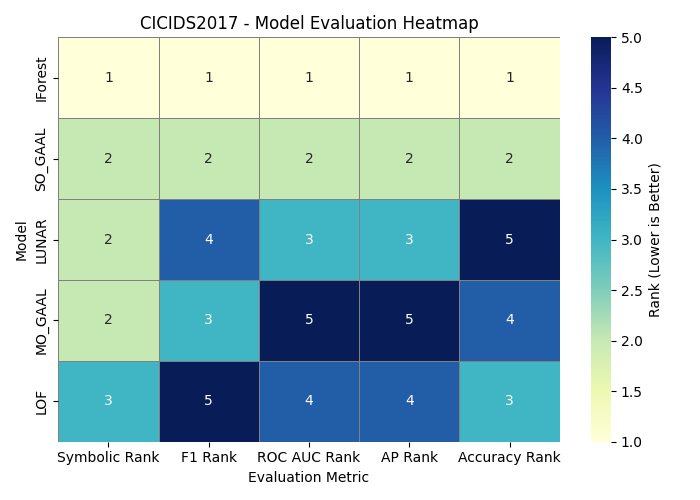

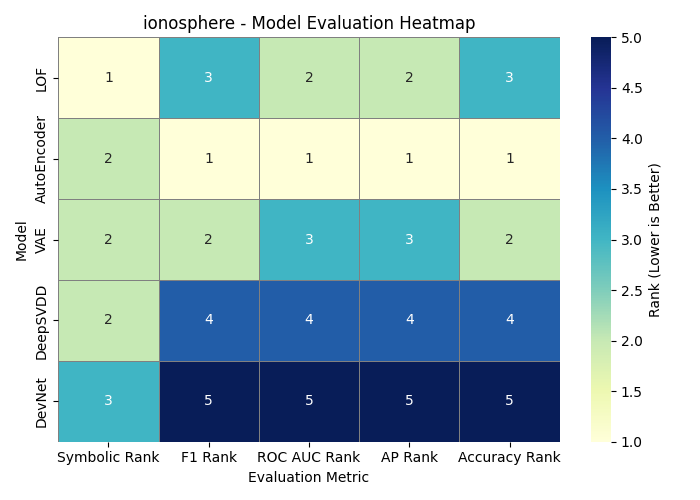

In [50]:
#generate_and_save_all_heatmaps(display_datasets=datasets_to_run)  #saves all trained datasets and also displays all)
generate_and_save_all_heatmaps(display_datasets=["CICIDS2017", "ionosphere"])#saves far all trained datasets and inline displays for specified datasets)

---

**Functional Explanation:**

The function `generate_and_save_all_heatmaps()` automates the generation of heatmaps that **visually summarize model rankings** across multiple evaluation metrics (e.g., Symbolic Rank, ROC AUC Rank, F1 Score Rank) for each dataset that has been **trained and evaluated**.

**What This Function Does:**

* **Auto-detection of Datasets:**
  If no dataset list is provided, it scans the `*_llm_input.csv` files in the input directory to automatically identify datasets for which models have already been evaluated.

* **Loads Model Ranking Data:**
  It reads each dataset's ranking file, ensuring proper formatting by skipping the title row and removing duplicate columns.

* **Prepares Ranking Matrix:**
  Filters for columns containing ranking metrics and sets up a matrix of models vs. rank types, ensuring "Symbolic Rank" is always included and used for sorting.

* **Heatmap Generation with Seaborn:**
  A color-coded heatmap is generated for each dataset using Seaborn, visually indicating which models rank better (lower rank = better).

* **Saves Visuals to Disk:**
  Each heatmap is saved as a `.png` file in the `outputs/llm_inputs/heatmaps/` directory for further use (e.g., inclusion in reports or dashboards).

* **Notebook Visualization (Optional):**
  If `display_datasets` is specified, it will also display the heatmap within the Jupyter notebook for quick visual feedback.

**Why This Matters:**

These heatmaps offer a **concise visual summary of model performance**, helping users quickly identify top-performing models across symbolic and empirical evaluation dimensions. This supports **transparent model selection** and effective communication of results in the AutoModelSelector workflow.

- Color gradients intuitively show model performance.
- smarter sorting logic :
  - primary sorting by Symbolic Rank
  - If multiple models have the same Symbolic Rank, then use Eval Rank (ROC AUC), Eval Rank (Accuracy), etc., as tie-breakers.
  - Models with the best overall performance (e.g., lowest ranks across all metrics) are shown at the top

**Display Formatted Model Evaluation Tables for Selected Datasets**
- This is for display in the notebook

In [51]:
def display_selected_llm_tables(datasets, table_dir="outputs/llm_inputs"):
    """
    Display formatted model evaluation tables for selected datasets from CSV files.

    Parameters:
    - datasets: list of dataset names (e.g., ["cardio", "CICIDS2017"])
    - table_dir: directory where the *_llm_input.csv files are stored
    """
    for dataset in datasets:
        file_path = os.path.join(table_dir, f"{dataset}_llm_input.csv")
        if not os.path.exists(file_path):
            print(f"[Warning] File not found: {file_path}")
            continue

        # Skip first row (title row), load table
        df = pd.read_csv(file_path, skiprows=1)

        # Remove any duplicated columns
        df = df.loc[:, ~df.columns.duplicated()]

        # Clean column names if needed
        df.columns = [col.replace("Eval Rank (", "").replace(")", "") if col.startswith("Eval Rank (") else col for col in df.columns]

        # Display heading and table
        display(Markdown(f"### {dataset} - Model Evaluation Summary"))
        display(df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]
        ))


In [52]:
# Example usage
display_selected_llm_tables(datasets=["cardio", "CICIDS2017"]) # display selected only
# display_selected_llm_tables(datasets= datasets_to_run)  # to display all datasets that were trained and evaluated

### cardio - Model Evaluation Summary

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,IForest,1,4.200000,0.920500,0.581600,0.906600,0.523700,0.513700,0.534100,1,1,1,1
1,MO_GAAL,2,3.100000,0.723600,0.280400,0.870600,0.339800,0.333300,0.346600,2,2,2,2
2,LUNAR,2,3.100000,0.629400,0.226100,0.856400,0.267400,0.262300,0.272700,3,3,3,3
3,SO_GAAL,2,3.100000,0.627100,0.223800,0.849800,0.234000,0.229500,0.238600,4,4,4,5
4,LOF,3,2.000000,0.545800,0.154300,0.852000,0.176300,0.189500,0.164800,5,5,5,4


### CICIDS2017 - Model Evaluation Summary

,Model,Symbolic Rank,Symbolic Score,ROC AUC,Average Precision,Accuracy,F1 (Minority),Precision (Minority),Recall (Minority),F1 Rank,ROC AUC Rank,AP Rank,Accuracy Rank
0,IForest,1,4.200000,0.677700,0.317400,0.803300,0.310400,0.442300,0.239100,1,1,1,1
1,SO_GAAL,2,3.100000,0.582100,0.267200,0.794800,0.280400,0.399800,0.215900,2,2,2,2
2,LUNAR,2,3.100000,0.487500,0.195800,0.759800,0.157700,0.224700,0.121500,4,3,3,5
3,MO_GAAL,2,3.100000,0.413500,0.186900,0.760400,0.159900,0.227800,0.123100,3,5,5,4
4,LOF,3,2.000000,0.460700,0.187100,0.765200,0.146400,0.223900,0.108800,5,4,4,3


**Functional Explanation:**

The function `display_selected_llm_tables()` is used to **visually display the model evaluation summaries** in tabular format for the specified datasets inside a Jupyter 
.

**Key Functionality:**

* **Input Datasets:**
  Accepts a list of dataset names (e.g., `["cardio", "CICIDS2017"]`) and searches for the corresponding `*_llm_input.csv` files.

* **Reads and Cleans Table Data:**
  Loads the CSV (ignoring the title row), removes duplicate columns, and cleans up column names (e.g., simplifying `"Eval Rank (F1 Score)"` to just `"F1 Score"`).

* **Stylized Display in Notebook:**
  Uses pandas' `style` and Jupyter's `Markdown` to neatly render the table with centered headers and cells, making it **reader-friendly and p
� **Why It's Useful:**

This function is crucial for **quick visual inspection and validation** of how different models have performed across datasets. It supports **manual review, debugging, and reporting**, especially during the comparative analysis or selection phase in the AuoModelSelector pipeline.

**Generate Well-Formatted Model Evaluation Tables in DOCX Format (Landscape Orientation)**

In [53]:
def set_landscape_orientation(doc):
    section = doc.sections[-1]
    new_width, new_height = section.page_height, section.page_width
    section.orientation = 1  # Landscape
    section.page_width = new_width
    section.page_height = new_height
    section.left_margin = Inches(0.5)
    section.right_margin = Inches(0.5)
    section.top_margin = Inches(0.5)
    section.bottom_margin = Inches(0.5)

def format_cell(cell, font_size=8, bold=False):
    for paragraph in cell.paragraphs:
        paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
        for run in paragraph.runs:
            run.font.size = Pt(font_size)
            run.bold = bold
    tcPr = cell._tc.get_or_add_tcPr()
    tcPr.append(OxmlElement('w:tcW'))

def save_llm_tables_to_docx(datasets, table_dir="outputs/llm_inputs"):
    """
    Save LLM model evaluation tables in well-formatted .docx format.
    """
    for dataset in datasets:
        csv_path = os.path.join(table_dir, f"{dataset}_llm_input.csv")
        if not os.path.exists(csv_path):
            print(f"[Warning] Missing file: {csv_path}")
            continue

        df = pd.read_csv(csv_path, skiprows=1)
        df = df.loc[:, ~df.columns.duplicated()]
        df.columns = [
            col.replace("Eval Rank (", "").replace(")", "")
            if col.startswith("Eval Rank (") else col for col in df.columns
        ]

        doc = Document()
        set_landscape_orientation(doc)

        # Centered heading
        heading = doc.add_heading(f"{dataset} - Model Evaluation Summary", level=1)
        heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

        # Centered paragraph
        para = doc.add_paragraph("This table summarizes the performance of the top symbolic models.")
        para.alignment = WD_ALIGN_PARAGRAPH.CENTER

        table = doc.add_table(rows=1, cols=len(df.columns))
        table.style = 'Table Grid'
        table.alignment = WD_TABLE_ALIGNMENT.CENTER

        # Header row (bold and centered)
        hdr_cells = table.rows[0].cells
        for i, col in enumerate(df.columns):
            hdr_cells[i].text = str(col)
            format_cell(hdr_cells[i], font_size=8, bold=True)

        # Data rows (centered, non-bold)
        for _, row in df.iterrows():
            row_cells = table.add_row().cells
            for i, val in enumerate(row):
                row_cells[i].text = str(val)
                format_cell(row_cells[i], font_size=8, bold=False)

        save_path = os.path.join(table_dir, f"{dataset}_llm_eval.docx")
        doc.save(save_path)
        print(f" Saved final formatted DOCX for {dataset}: {save_path}")


In [54]:
# Save LLM-friendly docx tables automatically
save_llm_tables_to_docx(datasets_to_run)

 Saved final formatted DOCX for cardio: outputs/llm_inputs\cardio_llm_eval.docx
 Saved final formatted DOCX for satellite: outputs/llm_inputs\satellite_llm_eval.docx
 Saved final formatted DOCX for ionosphere: outputs/llm_inputs\ionosphere_llm_eval.docx
 Saved final formatted DOCX for CICIDS2017: outputs/llm_inputs\CICIDS2017_llm_eval.docx


---

**Functional Explanation:**

The function `save_llm_tables_to_docx()` generates a **well-structured Word document (`.docx`)** containing model evaluation tables for each dataset processed by the AutoModelSelector pipeline.

**What It Does:**

* **Reads the Evaluation CSV**
  Loads the evaluation results from `<dataset>_llm_input.csv` (skipping metadata row and removing duplicate columns).

* **Cleans Column Names**
  Simplifies verbose column headers (like `"Eval Rank (F1 Score)"`) to readable formats for final reporting.

* **Creates a DOCX Report**
  For each dataset:

  * Inserts a centered heading and description.
  * Creates a table using the `Table Grid` style with all model metrics and rankings.
  * Applies consistent formatting (center-aligned, font size 8) to all cells.

* **Sets Landscape Orientation**
  The helper function `set_landscape_orientation()` ensures the document is wide enough to accommodate all columns without wrapping or overflow.

* **Formats Cells**
  The helper `format_cell()` applies text alignment and font styling (bold for headers, regular for rows).

* **Saves as DOCX**
  Output file is saved as `<dataset>_llm_eval.docx` in the specified directory.

This function is essential for generating **publication-quality, print-ready evaluation summaries**, suitable for inclusion in project reports, presentations, or documentation. The landscape layout and compact formatting make it ideal for wide tables with multiple metrics.

**Save Model Evaluation Table as PNG Image for Final Presentation**

In [55]:
def wrap_column_labels(labels, force_wrap_cols=None, max_width=12):
    wrapped = []
    for label in labels:
        if force_wrap_cols and label in force_wrap_cols:
            wrapped.append('\n'.join(textwrap.wrap(label, width=6)))
        elif len(label) > max_width:
            wrapped.append('\n'.join(textwrap.wrap(label, width=max_width)))
        else:
            wrapped.append(label)
    return wrapped

def save_llm_table_as_png(dataset_name, csv_path, output_path="outputs/llm_inputs"):
    # Load data
    df = pd.read_csv(csv_path, skiprows=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.columns = [col.replace("Eval Rank (", "").replace(")", "") if col.startswith("Eval Rank (") else col for col in df.columns]

    # Columns to force wrap (rank columns)
    rank_cols = ['F1 Rank', 'ROC AUC Rank', 'AP Rank', 'Accuracy Rank']
    wrapped_cols = wrap_column_labels(df.columns.tolist(), force_wrap_cols=rank_cols)

    # Figure size
    num_rows, num_cols = df.shape
    fig_width = max(10, num_cols * 0.9)
    fig_height = 1.6 + num_rows * 0.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')

    # # Title and subtitle (higher placement)
    # fig.suptitle(f"{dataset_name} - Model Evaluation Summary", fontsize=14, fontweight='bold', y=1.12)
    # fig.text(0.5, 1.08, "This table summarizes the performance of the top symbolic models.",
    #          fontsize=10, ha='center')
    
    # Title and subtitle (higher placement)
    fig.suptitle(f"{dataset_name} - Model Evaluation Summary", fontsize=12, fontweight='bold', y=1.12)
    
            
    # Table
    table = ax.table(cellText=df.values,
                     colLabels=wrapped_cols,
                     cellLoc='center',
                     colLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    for (row, col), cell in table.get_celld().items():
        cell.set_height(0.25)
        cell.set_linewidth(0.8)
        if row == 0:
            cell.set_fontsize(8)  # smaller for header
            cell.set_text_props(weight='bold')
        else:
            if isinstance(df.columns[col], str) and not df.iloc[0, col].__class__ in [int, float]:
                cell.set_fontsize(7)  # for text cols
            else:
                cell.set_fontsize(9)  # for numeric values

    # Save
    os.makedirs(output_path, exist_ok=True)
    img_path = os.path.join(output_path, f"{dataset_name}_llm_eval.png")
    plt.savefig(img_path, bbox_inches='tight', dpi=300)
    plt.close()

    print(f" Final PNG saved: {img_path}")


In [57]:
# For selected dataset Model Evaluation Table as png
# save_llm_table_as_png(
#     dataset_name="CICIDS2017",
#     csv_path="outputs/llm_inputs/CICIDS2017_llm_input.csv"
# )

---

**Functional Explanation:**

This pair of functions (`wrap_column_labels()` and `save_llm_table_as_png()`) creates a **clean, image-based version** of the generated model evaluation table and saves it as a **high-resolution `.png` file** for presentations or non-editable reporting formats.

---

**`wrap_column_labels(labels, force_wrap_cols=None, max_width=12)`**

* **Purpose**: Ensures long column labels (especially ranking metrics) are **wrapped onto multiple lines**, improving table readability and preventing overlap or overflow.

  * Wraps labels in `force_wrap_cols` more aggressively (fixed width = 6).
  * For all others, wraps if they exceed `max_width` characters.

---

**`save_llm_table_as_png(dataset_name, csv_path, output_path)`**

* **Purpose**:

  * Reads the evaluation CSV.
  * Formats the data as a matplotlib table with wrapped headers.
  * Exports a **publication-ready `.png` image** of the table.

* **Key Features**:

  * Skips metadata row and deduplicates columns.
  * Wraps specific column headers like `"F1 Rank"`, `"ROC AUC Rank"`, etc.
  * Dynamically adjusts figure size based on number of rows and columns.
  * Custom font size and alignment per cell.
  * Bolded headers, differentiated font sizing for text vs numeric content.

* **Output**:
  Saved at:

  ```
  outputs/llm_inputs/<dataset_name>_llm_eval.png
  ```
---

**Use Case:**

This is particularly useful for:

* Inserting visuals in PDF reports where embedding a `.docx` is not practical.
* Ensuring compatibility across systems (no font/style mismatch).
* Providing a **frozen snapshot** of evaluation results to ensure reproducibility and version control.

---

**Save Model Evaluation Table as PNG Image for Final Presentation for Multiple Datasets**

In [58]:
def generate_llm_tables_for_multiple_datasets(dataset_names, base_csv_dir="outputs/llm_inputs", output_path="outputs/llm_inputs"):
    """
    Generate LLM evaluation table PNGs for multiple datasets.
    
    Parameters:
    - dataset_names (list): List of dataset names (e.g., ["CICIDS2017", "arrhythmia"])
    - base_csv_dir (str): Directory where dataset CSV files are located
    - output_path (str): Directory to save PNG files
    """
    for dataset in dataset_names:
        csv_path = os.path.join(base_csv_dir, f"{dataset}_llm_input.csv")
        if os.path.exists(csv_path):
            try:
                print(f" Processing {dataset}...")
                save_llm_table_as_png(dataset, csv_path, output_path=output_path)
            except Exception as e:
                print(f" Failed to process {dataset}: {e}")
        else:
            print(f" CSV not found for {dataset}: {csv_path}")


In [60]:
# # For processing in batch the selected datasets Model Evaluation Table as PNG
# dataset_list = [ "ionosphere", "cardio"]
# generate_llm_tables_for_multiple_datasets(dataset_list)

In [61]:
# For processing all datasets trained and evaluated
dataset_list = datasets_to_run
generate_llm_tables_for_multiple_datasets(dataset_list)

 Processing cardio...
 Final PNG saved: outputs/llm_inputs\cardio_llm_eval.png
 Processing satellite...
 Final PNG saved: outputs/llm_inputs\satellite_llm_eval.png
 Processing ionosphere...
 Final PNG saved: outputs/llm_inputs\ionosphere_llm_eval.png
 Processing CICIDS2017...
 Final PNG saved: outputs/llm_inputs\CICIDS2017_llm_eval.png


In [62]:
print(os.listdir("outputs/llm_inputs"))

['basic_eda_steps.json', 'cardio_llm_eval.docx', 'cardio_llm_eval.png', 'cardio_llm_input.csv', 'cardio_llm_input_meta.json', 'cardio_tags.json', 'CICIDS2017_llm_eval.docx', 'CICIDS2017_llm_eval.png', 'CICIDS2017_llm_input.csv', 'CICIDS2017_llm_input_meta.json', 'CICIDS2017_tags.json', 'EDA', 'graphs', 'heatmaps', 'ionosphere_llm_eval.docx', 'ionosphere_llm_eval.png', 'ionosphere_llm_input.csv', 'ionosphere_llm_input_meta.json', 'ionosphere_tags.json', 'model_tag_knowledge.json', 'model_tag_knowledge_meta.json', 'prompt_template.json', 'satellite_llm_eval.docx', 'satellite_llm_eval.png', 'satellite_llm_input.csv', 'satellite_llm_input_meta.json', 'satellite_tags.json', 'symbolic_score_formula.json', 'tag_definitions.json', 'tag_definitions_meta.json', 'tag_weights.json', 'tag_weights_meta.json', '_aggregate_llm_input.csv']


**Model Ranking Grouped per Metric**

In [63]:
def plot_model_ranking_bars_flex(datasets, input_dir="outputs/llm_inputs", save=True):
    """
    Plot symbolic and metric-based rank comparisons for one or more datasets.
    
    Parameters:
    - datasets: list of dataset names
    - input_dir: path to CSV files
    - save: if True, saves plots to outputs/llm_inputs/graphs/, else shows inline
    """
    os.makedirs(os.path.join(input_dir, "graphs"), exist_ok=True)
    rank_columns = ["Symbolic Rank", "ROC AUC Rank", "F1 Rank", "AP Rank", "Accuracy Rank"]
    pastel_colors = ["#A6CEE3", "#B2DF8A", "#FDBF6F", "#FFCC99", "#CAB2D6"]

    for dataset_name in datasets:
        csv_path = os.path.join(input_dir, f"{dataset_name}_llm_input.csv")
        if not os.path.exists(csv_path):
            print(f"[Warning] File not found: {csv_path}")
            continue

        # Load and prepare data
        df = pd.read_csv(csv_path, skiprows=1)
        df = df.loc[:, ~df.columns.duplicated()]
        df_sorted = df.sort_values(by="Symbolic Rank").reset_index(drop=True)
        model_names = df_sorted["Model"]

        # Plot setup
        fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=True)
        for i, (rank_col, ax) in enumerate(zip(rank_columns, axes)):
            sns.barplot(
                x=rank_col,
                y=model_names,
                data=df_sorted,
                ax=ax,
                color=pastel_colors[i],
                orient='h'
            )

            # Format
            ax.set_yticklabels(model_names, fontweight='bold')
            for idx, val in enumerate(df_sorted[rank_col]):
                ax.text(
                    val - 0.15,
                    idx,
                    str(int(val)),
                    color='black',
                    va='center',
                    ha='right',
                    fontsize=11,
                    fontweight='bold'
                )
            ax.set_title(rank_col, fontweight='bold')
            ax.set_xlabel("Rank", fontweight='bold')
            ax.set_ylabel("")

        axes[0].set_ylabel("Model", fontweight='bold')
        fig.suptitle(f"{dataset_name} - Model Ranking Grouped per Metric", fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save:
            graph_path = os.path.join(input_dir, "graphs", f"{dataset_name}_ranking_bars_per_metric.png")
            plt.savefig(graph_path, bbox_inches='tight')
            print(f" Saved: {graph_path}")
            plt.close(fig)
        else:
            plt.show()


In [64]:
#datasets_to_run = ["cardio", "CICIDS2017", "satellite"] # if we want bar chart for selected datasets only
# Bar chart for all the datasets that were trained and evaluated
plot_model_ranking_bars_flex(datasets_to_run, save=True)

 Saved: outputs/llm_inputs\graphs\cardio_ranking_bars_per_metric.png
 Saved: outputs/llm_inputs\graphs\satellite_ranking_bars_per_metric.png
 Saved: outputs/llm_inputs\graphs\ionosphere_ranking_bars_per_metric.png
 Saved: outputs/llm_inputs\graphs\CICIDS2017_ranking_bars_per_metric.png


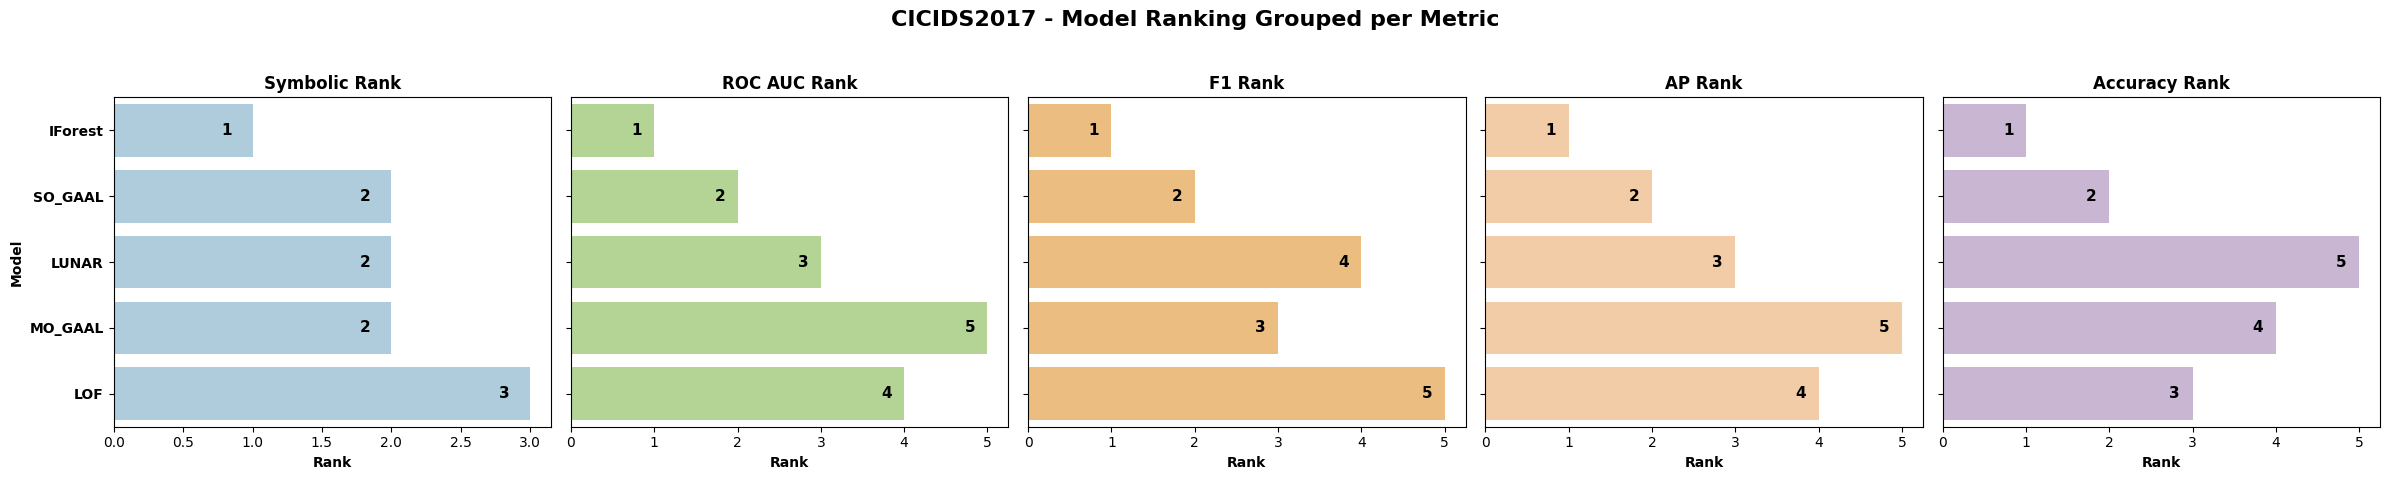

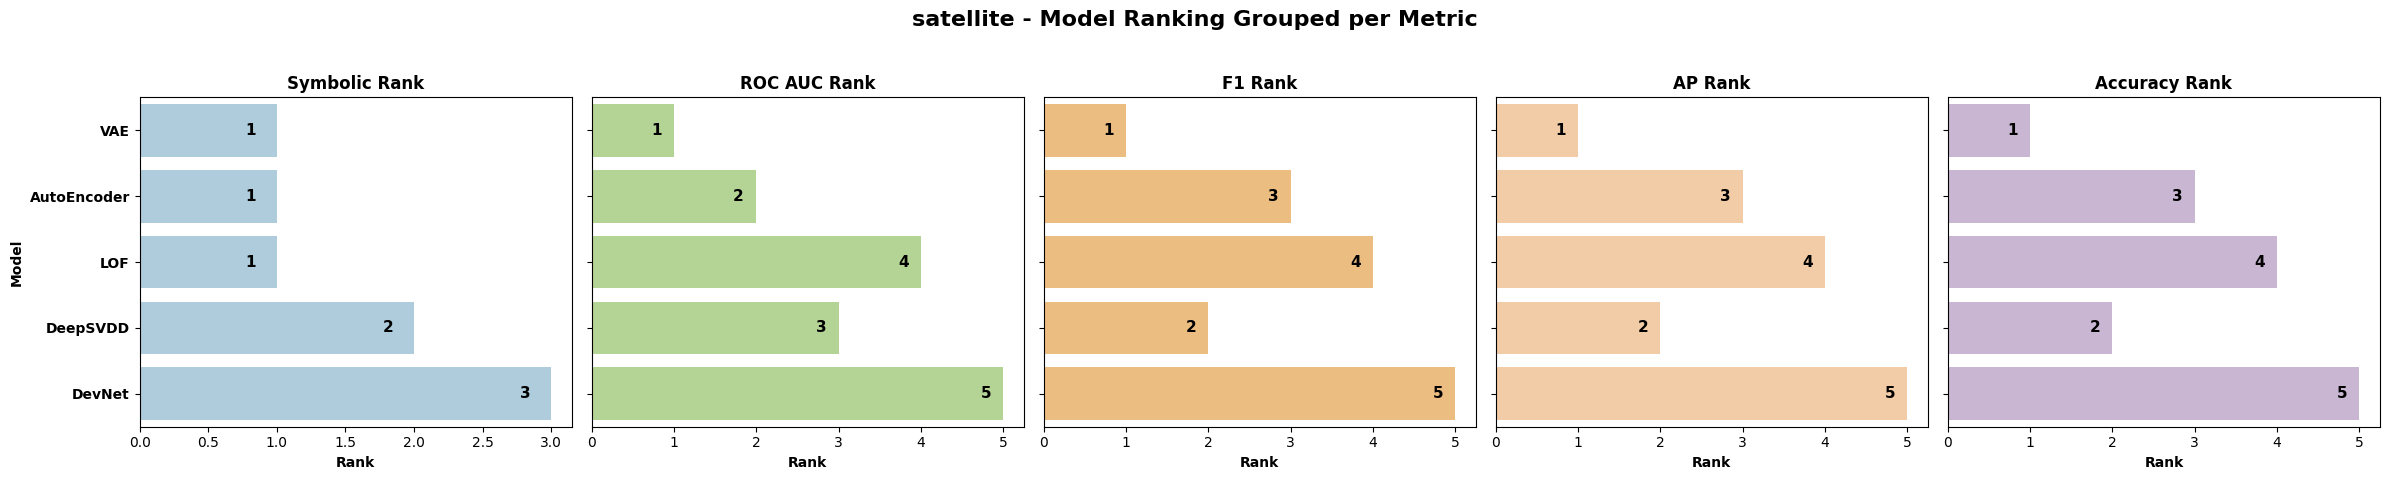

In [65]:
# Bar chart for the dataset cardio and satellite without savaing
plot_model_ranking_bars_flex(["CICIDS2017", "satellite"], save=False)

**Model performance rankings across different metrics**
- 1. Five Horizontal Bar Charts
- 2. Grouped Vertical Bar Chart

The above two graphs differ in layout, clarity of comparison, and use case. 

---

**Graph 1: Five Horizontal Bar Charts**

**Title:** `CICIDS2017 - Model Ranking Grouped per Ranking

**Description:**

* Contains **five separate horizontal bar charts**, one for each ranking metric:

  * Symbolic Rank
  * ROC AUC Rank
  * F1 Rank
  * AP Rank
  * Accuracy Rank
* Each bar represents **a model's rank** in that specific metric.
* Each panel highlights the performance of all models on a specific metric, such as Symbolic Rank, ROC AUC Rank, F1 Rank, etc.
* Models are arranged on the y-axis (rows stay aligned across all plots).
* Rank values are shown **inside the bars**.

**Strengths**:

* Clean and easy to read per metric.
* Each ranking scale is visible.
* Ideal when we want to **emphasize each metric independently**.

**Limitations**:

* Hard to compare **across metrics for a single model** (scanning across subplots needed).
* Takes more horizontal space.

---

**Graph 2: Grouped Vertical Bar Chart**

**Description:**

* A **grouped vertical bar chart**:

  * **Each group** represents a model.
  * **Each bar in a group** shows the model’s rank in a metric.
* Makes it easy to **compare multiple metrics for the same model** at once.

**Strengths**:

* Better for **inter-model comparison across all metrics**.
* Compact and efficient to show **overall pattern** in rankings.
* Helpful to identify models that consistently perform well or poorly across metrics.

**Limitations**:

* Slightly harder to focus on one metric across all models compared to separate plots.
* If too many models or metrics, it can get cluttered.

---

**Summary Comparison Table:**

| Feature           | Graph 1: Bar per Metric (Horizontal)       | Graph 2: Grouped Bars (Vertical)        |
| ----------------- | ------------------------------------------ | --------------------------------------- |
| Visual Style      | 5 separate horizontal bar plots            | Single grouped vertical bar plot        |
| Emphasizes        | Each metric’s ranking distribution         | Each model’s performance across metrics |
| Comparison Focus  | Per metric (metric-centric)                | Per model (model-centric)               |
| Ideal For         | Highlighting importance of a single metric | Overview of model stability/performance |
| Naming            | `_ranking_bars_per_metric.png`             | `_model_wise_multi_metric_rankings.png` |

---

**Model-Wise Multi-Metric Rankings**

In [66]:
def plot_grouped_ranking_bars_for_datasets(
    datasets_to_run, 
    input_dir="outputs/llm_inputs", 
    output_dir="outputs/llm_inputs/graphs", 
    use_pastel=True, 
    save_plots=True, 
    display_plots=True
):
    os.makedirs(output_dir, exist_ok=True)

    pastel_colors = ["#A6CEE3", "#B2DF8A", "#FDBF6F", "#CAB2D6", "#FFB3B3"]
    dark_colors   = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#d62728"]

    chosen_palette = pastel_colors if use_pastel else dark_colors

    for dataset_name in datasets_to_run:
        try:
            # Load data
            input_path = os.path.join(input_dir, f"{dataset_name}_llm_input.csv")
            df = pd.read_csv(input_path, skiprows=1)
            df = df.loc[:, ~df.columns.duplicated()]

            # Compute rank columns
            df["Symbolic Rank"] = df["Symbolic Score"].rank(method="dense", ascending=False).astype(int)
            df["F1 Rank"] = df["F1 (Minority)"].rank(method="dense", ascending=False).astype(int)
            df["ROC AUC Rank"] = df["ROC AUC"].rank(method="dense", ascending=False).astype(int)
            df["AP Rank"] = df["Average Precision"].rank(method="dense", ascending=False).astype(int)
            df["Accuracy Rank"] = df["Accuracy"].rank(method="dense", ascending=False).astype(int)

            # Sort models by Symbolic Rank
            df = df.sort_values(by="Symbolic Rank")

            # Melt into long format
            melted = df.melt(
                id_vars=["Model"],
                value_vars=["Symbolic Rank", "F1 Rank", "ROC AUC Rank", "AP Rank", "Accuracy Rank"],
                var_name="Metric",
                value_name="Rank"
            )

            plt.figure(figsize=(12, 6))
            ax = sns.barplot(
                data=melted,
                x="Model",
                y="Rank",
                hue="Metric",
                palette=chosen_palette
            )

            # Annotate rank values
            for container in ax.containers:
                ax.bar_label(container, fmt="%d", label_type="edge", fontsize=9, padding=2)

            # Style settings
            ax.set_title(f"{dataset_name} - Model-Wise Multi-Metric Rankings", fontsize=14)
            ax.set_ylabel("Rank (Lower is Better)")
            ax.set_xlabel("Model")
            ax.set_ylim(0, 6)
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Save to file
            if save_plots:
                #save_path = os.path.join(output_dir, f"{dataset_name}_rank_grouped_bar.png")
                save_path = os.path.join(output_dir,  f"{dataset_name}_model_wise_multi_metric_rankings.png")

                plt.savefig(save_path)
                print(f" Saved: {save_path}")

            # Display inline
            if display_plots:
                plt.show()
            else:
                plt.close()

        except Exception as e:
            print(f" Failed for {dataset_name}: {e}")


**Model-Wise Multi-Metric Ranking for Dataset Trained and Evaluated or specified**

In [67]:
# To save the bar charts of all the datasets trained and evaluated
plot_grouped_ranking_bars_for_datasets(datasets_to_run, use_pastel=True, save_plots=True, display_plots=False)

 Saved: outputs/llm_inputs/graphs\cardio_model_wise_multi_metric_rankings.png
 Saved: outputs/llm_inputs/graphs\satellite_model_wise_multi_metric_rankings.png
 Saved: outputs/llm_inputs/graphs\ionosphere_model_wise_multi_metric_rankings.png
 Saved: outputs/llm_inputs/graphs\CICIDS2017_model_wise_multi_metric_rankings.png


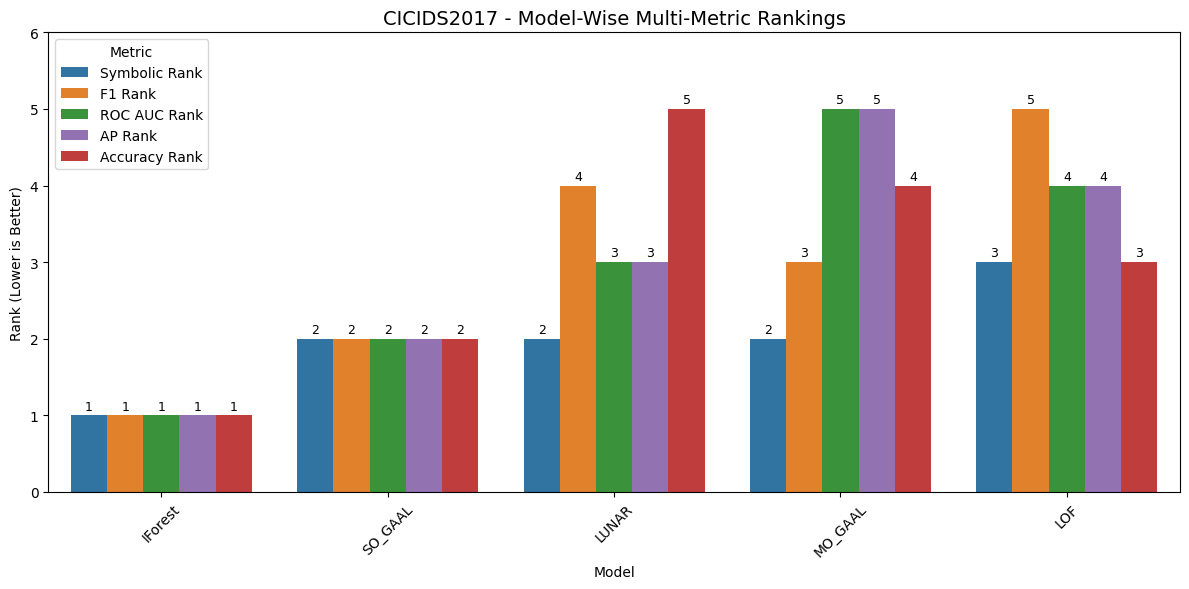

In [68]:
# To display the bar charts of the datasets selected
plot_grouped_ranking_bars_for_datasets(datasets_to_run = ["CICIDS2017"], use_pastel=False, save_plots=False, display_plots=True)

**Load OpenAI API Key Securely**

In [69]:
# Load API key from .env file or environment variable
load_dotenv()
api_key = os.getenv("API_KEY")   # Set this in your .env file as API_KEY=your_key_here
client = OpenAI(api_key=api_key)
#print(api_key)

**Functional Explanation**:
This block securely loads OpenAI API key from a `.env` file using the `python-dotenv` package. Instead of hardcoding sensitive keys into our code (which is unsafe and inflexible), the `.env` file acts as a secure external configuration.

* `load_dotenv()` loads environment variables from the `.env` file into the environment.
* `os.getenv("API_KEY")` fetches the API key named `API_KEY` from that environment.
* `client = OpenAI(api_key=api_key)` initializes the OpenAI client using the securely loaded key.

**Best Practice**: This keeps credentials secure, avoids hardcoding, and makes the codebase more portable across machines and teams.

In [70]:
# Set wkhtmltopdf path (update this if different)
wkhtmltopdf_path = r"C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe"
pdf_config = pdfkit.configuration(wkhtmltopdf=wkhtmltopdf_path)

**Configure `wkhtmltopdf` Path for PDF Generation**

**Functional Explanation**:

This block sets up the configuration needed to convert HTML content into PDF using the `pdfkit` library, which internally uses the `wkhtmltopdf` binary.

* `wkhtmltopdf_path`: Specifies the absolute path to the `wkhtmltopdf.exe` executable (used on Windows).
* `pdf_config = pdfkit.configuration(...)`: Registers this binary with `pdfkit` so that it knows where to find the rendering engine.

* Without correctly specifying the path, `pdfkit` will fail to generate PDFs, especially on Windows systems where `wkhtmltopdf` is not added to the system path by default.

**To Save LLM Prompt Template for Automated Model Advisory Reports**

In [71]:
# Re-run after kernel reset
# prompt template 
prompt_template = {
    "report_heading": "LLM-Augmented Model Selection and Advisory Report for {{dataset_name}}",
    "task": (
        
        "You are a senior data scientist reviewing the results of an automated anomaly detection pipeline. "
        "Your task is to interpret symbolic scores, classifier metrics, dataset tags, and model knowledge to generate a structured and professional report. "
        "The AutoModelAdvisor integrates symbolic reasoning, empirical validation, and LLM guidance into a unified pipeline. "
        "Use the provided artifacts under report_structure: tables , heatmaps, and chart(s) to support your analysis. "
        "DO NOT generate your own hypothetical visuals or tables."
        "Explain the model rankings in depth. "
        "Do not merely list metrics like Symbolic Score, ROC AUC, and F1 Minority. "
        "Instead, analyze what they mean, compare model trade-offs, highlight mismatches between symbolic and empirical results, "
        "and conclude which models perform better under different conditions."
    ),
    "formatting_guidelines": {
        "heading_style": "Use Markdown heading level 3 (###) for all main section titles. Do not center-align headings. Ensure left alignment.",
        "alignment": "All section headings and content must be left-aligned.",
        "section_spacing": "Use consistent spacing between sections. Begin each section on a new line.",
        "visual_placement": "All visuals and image-based summaries (table, heatmaps, plots) must be placed only in the Annexure.",
  "table_generation": "Do NOT generate markdown or ASCII-style tables in the main body of the report.",
        "font_consistency": "Use consistent font size and style throughout the report. Avoid oversized headings or body text.",
        "exclude_from_output": "Do NOT reference or list any filenames from 'developer_notes_input_file_summary' (including json/docx/png files) in the report content or Annexure. These are internal developer inputs."
    },
    "executive_summary": {
        "instruction": "Provide a concise summary of the dataset, model evaluation objectives, key model recommendations, and advisory notes.",
        "sample": (
            "Dataset used: {{dataset_name}}\n"
            "Objective: Automatically recommend the most suitable model(s) using symbolic reasoning and classifier metrics.\n"
            "Evaluation: Compared models on Symbolic Score, F1, ROC AUC, Accuracy, and AP.\n"
            "Outcome: [Top model(s) and justification]\n"
            "Advisory Note: Suggested EDA or hyperparameters improvements if applicable."
        )
    },
    "introduction": {
        "instruction": "Explain how the report is generated using symbolic reasoning, statistical profiling, and LLM augmentation.",
         "sample": (
            "This report is generated using a hybrid model selection framework that integrates symbolic reasoning, statistical profiling, "
            "and Large Language Model (LLM) augmentation. The pipeline first analyzes the dataset's characteristics — such as dimensionality, "
            "size, and imbalance — and maps them to a set of predefined symbolic tags derived from domain knowledge and metadata. These tags are "
            "then used to rank candidate anomaly detection models using a symbolic scoring mechanism. In parallel, classifier performance metrics "
            "such as F1 Score, ROC AUC, Accuracy, and Average Precision are computed. A GPT-powered advisory module interprets these inputs to "
            "deliver expert-like recommendations."
        )
        
    },
    "dataset_overview": {
        "instruction": (
            "Using metadata and tags, write a short paragraph describing the dataset characteristics and implications: sample size, feature count, anomaly ratio, data quality, skewness, kurtosis, domain etc. "
            "After the paragraph, display the assigned tags exactly in the following format on a new line:\n\n"
            "**Assigned Tags**: {{tag_summary}}\n\n"
            "Do not rephrase or reorder the tags. Use the exact list from the dataset's JSON file."             
            "Reference the diagnostic EDA and basic EDA performed using the files listed. "
            "Explain the relevance of the assigned tags to the dataset characteristics. "            
            "Use reference_files to enrich the content."
        ),
        "metadata": {
            "sample_size": "<int>",
            "n_features": "<int>",
            "imbalance_ratio": "<float>",
            "domain": "<str>",
            "tag_summary": ["<tag1>", "<tag2>", "..."]
        },
        "reference_files": [
            "outputs/llm_inputs/{{dataset_name}}_tags.json",
            "outputs/llm_inputs/EDA/{{dataset_name}}_eda_diagnostic.docx",
            "outputs/llm_inputs/basic_eda_steps.json"
        ]        
    },
    "model_evaluation_summary_analysis": {
        "instruction": (
            "Strictly Analyze (do not generate table) each model's performance based on the symbolic scores and empirical metrics provided in the reference files. "
            "DO NOT generate any tables yourself (markdown, text, or ASCII) in this section.. "
            "Refer to the Model Evaluation Summary (referenced as: 'ranking_table_img'), Model Evaluation Heatmap (referenced as: 'heatmap'), "
            "and Model-Wise Multi-Metric Rankings (referenced as: 'multi_metric'), and describe key insights from them. "
            "Do not use markdown formatting or generate any new table formatting in the output."           
            "Analyze how top models align across metrics and call out anomalies or inconsistencies. "
            "Use the following artifacts: ranking_table_img, heatmap and multi-metric."            
        ),
        "reference_files": {           
            "ranking_table_img": "outputs/llm_inputs/{{dataset_name}}_llm_eval.png",
            "heatmap": "outputs/llm_inputs/heatmaps/{{dataset_name}}_rank_heatmap.png",            
            "multi_metric": "outputs/llm_inputs/graphs/{{dataset_name}}_model_wise_multi_metric_rankings.png"
        }
    },
    "llm_recommendation_block": {
        "task": "Analyze symbolic ranks and evaluation metrics to recommend suitable models. Justify decisions based on symbolic tags, model tags and scores.",
        "comment": [
            "Use tag_summary(_tags.json), model_tag_knowledge.json and symbolic_score_formula.json for reasoning.",
            "Explain model suitability based on dataset characteristics and model characteristics.",
            "Flag unsuitable models with clear reasons.",
            "Justify selection and rejection decisions clearly.",
            "If classifier-best model is within top 3 symbolic ranks, consider it a valid recommendation and justify the usefulness of the symbolic rankings."
        ],
        "next_steps": [
            "Summarize top 1–2 models recommended.",
            "Present concise pros and cons of each."
        ],
        "report_structure": [
            "Header: LLM-Informed Recommendation and Justification",
            "Section A: Recommended Model(s) with Explanation",
            "Section B: Rejected/Unsuitable Models with Rationale"
        ]
    },
    "llm_advisory_block": {
        "task": (
            "Analyze diagnostic EDA results and basic EDA steps and symbolic traits to recommend preprocessing and tuning strategies. "
            "Bridge empirical findings with symbolic reasoning for expert-like guidance."
        ),
        "comment": [
            "Refer to EDA diagnostics and stage 2 cleaning steps.",
            "Refer to outputs/llm_inputs/EDA/{{dataset_name}}_eda_diagnostic.docx and outputs/llm_inputs/basic_eda_steps.json.",
            "Suggest preprocessing steps like normalization, encoding, outlier removal, dimensionality reduction as needed.",
            "Suggest model-specific and data context hyperparameter tuning."
        ],
        "next_steps": [
            "List concrete preprocessing actions.",
            "List hyperparameters to tune and rationale."
        ],
        "report_structure": [
            "Header: Data Preprocessing & Optimization Recommendations",
            "Section A: Additional EDA or Preprocessing Suggestions",
            "Section B: Hyperparameter Tuning Strategies for Recommended Models"
        ]
    },
    "llm_final_block": {
        "task": "Summarize the final model recommendation and outline steps for deployment readiness. Highlight how the system served both selection and advisory roles.",
        "comment": [
            "Recap top model(s) with rationale, emphasize readiness and advisory insights.",
            "Mention limitations and list 2–3 concrete next steps like cross-validation or production testing.",
            "Reaffirm model + advisory combo as the unique value proposition."
        ],
        "report_structure": [
            "Section A: Recommended Model(s) Summary",
            "Section B: Pre-Deployment Readiness Notes",
            "Section C: Recommended Actions to Prepare for Deployment"
        ]
    },
    "annexure_block": {
        "task": (
            "Present only the visuals generated earlier, including: Model Evaluation Summary, Model Evaluation Heatmap , and Model-Wise Multi-Metric Rankings. "
            "These are placed at the end of the document as annexures and must NOT be re-analyzed or discussed in this section."
        ),
        "comment": [
            "Do not repeat analysis here. This is only for displaying images/tables referred earlier.",
            "No new insights should be introduced in this section.",
            "Use proper titles like 'Model Evaluation Table', 'Model Evaluation Heatmap' and Model-Wise Multi-Metric Rankings."
        ],
        "report_structure": [
            "Section: Annexure",
            "{{summary_doc}}",
            "{{heatmap}}",
            "{{multi_metric}}"
        ]
    }, 
    "developer_notes_input_file_summary": {
        "note": "These files are used by the LLM for grounding but must NOT appear in the output report.",
        "static": [
            "basic_eda_steps.json",
            "tag_definitions.json",
            "tag_definitions_meta.json",
            "model_tag_knowledge.json",
            "model_tag_knowledge_meta.json",
            "tag_weights.json",
            "tag_weights_meta.json",
            "symbolic_score_formula.json"
        ],
        "dynamic": [
            "<dataset>_tags.json",
            "<dataset>_llm_input.csv",
            "<dataset>_llm_input_meta.json",
            "<dataset>_eda_diagnostic.docx",
            "<dataset>_llm_eval.docx",
            "<dataset>_llm_eval.png",
            "<dataset>_rank_heatmap.png",
            "<dataset>_ranking_bars_per_metric.png",
            "<dataset>_model_wise_multi_metric_rankings.png"
  ]
},
    "report_structure": [
        "LLM-Augmented Model Selection and Advisory Report for {{dataset_name}}",
        "1. Executive Summary:",
        "2. Introduction: Methodology Behind the Recommendation",
        "3. Dataset Overview and Key Characteristics",
        "4. Symbolic Scoring vs. Empirical Evaluation: A Comparative Analysis",
        "5. Model Ranking Summary Analysis",
        "6. Visual Insights: Heatmap and Grouped Bar Plots Analysis",
        "7. LLM-Informed Recommendation and Justification",
        "8. Data Preprocessing & Optimization Recommendations ",
        "9. Hyperparameter Tuning and Guidance for Top Models",
        "10. Final Recommendation and Deployment Readiness",       
        "11. Annexure"       
    ]
}

# Save the refined version
save_path = "outputs/llm_inputs/prompt_template.json"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(prompt_template, f, indent=4)

save_path  # Confirm the save location to user

'outputs/llm_inputs/prompt_template.json'

---

**Functional Explanation**:

This block defines and **saves a comprehensive prompt template** that guides the behavior of a Large Language Model (LLM), such as GPT-4, to generate professional, data-driven reports for anomaly detection model selection. The output report is *not just descriptive* but *analytical*, simulating the depth of review by a senior data scientist.

---

**Design Objective:**

The prompt template is structured to support a **hybrid model selection and recommendation framework**, which integrates:

1. **Symbolic Reasoning**

   * Based on metadata and domain-specific tags assigned to the dataset.
   * Uses symbolic rules and tag-weight logic to score models before training.

2. **Empirical Evaluation**

   * Uses metrics like ROC AUC, F1 (Minority class), Accuracy, and AP from trained models.

3. **LLM-Augmented Decision-Making**

   * The GPT model interprets symbolic vs. empirical scores, compares model trade-offs, and offers:

     * Model recommendations
     * Data preprocessing suggestions
     * Hyperparameter tuning strategies
     * Final deployment readiness advice

---

#**The Prompt Template Contains:**

**`report_heading`**

Generates a consistent heading for each report.

** `task`**

Clearly defines the role of the LLM as a senior data scientist conducting a full review.

**`formatting_guidelines`**

Dictates layout and styling (e.g., no Markdown tables, images only in Annexure).

**`executive_summary`, `introduction`, `dataset_overview`, etc.**

Each section has:

* A clear instruction to the LLM
* A sample (optional)
* Specific reference files it should consult (e.g., diagnostic EDA `.docx`, symbolic tags `.json`)

**`model_evaluation_summary_analysis`**

Directs the LLM to analyze charts and visuals **without generating new tables**. References visual assets like:

* Model Evaluation Table PNG
* Heatmap
* Grouped Rankings Chart

**`llm_recommendation_block`**

Core of symbolic + empirical fusion:

* Uses tags, scores, model metadata to justify model picks
* Highlights rejected models with reasons

**`llm_advisory_block`**

Gives EDA-driven advice, bridging:

* Dataset traits
* Symbolic tags
* Hyperparameter suggestions

**`llm_final_block`**

Wraps up model selection, readiness notes, and next steps.

**`annexure_block`**

Ensures all visuals used in analysis are included at the end, with **no additional commentary**.

**`developer_notes_input_file_summary`**

Lists files used internally to *ground the LLM’s responses* but that **must never be referenced** in the final report.

**`report_structure`**

Defines **final section layout** for consistency across all dataset reports.

---

**Save Logic:**

The template is saved to:

```
outputs/llm_inputs/prompt_template.json
```

This JSON will later be loaded and passed into the LLM as input to drive consistent, insightful, and well-structured report generation.

**Efficient Static File Caching for LLM-Driven Reports**

In [72]:
def init_static_file_cache(static_dir="outputs/llm_inputs"):
    """
    Efficiently load and cache all static JSON files required for symbolic model evaluation.

    Parameters:
    - static_dir (str): Directory where the static configuration JSON files are stored.

    Returns:
    - dict: A dictionary where keys are filenames and values are parsed JSON content or None if file is missing.
    """

    # List of static configuration files needed for symbolic model scoring
    static_files = [
        "basic_eda_steps.json",
        "tag_definitions.json",
        "tag_definitions_meta.json",
        "model_tag_knowledge.json",
        "model_tag_knowledge_meta.json",
        "tag_weights.json",
        "tag_weights_meta.json",
        "symbolic_score_formula.json"
    ]

    static_cache = {}

    for file in static_files:
        path = os.path.join(static_dir, file)

        if os.path.exists(path):
            # Read and cache the JSON file content
            with open(path, "r", encoding="utf-8") as f:
                static_cache[file] = json.load(f)
        else:
            # Mark missing files explicitly as None for debugging/logging
            static_cache[file] = None

    return static_cache

---

**Functional Explanation:**

**Purpose:**
This function initializes a cache by loading all essential static JSON configuration files required for the symbolic model selection and LLM-augmented reporting pipeline. These files include metadata such as tag definitions, tag weights, symbolic scoring formulas, and basic EDA steps.

**The Function does**

* Iterates through a predefined list of static files.
* Attempts to load each from disk.
* Stores their parsed content (or `None` if not found) in a dictionary.
* Returns the full cache dictionary for use in later functions.

**Key Benefit:**
By loading these static files **once into memory**, the function:

* **Avoids redundant disk reads**, which can be costly in iterative or multi-dataset evaluations.
* **Improves performance and scalability** during batch report generation or symbolic evaluations.
* **Provides a centralized and fault-tolerant reference** for all static metadata used in symbolic reasoning and LLM analysis.

---

This level of caching is especially important when generating multiple reports using a shared pipeline. 

**Safe initialization**
- This initializes the cache and populates the variable static_files_cache.

In [73]:
if 'static_files_cache' not in globals():
    static_files_cache = init_static_file_cache()

- This checks whether static_files_cache already exists in the global environment.
- If it exists it does nothing.
- If it doesn't (like after restarting the kernel or opening a fresh session), it initializes it.
- So this conditional block prevents reinitialization when we re-run parts of our notebook during a session.
- On notebook restart:
  - When we restart the kernel, all memory is cleared.
  - So static_files_cache no longer exists in globals().
  - When execution reaches this stage initialization block again, it willre-run init_static_file_cache().)


In [74]:
# Check loading status of static files
for file, content in static_files_cache.items():
    status = " Loaded" if content else " Missing"
    print(f"{file}: {status}")


basic_eda_steps.json:  Loaded
tag_definitions.json:  Loaded
tag_definitions_meta.json:  Loaded
model_tag_knowledge.json:  Loaded
model_tag_knowledge_meta.json:  Loaded
tag_weights.json:  Loaded
tag_weights_meta.json:  Loaded
symbolic_score_formula.json:  Loaded


**Memory Usage Estimation for Static File Cache**

In [75]:
# Estimate memory usage of the cache
total_size = sys.getsizeof(static_files_cache)
print(f"Approximate cache dictionary size: {total_size} bytes")

Approximate cache dictionary size: 272 bytes


In [76]:
# Optional: deeper inspection if needed
print(f"Deep memory usage: {asizeof.asizeof(static_files_cache)} bytes")

Deep memory usage: 24712 bytes


---

This block estimates how much memory the cached static configuration files are consuming.

* `sys.getsizeof()` gives a **shallow estimate** of the top-level dictionary's memory footprint (excluding nested objects).
* `asizeof.asizeof()` (from the `pympler` library) provides a **deep inspection**, recursively calculating memory used by nested elements, offering a more accurate measurement.

This is useful for performance tuning, especially when dealing with large numbers of datasets or generating reports in bulk.

**Generating the LLM-Augmented PDF Report with Embedded Insights and Visuals**

In [77]:
#  Global wkhtmltopdf config (still used for the path)
wkhtmltopdf_path = r"C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe"

def to_file_uri(path):
    return 'file:///' + os.path.abspath(path).replace('\\', '/')

def generate_llm_report_from_prompt_template(
    dataset_name,
    prompt_template_path="outputs/llm_inputs/prompt_template.json",
    static_cache=None,
    base_path="outputs/llm_inputs",
    output_dir="outputs/llm_outputs"
):
    os.makedirs(output_dir, exist_ok=True)

    #  Load template
    with open(prompt_template_path, "r", encoding="utf-8") as f:
        template = json.load(f)

    #  Load dynamic files
    dynamic_files = {
        "llm_input_data": pd.read_csv(os.path.join(base_path, f"{dataset_name}_llm_input.csv"), skiprows=1).to_dict(orient="records"),
        "llm_input_meta": json.load(open(os.path.join(base_path, f"{dataset_name}_llm_input_meta.json"))),
        "dataset_tags": json.load(open(os.path.join(base_path, f"{dataset_name}_tags.json")))
    }

    #  Prompt construction
    messages = [
        {"role": "system", "content": template["task"].replace("{{dataset_name}}", dataset_name)},
        {"role": "user", "content": json.dumps({
            "static_files": static_cache,
            "dynamic_files": dynamic_files,
            "comments": template.get("comment", ""),
            "next_steps": template.get("next_steps", []),
            "report_structure": template.get("report_structure", [])
        }, indent=2)}
    ]

    #  OpenAI call
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=0.3,
        max_tokens=2048
    )
    llm_output = response.choices[0].message.content

    #  Save Markdown
    md_path = os.path.join(output_dir, f"{dataset_name}_llm_report.md")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(llm_output)
    print(f" Markdown saved: {md_path}")

    #  Image paths
    table_img_path = os.path.join(base_path, f"{dataset_name}_llm_eval.png")
    heatmap_img_path = os.path.join(base_path, "heatmaps", f"{dataset_name}_rank_heatmap.png")
    multi_metric_img_path = os.path.join(base_path, "graphs", f"{dataset_name}_model_wise_multi_metric_rankings.png")

    #  Skip PDF generation if image missing
    missing_images = [p for p in [table_img_path, heatmap_img_path, multi_metric_img_path] if not os.path.exists(p)]
    if missing_images:
        print("❌ PDF generation skipped. Missing image files:")
        for p in missing_images:
            print(f" - {p}")
        return

    #  HTML with Markdown and embedded images
    full_html = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h2 {{ text-align: center; font-size: 20pt; }}
            img {{ display: block; margin: 20px auto; max-width: 90%; }}
        </style>
    </head>
    <body>
    {markdown2.markdown(llm_output)}
    <h2>Model Evaluation Table</h2>
    <img src="{to_file_uri(table_img_path)}" />
    <h2>Model Evaluation Heatmap</h2>
    <img src="{to_file_uri(heatmap_img_path)}" />
    <h2>Model-wise Multi-Metric Rankings</h2>
    <img src="{to_file_uri(multi_metric_img_path)}" />
    </body>
    </html>
    """

    #  Prepend CSS override
    css_block = """
    <style>
    h1, h2, h3, h4, h5, h6 {
        text-align: left !important;
    }
    </style>
    """
    full_html = css_block + full_html

    #  Save temp HTML
    temp_html_path = os.path.join(output_dir, f"{dataset_name}_temp.html")
    with open(temp_html_path, "w", encoding="utf-8") as f:
        f.write(full_html)

    #  Convert to PDF using subprocess (not pdfkit)
    pdf_path = os.path.join(output_dir, f"{dataset_name}_llm_report.pdf")
    try:
        subprocess.run(
            [wkhtmltopdf_path, "--enable-local-file-access", temp_html_path, pdf_path],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f" PDF with visuals saved: {pdf_path}")
    except subprocess.CalledProcessError as e:
        print(f" Failed to generate PDF for {dataset_name}:\n", e.stderr.decode())
        return

    #  Display in Notebook
    display(Markdown(llm_output))
    display(Markdown("### Model Evaluation Table"))
    display(Image(table_img_path))
    display(Markdown("### Evaluation Heatmap"))
    display(Image(heatmap_img_path))
    display(Markdown("### Model-wise Multi-Metric Rankings"))
    display(Image(multi_metric_img_path))


---

**Functional Explanation:**

This function `generate_llm_report_from_prompt_template()` is the **final and most crucial step** in the AutoModelAdvisor pipeline. It converts the symbolic evaluation, empirical metrics, dataset characteristics, and supporting visuals into a **professionally structured and LLM-authored report**, ultimately saved as both **Markdown (`.md`)** and **PDF (`.pdf`)**. 

---

**Highlights of What This Final Stage Does:**

1. **Loads a Rich Prompt Template (JSON):**
   The `prompt_template.json` defines:

   * Executive summary structure
   * LLM instructions (what to analyze, what not to generate)
   * Formatting rules (e.g., no ASCII tables, no file references in the main content)
   * Section-wise breakdown for consistency across all datasets

2. **Injects Dataset-Specific Dynamic Inputs:**
   From the given dataset (`dataset_name`), the following are loaded:

   * `*_llm_input.csv`: Full evaluation table of all models
   * `*_llm_input_meta.json`: Metadata like model tags, imbalance ratio
   * `*_tags.json`: Symbolic traits assigned to dataset
     These form the “grounding” for GPT’s reasoning.

3. **Combines with Cached Static Files:**
   Loaded using `init_static_file_cache()`, these static files define:

   * Symbolic tag definitions and weights
   * Model behavior under symbolic traits
   * The formula used to compute symbolic score
     The LLM now operates with **complete symbolic+empirical context**.

4. **LLM Prompt Construction & Execution:**

   * The system message provides high-level instructions.
   * The user message passes the structured input.
   * GPT-4o is used with `temperature=0.3` to ensure analytical, grounded responses.
     **This ensures the LLM behaves like a senior data scientist.**

5. **Markdown Report Generation:**

   * GPT’s output is saved to a `.md` file.
   * This acts as the **base text** for the PDF and serves as a raw audit trail.

6. **HTML Assembly with Embedded Visuals:**

   * The `.md` is converted into HTML.
   * Embedded visuals:

     * Model Evaluation Table (`*_llm_eval.png`)
     * Heatmap (`*_rank_heatmap.png`)
     * Multi-Metric Rankings (`*_model_wise_multi_metric_rankings.png`)
   * CSS overrides enforce left alignment of headings for consistency.

7. **PDF Generation via `wkhtmltopdf`:**

   * Full HTML is rendered into a high-resolution, print-ready PDF.
   * This avoids limitations of other libraries like `pdfkit` alone.
   * Ensures embedded image fidelity and consistent layout.

8. **Notebook Display (Optional):**

   * For in-notebook validation, Markdown and Images are displayed inline.

---

**This Final Step is Critical:**

| Component                             | Contribution                                                         |
| ------------------------------------- | -------------------------------------------------------------------- |
|  **LLM Advisory**                     | Extracts deep, domain-sensitive insights grounded in real metrics.   |
|  **Symbolic + Empirical Integration** | Balances domain rules with performance metrics.                      |
|  **Professional Format**              | Markdown and PDF outputs follow clean layout and writing rules.      |
|  **Visual Embedding**                 | Directs readers to heatmaps and charts that support the advisory.    |
|  **Reproducibility**                  | All dynamic and static inputs are logged and tied to report outputs. |

---

**Design Philosophy of Entire Report Generation Block:**

Starting from the `prompt_template.json` and culminating in this function:

1. **Separation of Concerns**:

   * Prompt logic, report logic, and data handling are modularized.
   * Easily extendable to multiple datasets or sections.

2. **Human-in-the-Loop Compatibility**:

   * The `.md` and `.pdf` formats allow editing, reviews, and stakeholder sharing.

3. **Scalability**:

   * By caching static inputs and standardizing dynamic input loading, it can scale across 10+ datasets.

4. **Explainability & Governance**:

   * The report is explainable with direct traceability to symbolic definitions, data traits, and metric ranks.

---

**Final Outcome:**

A structured, readable, and defensible **LLM-generated advisory report** that can be:

* Used by data scientists and domain experts alike.
* Submitted in academic or regulatory settings.
* Backed by visuals and consistent logic.

---

 Markdown saved: outputs/llm_outputs\CICIDS2017_llm_report.md
 PDF with visuals saved: outputs/llm_outputs\CICIDS2017_llm_report.pdf


### LLM-Augmented Model Selection and Advisory Report for CICIDS2017

#### 1. Executive Summary:
In the analysis of the CICIDS2017 dataset, we evaluated several anomaly detection models using both symbolic scoring and empirical metrics. The dataset is characterized by a large sample size, medium dimensionality, and an imbalanced class distribution. The symbolic scoring system, which leverages dataset tags and model strengths/weaknesses, ranked IForest as the top model, followed by SO_GAAL, LUNAR, and MO_GAAL, with LOF trailing. Empirical evaluation metrics such as ROC AUC and F1 Minority scores were used to validate these rankings.

#### 2. Introduction: Methodology Behind the Recommendation
The AutoModelAdvisor integrates symbolic reasoning with empirical validation to recommend models. Symbolic scores are computed based on dataset characteristics and model suitability, while empirical metrics provide a performance-based validation of these recommendations.

#### 3. Dataset Overview and Key Characteristics
- **Sample Size**: Large (9783 samples)
- **Dimensionality**: Medium (69 features)
- **Imbalance**: Imbalanced (anomaly ratio of 0.185)
- **Data Quality**: Clean (no missing values)
- **Skewness**: High (97.1% of features with skew > 2.0)
- **Kurtosis**: High (84.06% of features with kurtosis > 7.0)
- **Structure**: Structured data

#### 4. Symbolic Scoring vs. Empirical Evaluation: A Comparative Analysis
The symbolic scoring system ranked models based on their alignment with dataset tags. IForest scored highest due to its strengths in handling high-dimensional, high-skewness, and high-kurtosis datasets, which matched the dataset's characteristics. However, empirical metrics such as ROC AUC and F1 Minority scores are crucial for validating these symbolic rankings.

#### 5. Model Ranking Summary Analysis
- **IForest**: Symbolically ranked first with a score of 4.2, it also achieved the highest empirical ranks across ROC AUC, F1 Minority, and other metrics. This alignment suggests IForest is well-suited for the dataset.
- **SO_GAAL**: Tied symbolically with LUNAR and MO_GAAL but outperformed them empirically, particularly in ROC AUC and F1 scores, indicating better practical performance.
- **LUNAR and MO_GAAL**: Despite sharing the symbolic rank with SO_GAAL, their empirical performance was weaker, especially in F1 Minority scores, highlighting a potential mismatch between symbolic expectations and empirical outcomes.
- **LOF**: Ranked lowest both symbolically and empirically, reflecting its weaknesses with high-dimensional and highly skewed data.

#### 6. Visual Insights: Heatmap and Grouped Bar Plots Analysis
The heatmap and grouped bar plots illustrate the comparative performance of models across different metrics, reinforcing the alignment between symbolic scores and empirical results for IForest and the divergence for models like LUNAR and MO_GAAL.

#### 7. LLM-Informed Recommendation and Justification
Based on both symbolic and empirical analyses, IForest is recommended for deployment on the CICIDS2017 dataset. Its consistent top performance across metrics and alignment with dataset characteristics make it the most suitable choice.

#### 8. Data Preprocessing & Optimization Recommendations
Given the dataset's high skewness and kurtosis, consider applying transformations to reduce these effects, potentially improving model performance further.

#### 9. Hyperparameter Tuning and Guidance for Top Models
For IForest, tuning parameters such as the number of estimators and max samples could optimize performance. For SO_GAAL, adjusting the proportion of generated anomalies may enhance results.

#### 10. Final Recommendation and Deployment Readiness
IForest is ready for deployment, with SO_GAAL as a viable alternative if further empirical validation is desired. Ensure continuous monitoring and retraining as new data becomes available.

#### 11. Annexure
Includes detailed tables and charts used in the analysis, along with additional notes on dataset characteristics and model performance metrics.

### Model Evaluation Table

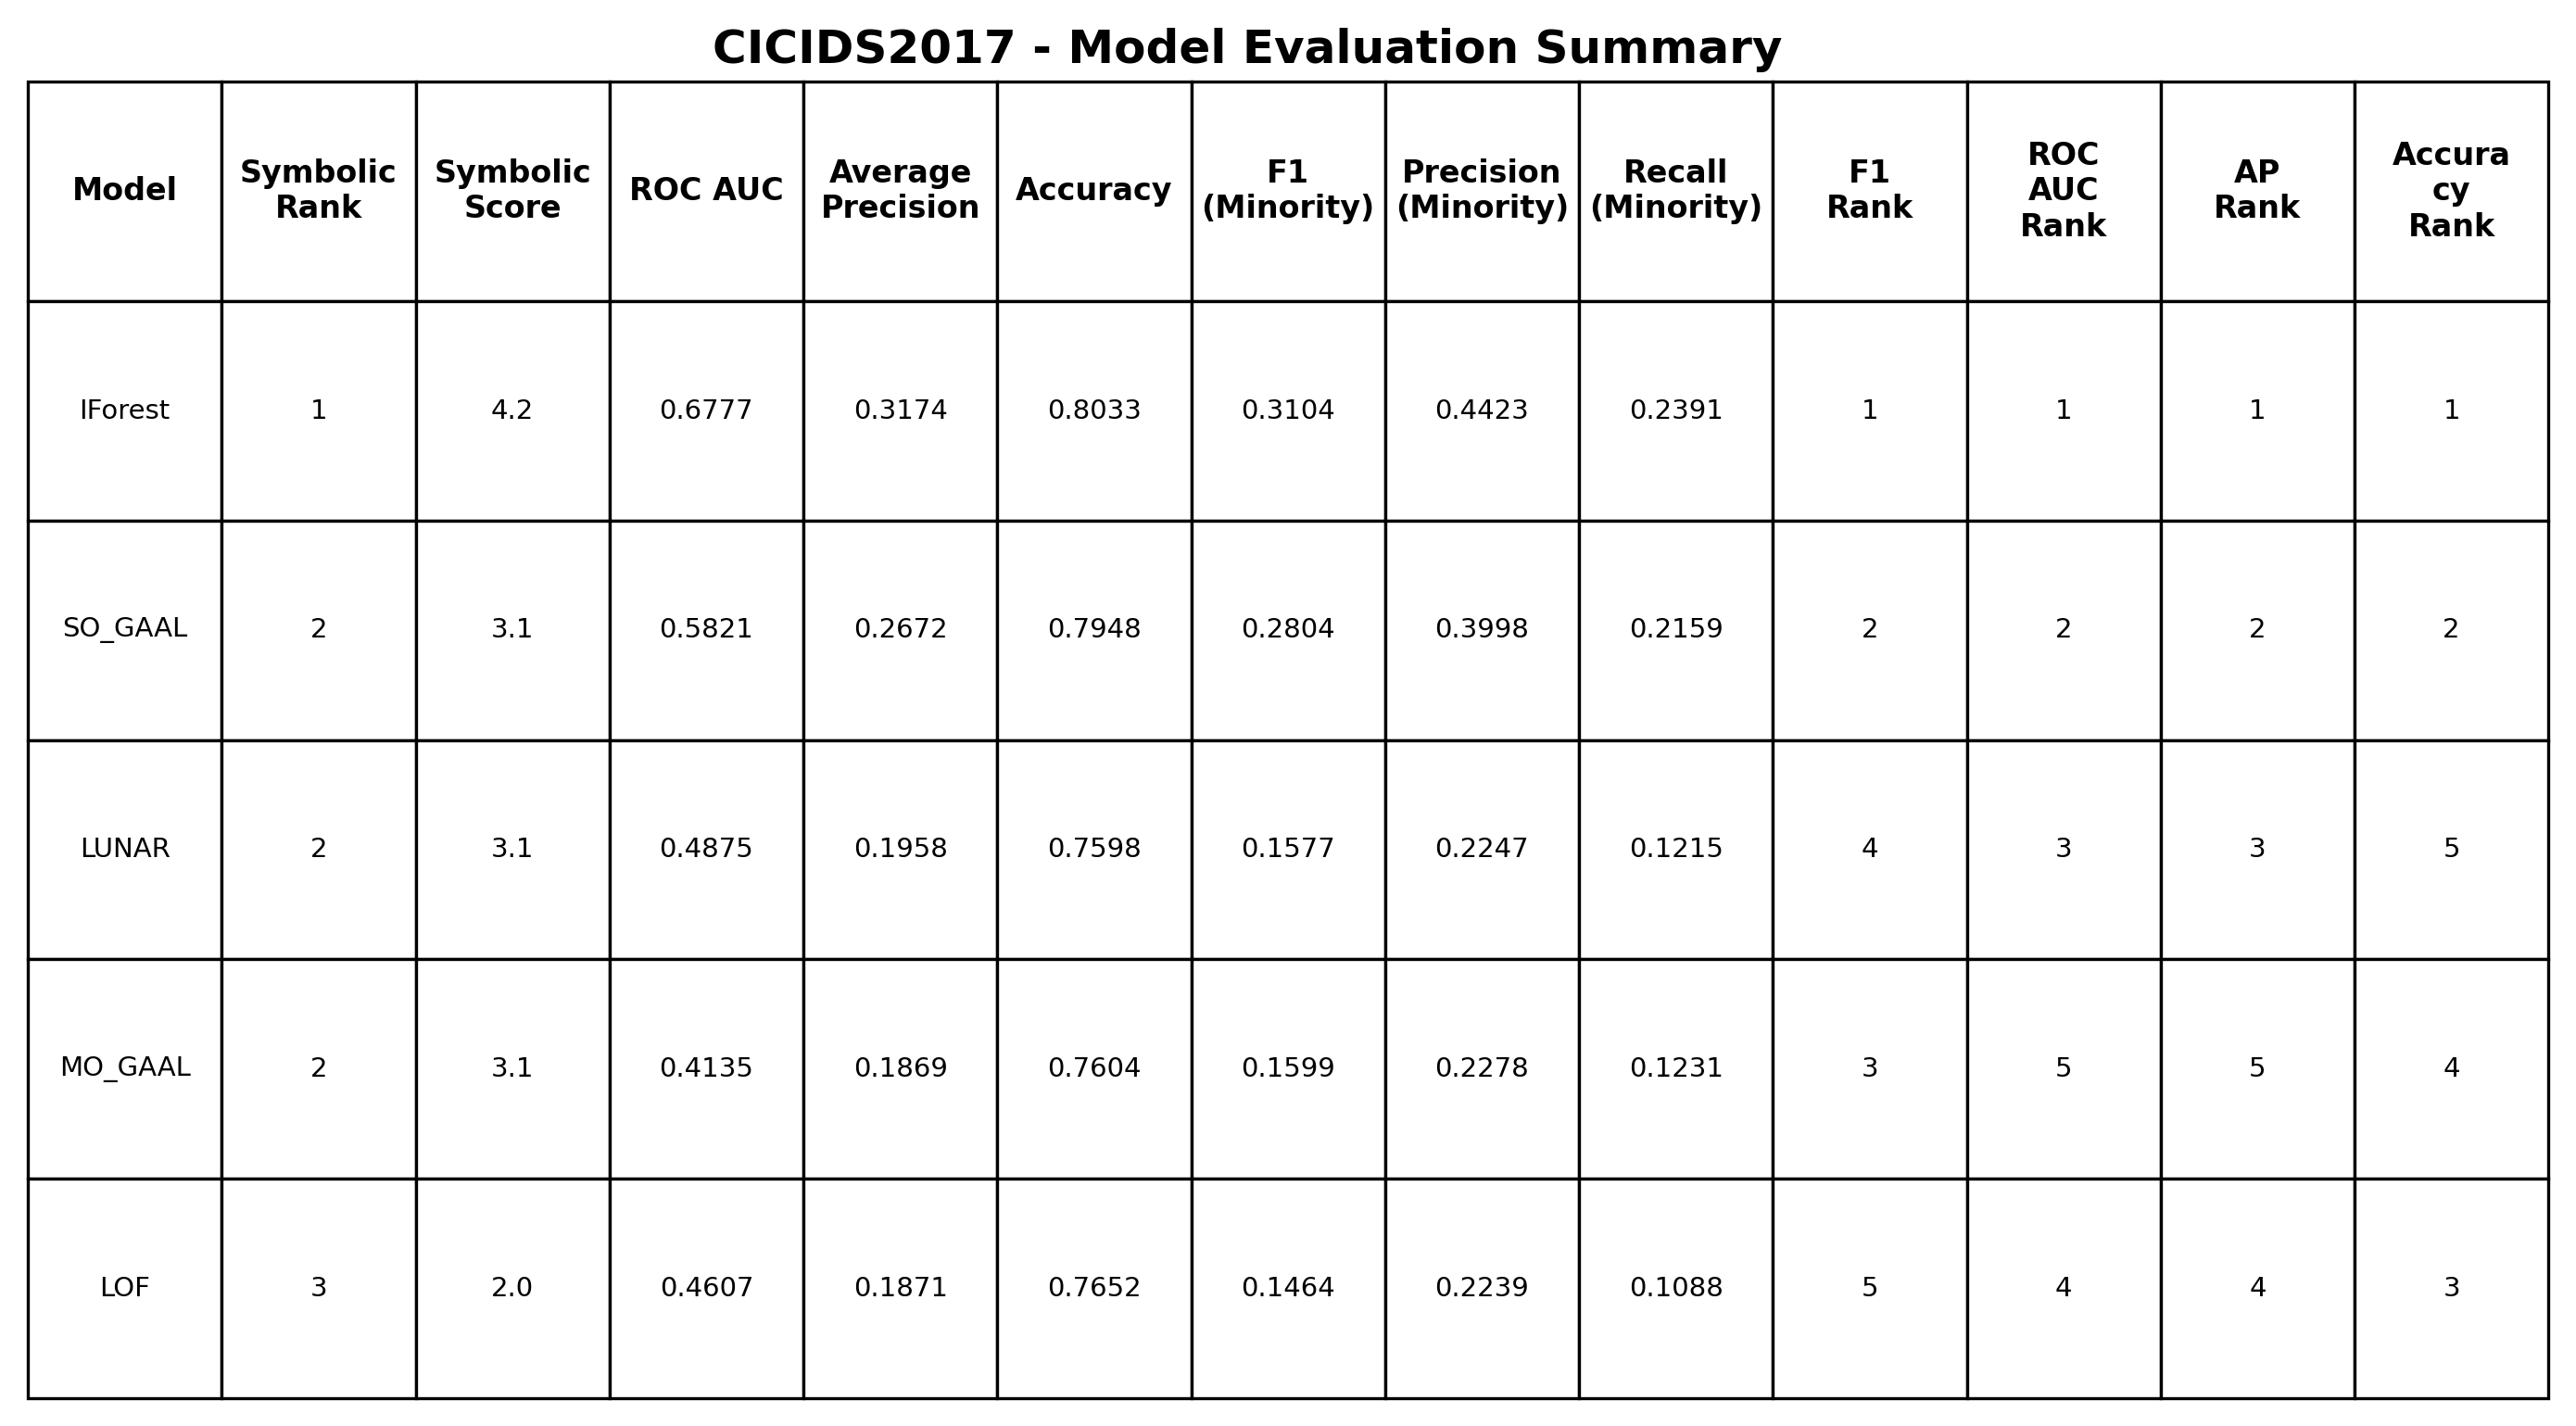

### Evaluation Heatmap

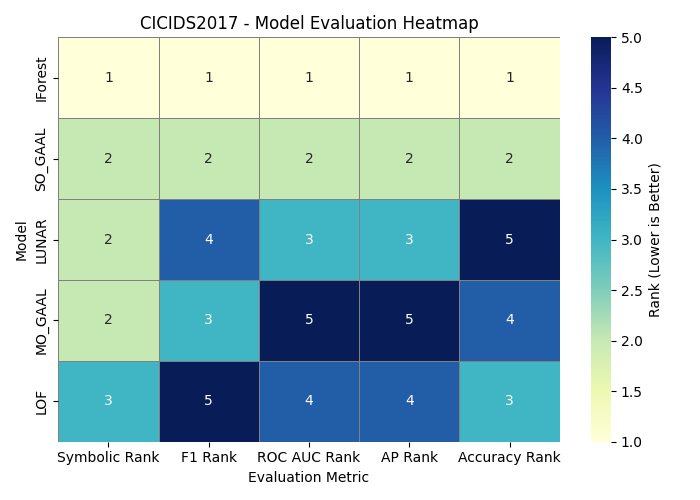

### Model-wise Multi-Metric Rankings

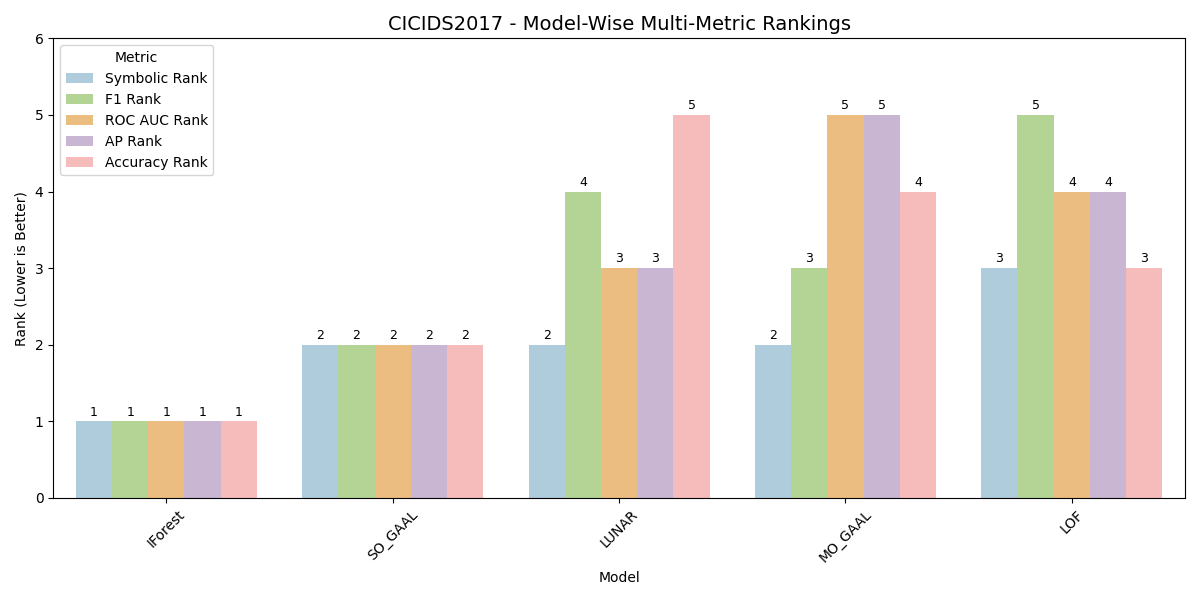

In [80]:
# To generate the report for a sepecific dataset
generate_llm_report_from_prompt_template("CICIDS2017", static_cache=static_files_cache)

**Batch Report Generation for Multiple Datasets**

In [81]:
def generate_llm_reports_for_multiple_datasets(
    dataset_names,
    prompt_template_path="outputs/llm_inputs/prompt_template.json",
    static_cache=None,
    base_path="outputs/llm_inputs",
    output_dir="outputs/llm_outputs"
):
    for name in dataset_names:
        print(f"\n Generating report for: {name}")
        try:
            generate_llm_report_from_prompt_template(
                dataset_name=name,
                prompt_template_path=prompt_template_path,
                static_cache=static_cache,
                base_path=base_path,
                output_dir=output_dir
            )
        except Exception as e:
            print(f" Failed to generate report for {name}: {e}")


 Generating report for: cardio
 Markdown saved: outputs/llm_outputs\cardio_llm_report.md
 PDF with visuals saved: outputs/llm_outputs\cardio_llm_report.pdf


## LLM-Augmented Model Selection and Advisory Report for Cardio Dataset

### 1. Executive Summary:
This report evaluates the performance of various anomaly detection models on the "cardio" dataset, characterized by medium sample size, medium dimensionality, and a significant class imbalance. The analysis integrates symbolic scoring with empirical validation metrics to provide a comprehensive understanding of model performance.

### 2. Introduction: Methodology Behind the Recommendation
The AutoModelAdvisor pipeline employs symbolic reasoning to rank models based on theoretical suitability and empirical validation to assess actual performance. This dual approach ensures robust model selection tailored to the dataset's characteristics.

### 3. Dataset Overview and Key Characteristics
The "cardio" dataset comprises 1831 samples and 21 features, with an anomaly ratio of approximately 9.6%. The dataset is clean, with no missing values, but exhibits high skewness and kurtosis, indicating potential challenges in model performance due to non-normal feature distributions.

### 4. Symbolic Scoring vs. Empirical Evaluation: A Comparative Analysis
Symbolic scores provide an initial ranking based on theoretical model suitability. However, empirical metrics such as ROC AUC, Average Precision, and F1 Minority offer insights into real-world performance, highlighting potential discrepancies between symbolic and empirical evaluations.

### 5. Model Ranking Summary Analysis
- **IForest**: Achieves the highest symbolic score (4.2) and ranks first across all empirical metrics. Its superior ROC AUC (0.9205) and F1 Minority (0.5237) indicate robust performance in detecting anomalies, making it the most reliable model for this dataset.
- **MO_GAAL**: Despite sharing the second symbolic rank with LUNAR and SO_GAAL, MO_GAAL outperforms them empirically, with a ROC AUC of 0.7236 and F1 Minority of 0.3398. This suggests a better balance between precision and recall compared to its symbolic peers.
- **LUNAR and SO_GAAL**: Both models have the same symbolic score (3.1) but differ slightly in empirical performance. LUNAR's ROC AUC (0.6294) and F1 Minority (0.2674) are marginally better than SO_GAAL's, indicating a slight edge in anomaly detection.
- **LOF**: With the lowest symbolic score (2.0) and empirical performance, LOF ranks last. Its ROC AUC (0.5458) and F1 Minority (0.1763) reflect limited effectiveness in this context.

### 6. Visual Insights: Heatmap and Grouped Bar Plots Analysis
Visual analysis of the heatmap and bar plots reveals the stark contrast in performance between IForest and other models, particularly in terms of ROC AUC and F1 Minority scores. These visuals underscore IForest's dominance and the relative underperformance of LOF.

### 7. LLM-Informed Recommendation and Justification
Given the dataset's characteristics and the empirical results, IForest is recommended for deployment due to its superior anomaly detection capabilities. Its ability to handle high skewness and kurtosis effectively aligns with the dataset's distributional challenges.

### 8. Data Preprocessing & Optimization Recommendations
To enhance model performance, consider feature scaling and transformation to address skewness and kurtosis. Additionally, exploring feature selection techniques may reduce dimensionality and improve model efficiency.

### 9. Hyperparameter Tuning and Guidance for Top Models
For IForest, tuning parameters such as the number of estimators and contamination rate may further optimize performance. For MO_GAAL, adjusting the number of generators and discriminators could enhance its anomaly detection capabilities.

### 10. Final Recommendation and Deployment Readiness
IForest is the most suitable model for deployment on the "cardio" dataset, given its consistent empirical superiority and alignment with the dataset's characteristics. Ensure thorough validation and monitoring post-deployment to maintain performance.

### 11. Annexure
Detailed tables, heatmaps, and charts supporting the analysis are included for reference.

### Model Evaluation Table

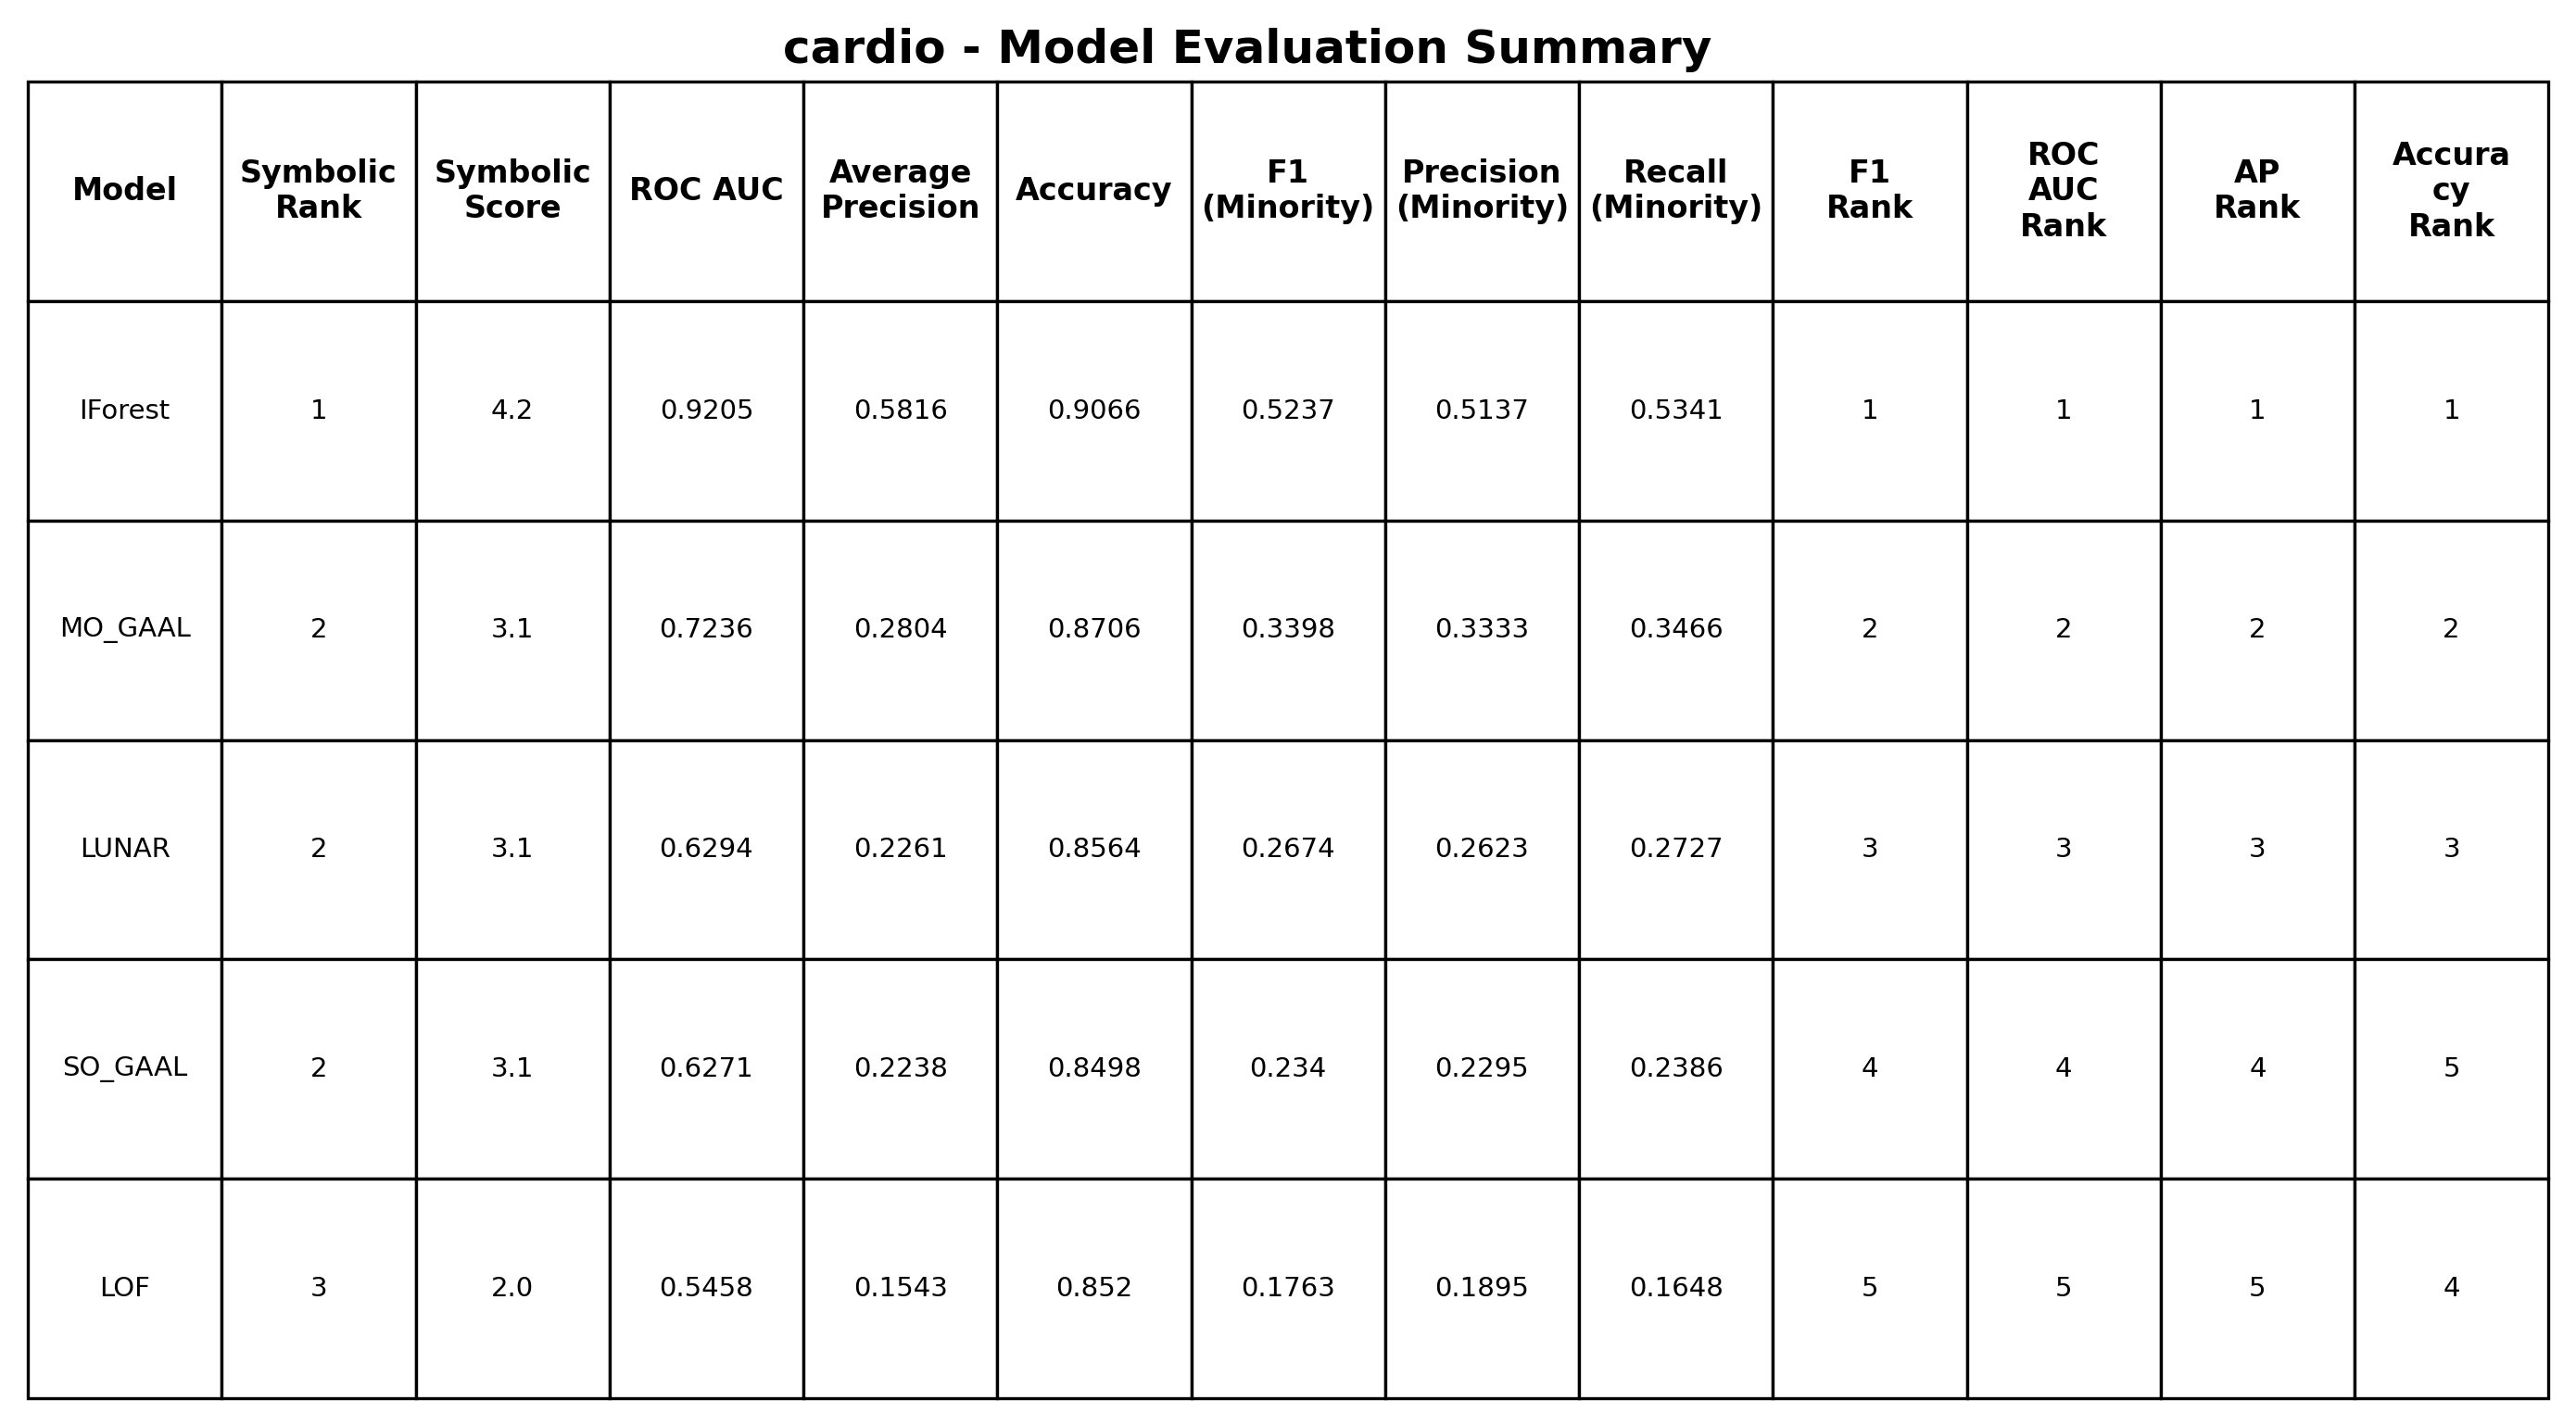

### Evaluation Heatmap

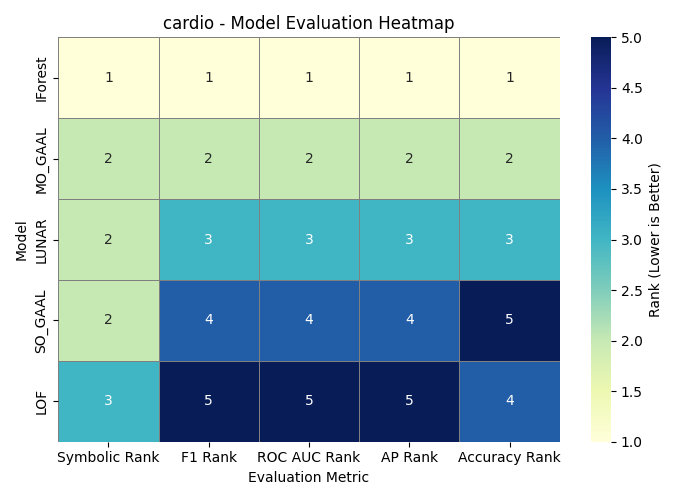

### Model-wise Multi-Metric Rankings

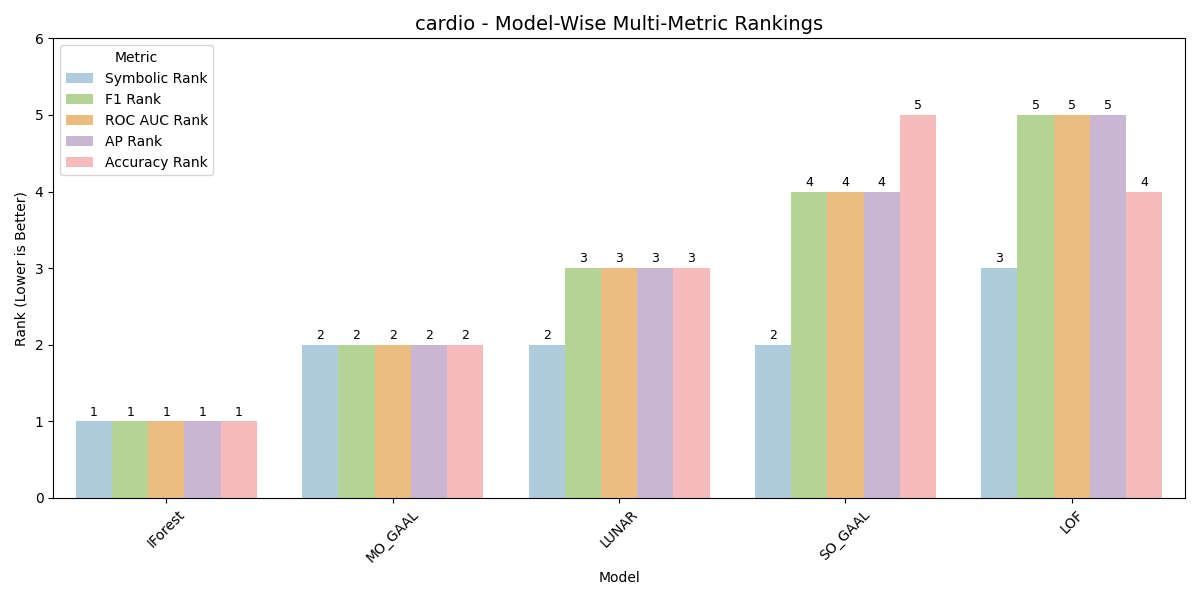


 Generating report for: Satellite
 Markdown saved: outputs/llm_outputs\Satellite_llm_report.md
 PDF with visuals saved: outputs/llm_outputs\Satellite_llm_report.pdf


### LLM-Augmented Model Selection and Advisory Report for Satellite Dataset

#### 1. Executive Summary:
This report evaluates the performance of various anomaly detection models applied to the satellite dataset, characterized by its large sample size, medium dimensionality, and balanced nature. The models are assessed using both symbolic reasoning and empirical metrics to provide a comprehensive analysis of their effectiveness.

#### 2. Introduction: Methodology Behind the Recommendation
The AutoModelAdvisor integrates symbolic reasoning, empirical validation, and LLM guidance to rank models. Symbolic scores are derived from theoretical model suitability, while empirical metrics like ROC AUC and F1 score provide practical performance insights.

#### 3. Dataset Overview and Key Characteristics
The satellite dataset consists of 6,435 samples and 36 features, with a balanced anomaly ratio of approximately 31.6%. The data is clean, with no missing values, low skewness, and low kurtosis, making it well-suited for anomaly detection without extensive preprocessing.

#### 4. Symbolic Scoring vs. Empirical Evaluation: A Comparative Analysis
The symbolic scores suggest VAE, AutoEncoder, and LOF as top contenders with a score of 4.6, while DeepSVDD and DevNet follow with scores of 3.8 and 3.7, respectively. However, empirical evaluations reveal discrepancies:

- **VAE**: Despite sharing the top symbolic score, VAE outperforms others empirically with the highest ROC AUC (0.7415) and F1 (Minority) score (0.4806). Its precision is perfect (1.0), but recall is moderate (0.3163), indicating it identifies anomalies accurately but misses some.
  
- **AutoEncoder**: While symbolically tied with VAE, it lags in empirical performance, with a lower ROC AUC (0.6594) and F1 score (0.3254). Its precision is decent (0.677), but recall is lower (0.2141), suggesting it is less effective in detecting all anomalies.

- **LOF**: Despite a high symbolic score, it ranks lowest empirically, with the weakest ROC AUC (0.5417) and F1 score (0.206). This mismatch indicates symbolic reasoning may overestimate its suitability for this dataset.

- **DeepSVDD**: With a slightly lower symbolic score, it performs reasonably well empirically, ranking second in F1 (0.4022) and ROC AUC (0.6108). Its balance between precision (0.837) and recall (0.2647) suggests a more consistent anomaly detection capability than AutoEncoder.

- **DevNet**: It ranks lowest both symbolically and empirically, with the poorest ROC AUC (0.5207) and F1 score (0.1716), indicating limited effectiveness for this dataset.

#### 5. Model Ranking Summary Analysis
The symbolic and empirical analyses reveal VAE as the most effective model for this dataset, excelling in both theoretical suitability and practical performance. DeepSVDD emerges as a strong alternative, offering a balance between precision and recall. AutoEncoder, despite its symbolic score, underperforms empirically, while LOF and DevNet are less suitable.

#### 6. Visual Insights: Heatmap and Grouped Bar Plots Analysis
[Refer to provided heatmaps and charts for detailed visual comparisons of model performance across different metrics.]

#### 7. LLM-Informed Recommendation and Justification
Based on the analysis, VAE is recommended for deployment due to its superior empirical performance and alignment with symbolic reasoning. DeepSVDD is suggested as a backup option, given its balanced performance.

#### 8. Data Preprocessing & Optimization Recommendations
Given the dataset's clean nature, minimal preprocessing is required. However, ensuring feature scaling and normalization could enhance model performance.

#### 9. Hyperparameter Tuning and Guidance for Top Models
For VAE and DeepSVDD, consider tuning hyperparameters such as learning rate, batch size, and network architecture to optimize performance further.

#### 10. Final Recommendation and Deployment Readiness
VAE is ready for deployment, with DeepSVDD as a secondary option. Continuous monitoring and periodic retraining are advised to maintain performance.

#### 11. Annexure
[Include additional data, charts, and detailed model configurations as necessary.]

### Model Evaluation Table

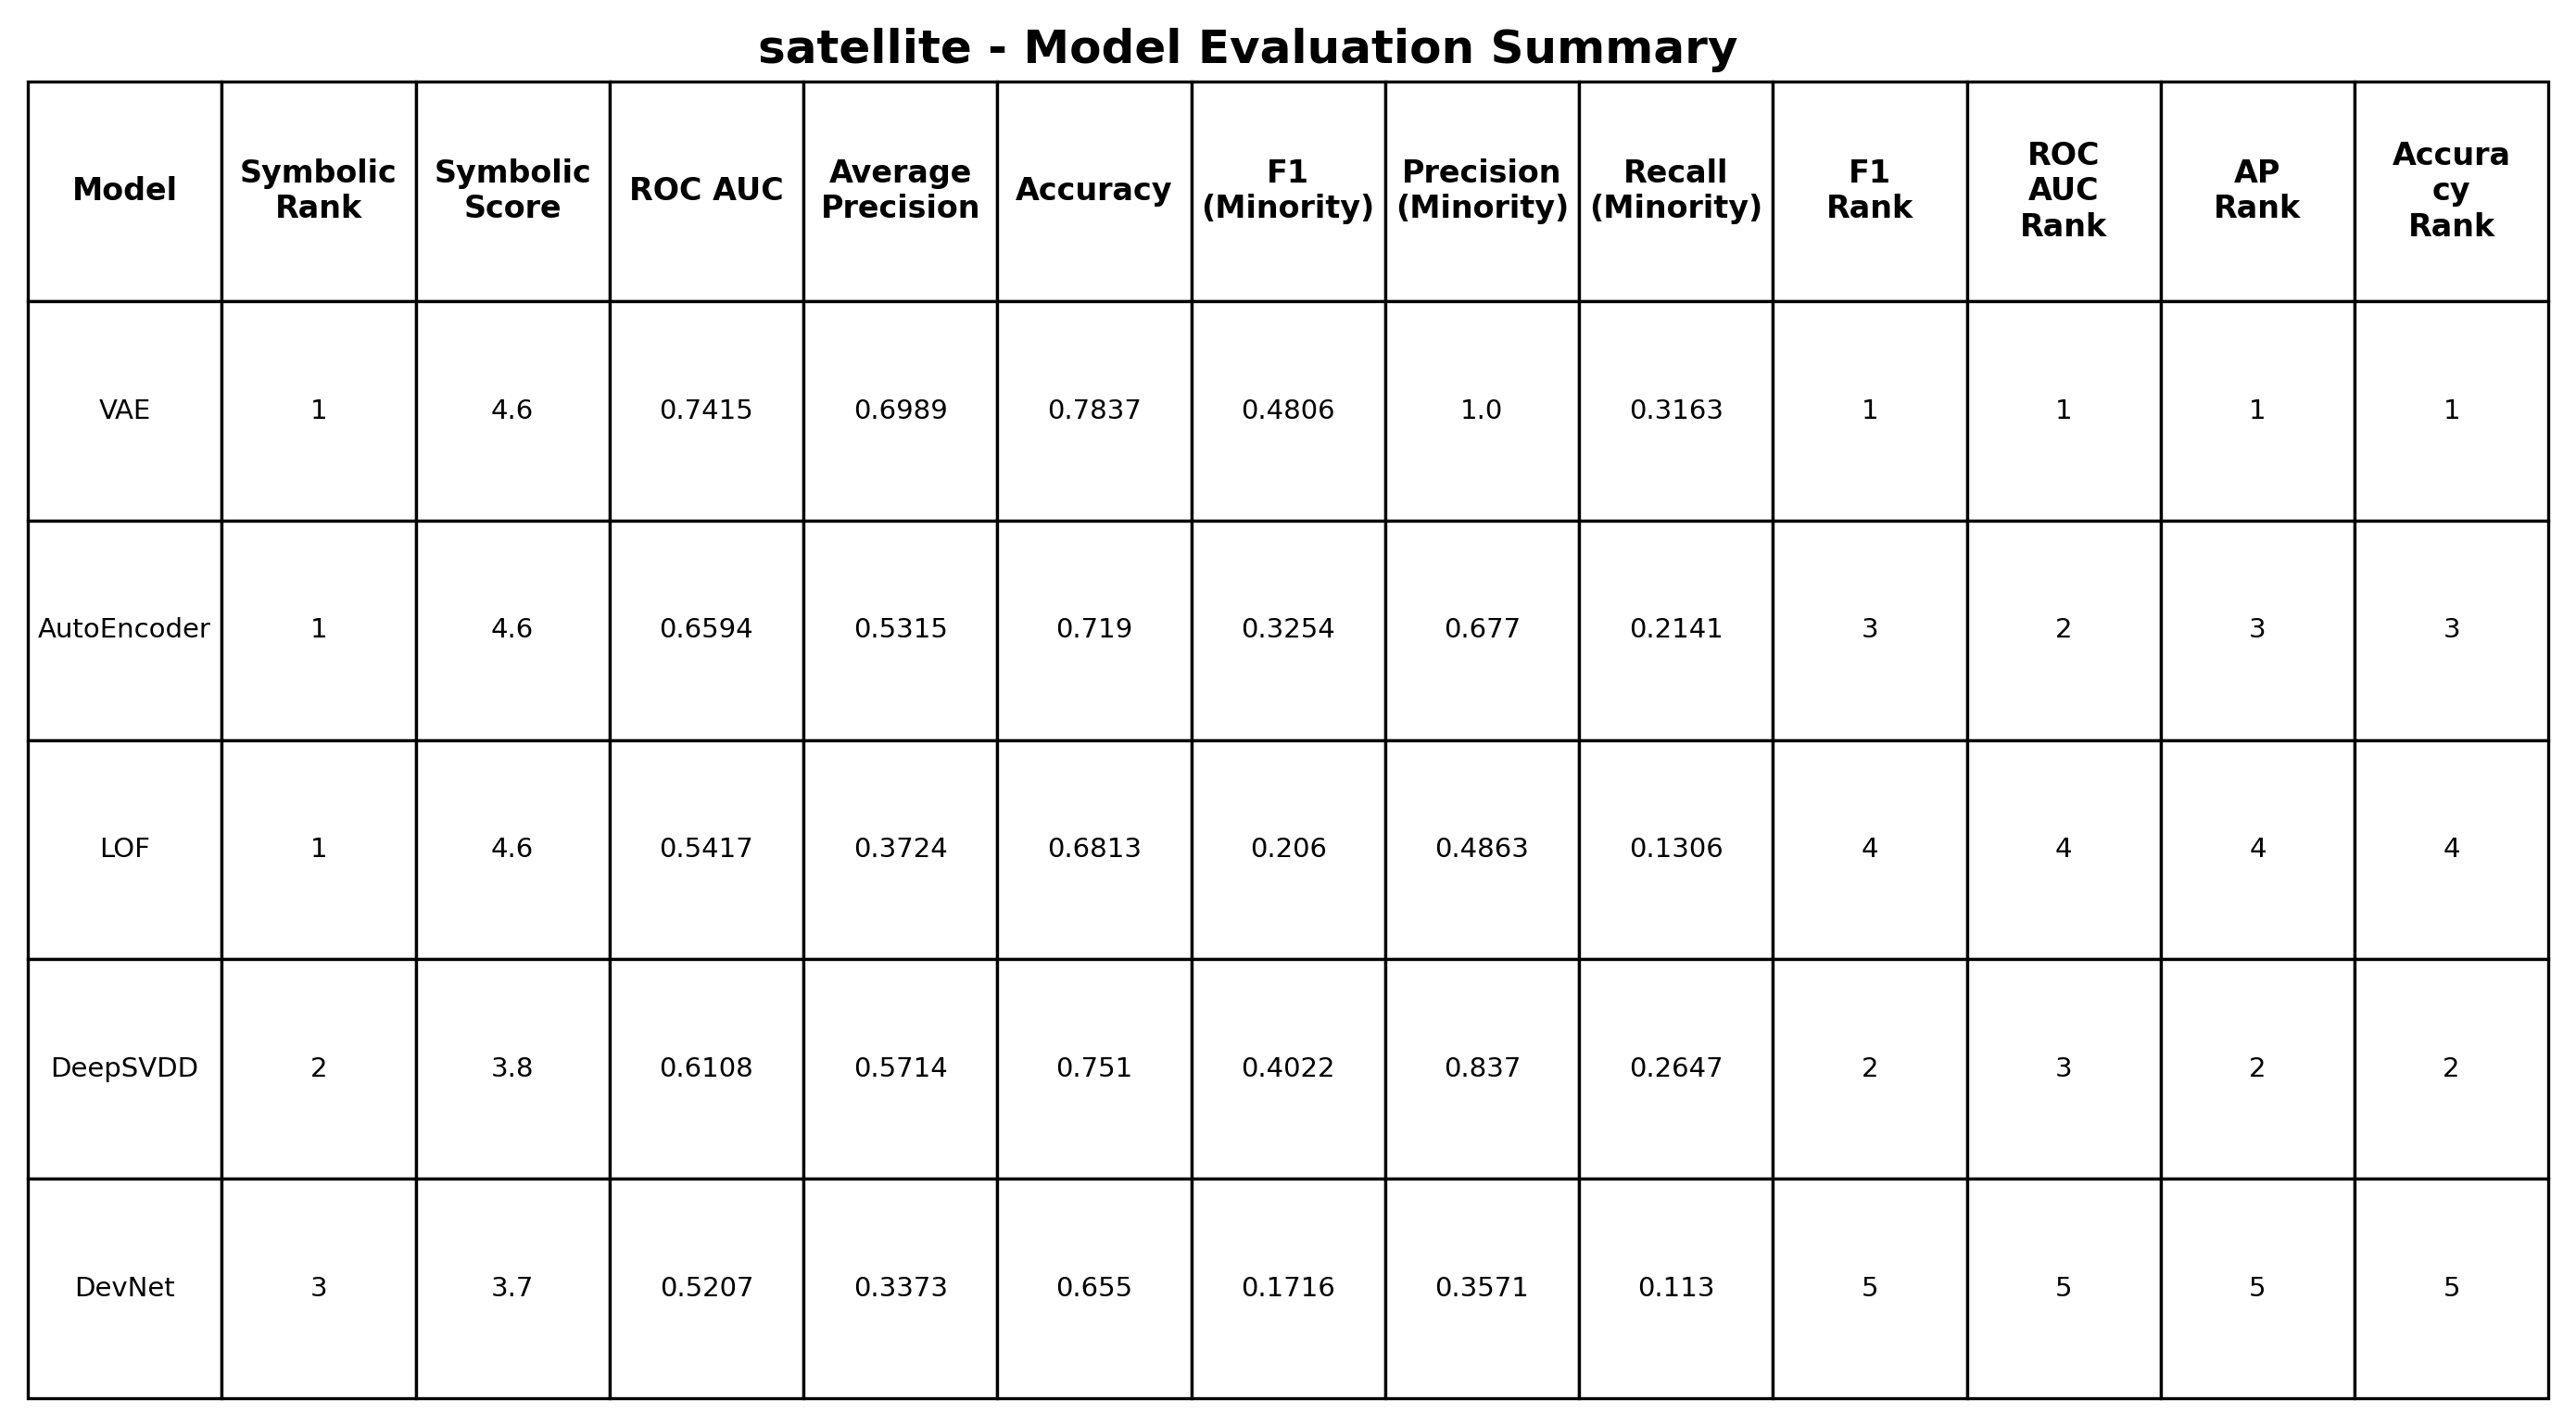

### Evaluation Heatmap

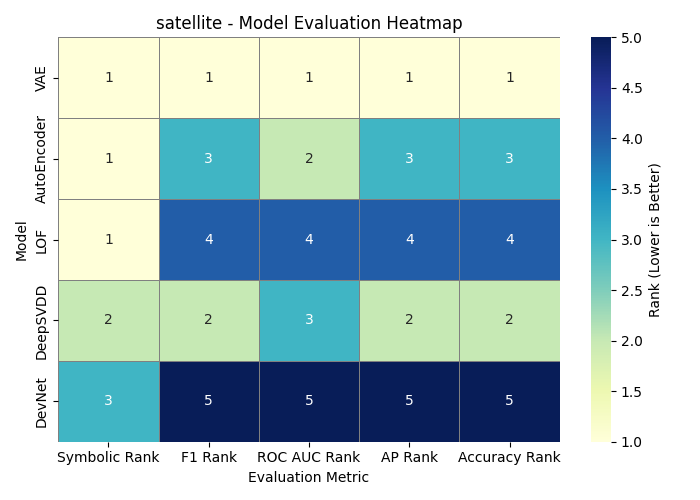

### Model-wise Multi-Metric Rankings

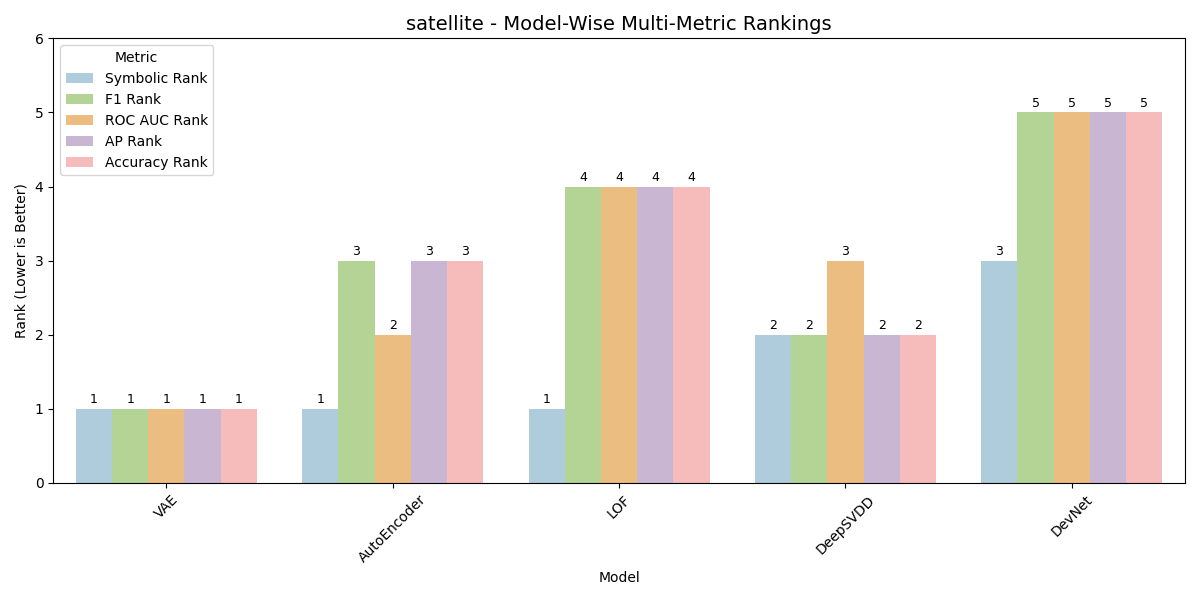

In [82]:
dataset_list = ["cardio", "Satellite"]
generate_llm_reports_for_multiple_datasets(dataset_list)

---

**Functional Explanation**

This function serves as a **controller** to **automatically generate LLM-powered evaluation and advisory reports** for a **list of datasets**, one after the other. It streamlines the full pipeline execution across multiple datasets in a single run.

---

* **Input Parameters:**

  * `dataset_names`: A list of dataset identifiers (e.g., `["cardio", "thyroid", "CICIDS2017"]`).
  * `prompt_template_path`: Path to the shared `prompt_template.json`, which contains the structured report logic and instruction blocks.
  * `static_cache`: A pre-loaded dictionary from `init_static_file_cache()` that includes symbolic scoring logic, tag definitions, etc.
  * `base_path`: Directory where input files like `{dataset_name}_llm_input.csv` and metadata files are stored.
  * `output_dir`: Directory where output reports (`.md` and `.pdf`) will be saved.

* **Execution Loop:**

  * Iterates over each dataset in `dataset_names`
  * For each dataset:

    1. Loads prompt, dynamic metadata, and visual files
    2. Sends a structured prompt to GPT
    3. Saves output as `.md` and optionally `.pdf`
  * **Errors are gracefully caught** per dataset and logged without halting the full loop.

---

**Usefulness**

* Enables **automated batch processing** of 10+, 16+, or even 100+ datasets.
* Ensures consistent structure and logic across all reports.
* Simplifies final-stage documentation for comparative analysis across multiple domains (e.g., healthcare, cybersecurity, industrial).

---